In [ ]:
'''
Run pw signal_cc, include and select unique datasets based on RFs.
Uses `DISTS` for different select_stimuli (fullfield, apertured, images)
NOTE: calls aggregate_ccdist(), which calculates noise_cc and signal_cc, 
so DISTS is actually CORRS.

Save figures for supplement.
'''


In [6]:
import os
import glob
import itertools
import json
import cv2
import sys

import matplotlib as mpl
import scipy.stats as spstats
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl
import pingouin as pg
# 
import analyze2p.gratings.utils as gutils
import analyze2p.plotting as pplot
import analyze2p.aggregate_datasets as aggr
import analyze2p.utils as hutils
import analyze2p.receptive_fields.utils as rfutils
import analyze2p.extraction.rois as roiutils
import analyze2p.correlations as cr
import importlib

import analyze2p.objects.selectivity as sel
import analyze2p.objects.sim_utils as su

In [7]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(axis_labelsize=7, lw_axes=0.25)
bw_colors = dict((v, [0.7]*3) for v in visual_areas)
#### Set trace ID and FOV/state type
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'

new_root = '/n/holylfs05/LABS/pfister_lab/Lab'
aggregate_dir = aggregate_dir.replace('/n', new_root)
rootdir = rootdir.replace('/n', new_root)

traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'

In [8]:
experiment = 'blobs'
responsive_test='ROC'
trial_epoch='stimulus'
# ---------------------------------------------------------------
response_type='dff'
if experiment=='rfs' and responsive_test=='nstds':
    responsive_thr=7.0
else:
    responsive_thr=0.05 if responsive_test=='ROC' else 10.0
print(responsive_test, responsive_thr)

ROC 0.05


In [9]:
# RF info
response_type='dff'
do_spherical_correction=False
combine_rfs='average'
# ------------------------------------

rf_correction_str = 'sphrcorr' if do_spherical_correction else 'uncorr'
rf_str = 'rfs-%s-%s' % (response_type, rf_correction_str)
print(rf_str)

rfs-dff-uncorr


# Load src data

In [10]:
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
meta = sdata[sdata.experiment.isin(['gratings'])].copy()
all_dkeys = [(va, dk) for (va, dk), g in meta.groupby(['visual_area', 'datakey'])]

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets


In [11]:
# Load trial metrics
NDATA0 = aggr.load_responsive_neuraldata(experiment, traceid=traceid,
                      response_type=response_type, trial_epoch=trial_epoch,
                      responsive_test=responsive_test, 
                      responsive_thr=responsive_thr)
if experiment not in ['rfs', 'rfs10']: # assigned in load_responsive_neuraldata()
    NDATA0['experiment'] = experiment 
print("Stimulus: %s (cell counts)" % experiment)
print(NDATA0[['visual_area', 'datakey', 'cell']]\
        .drop_duplicates()['visual_area'].value_counts().to_markdown())
# Get the cells
CELLS = aggr.get_all_responsive_cells(cells0, NDATA0) 
print(CELLS[['visual_area', 'animalid', 'session', 'fovnum']]\
            .drop_duplicates()['visual_area'].value_counts().to_markdown())

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
...loading: aggr_blobs_trialmeans_traces001_ROC-thr-0.05_dff_stimulus.pkl
Checking mislabeled
Stimulus: blobs (cell counts)
|    |   visual_area |
|:---|--------------:|
| V1 |          1259 |
| Lm |          1048 |
| Li |           583 |
|    |   visual_area |
|:---|--------------:|
| Li |            18 |
| Lm |            16 |
| V1 |            16 |


In [12]:
SDF, incorrect_stim = aggr.check_sdfs(NDATA0['datakey'].unique(), 
                            experiment=experiment,
                            images_only=False, rename=experiment=='blobs',
                            return_incorrect=True, return_all=False)
incorrect_stim.keys()

dict_keys(['20190314_JC070_fov1', '20190315_JC070_fov1', '20190316_JC070_fov1', '20190319_JC067_fov1', '20190320_JC067_fov1', '20190321_JC070_fov1', '20190322_JC073_fov1', '20190327_JC073_fov1'])

#### Get RFs

In [13]:
rf_fit_desc = rfutils.get_fit_desc(response_type=response_type,
                                  do_spherical_correction=do_spherical_correction)
rfdf = rfutils.aggregate_fits(cells0, sdata, combine=combine_rfs, 
                              response_type=response_type,
                              do_spherical_correction=do_spherical_correction,
                              reliable_only=True,
                              pass_criterion='position',
                              rootdir=rootdir)
rfdf = aggr.add_roi_positions(rfdf, rootdir=rootdir)

# Get polygons
try:
    rfpolys, _ = su.load_rfpolys(rf_fit_desc, combine_method=combine_rfs,
                                 aggregate_dir=aggregate_dir)
except FileNotFoundError as e:
    print("Creating new RF polys...")
    rfpolys, check_rfs = su.update_rfpolys(rfdf, rf_fit_desc, 
                                    combine_method=combine_rfs,
                                    create_new=True,
                                    aggregate_dir=aggregate_dir)

N dpaths: 58, N unfit: 0
N datasets included: 63, N sessions excluded: 4
N dpaths: 58, N unfit: 0
N datasets included: 63, N sessions excluded: 4


In [14]:
NDATA0.groupby(['visual_area'])['datakey'].nunique()

visual_area
Li    18
Lm    16
V1    16
Name: datakey, dtype: int64

In [15]:
rfdf.groupby(['visual_area'])['datakey'].nunique()

visual_area
Li    15
Lm    14
V1    19
Name: datakey, dtype: int64

In [16]:
# rfpolys, check_rfs = su.update_rfpolys(rfdf, rf_fit_desc, 
#                                 combine_method=combine_rfs,
#                                 create_new=True,
#                                 aggregate_dir=aggregate_dir)

In [17]:
rfpolys.shape, rfdf.shape

((1818, 3), (1819, 40))

# Output dirs

In [18]:
responsive_str = '%s_%s_%s-%.2f' % (trial_epoch, response_type, responsive_test, responsive_thr)
data_id = '|'.join([traceid, responsive_str, rf_str])
print(data_id)

# #### Set current output dir
# if experiment == 'gratings':
#     base_dir = os.path.join(aggregate_dir, 'correlations', 
#                        '%s_%s_%s' % (experiment, response_type, responsive_test))
# #                        'morph_tuning')
# else:
#     base_dir = os.path.join(aggregate_dir, 'correlations', 
#                    '%s_%s_%s' % (experiment, response_type, responsive_test),
#                     'morph_tuning')
#
base_dir = os.path.join(aggregate_dir, 'correlations', 
                   '%s_%s_%s' % (experiment, response_type, responsive_test))
print(base_dir)
print(base_dir)
FIGDIR = os.path.join(aggregate_dir, 'FIGURES', 'correlate_tuning_curves_MIGR',
                     experiment)
if not os.path.exists(FIGDIR):
    os.makedirs(FIGDIR)
print(FIGDIR)

traces001|stimulus_dff_ROC-0.05|rfs-dff-uncorr
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/FIGURES/correlate_tuning_curves_MIGR/blobs


# Aggregate

In [19]:
import _pickle as pkl
import copy

In [20]:
offset_type='minsub' 
lcorrection='none' # TODO
with_lum = False #True
# ----------------------------------------
# Results outfile
blob_str = '%s_%s_%s-%s' % (trial_epoch, responsive_test, offset_type, lcorrection)
print(blob_str)
print(rf_str)
dists_results_file = os.path.join(base_dir, 'results_%s_%s.pkl' % (blob_str, rf_str))
print(dists_results_file)

# Figure save dir
dst_dir = os.path.join(base_dir, '%s_%s' % (blob_str, rf_str))
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
print(dst_dir)

stimulus_ROC_minsub-none
rfs-dff-uncorr
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/results_stimulus_ROC_minsub-none_rfs-dff-uncorr.pkl
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/stimulus_ROC_minsub-none_rfs-dff-uncorr


In [21]:
os.path.exists(dists_results_file)

True

In [35]:
create_new_dists0=False
# ---
select_stimuli='apertured' if experiment=='gratings' else 'images'
# -----
match_stimulus_names = False if experiment=='gratings' else True
distance_var = 'rf_distance'
min_ncells=5

# NOTE: Run correlate_tuning_curves_MIGR.ipynb to rerun these
if not create_new_dists0:
    try:
        with open(dists_results_file, 'rb') as f:
            res = pkl.load(f)
        print(res.keys())
        DISTS0 = res['DISTS0_{}'.format(select_stimuli)]
        #avg_responses = res['responses']
        rfdf = res['rfdf']
        #CORRS = res['CORRS']
        #del res
    except Exception as e:
        print(e)
        create_new_dists0=True
print("new? %s" % str(create_new_dists0))

dict_keys(['DISTS', 'DISTS0_images', 'rfdf'])
new? False


In [38]:
rfdf.shape, rfpolys.shape

((1819, 40), (1818, 3))

In [18]:
if create_new_dists0:
    print("Creating new DISTS0...")
    #use_sdf = SDF.copy() if experiment=='gratings' else None
    DISTS0 = cr.aggregate_ccdist(NDATA0, experiment=experiment, rfdf=rfdf, rfpolys=rfpolys,
                    SDF=None, select_stimuli=select_stimuli,min_ncells=min_ncells,
                    distance_var=distance_var, verbose=True,
                    match_stimulus_names=match_stimulus_names)
    # Save
    with open(dists_results_file, 'rb') as f:
        res = pkl.load(f)
    print(res.keys())
    res['DISTS0_{}'.format(select_stimuli)] = DISTS0
    with open(dists_results_file, 'wb') as f:
        pkl.dump(res, f, protocol=2)

In [22]:
# Save
# with open(dists_results_file, 'wb') as f:
#     with open(dists_results_file, 'rb') as f:
#         res = pkl.load(f)
#     print(res.keys())
if create_new_dists0 and experiment=='blobs':
    res = {}
    res['DISTS'] = DISTS0
    res['DISTS0_{}'.format(select_stimuli)] = DISTS0
    #res['responses'] = avg_responses
    res['rfdf'] = rfdf
    #res['CORRS'] = CORRS
    print(res.keys())
    # res['DISTS0'] = DISTS0
    with open(dists_results_file, 'wb') as f:
        pkl.dump(res, f, protocol=2)

In [40]:
match_stimulus_names

True

In [41]:
DISTS0 = cr.aggregate_ccdist(NDATA0, experiment=experiment, rfdf=rfdf, rfpolys=rfpolys,
                    SDF=SDF, select_stimuli=select_stimuli,min_ncells=min_ncells,
                    distance_var=distance_var, verbose=True,
                    match_stimulus_names=match_stimulus_names)

Dist: rf_distance
Li 20190314_JC070_fov1 blobs
Wrong configs, excluding: 20190314_JC070_fov1
Li 20190315_JC070_fov1 blobs
Wrong configs, excluding: 20190315_JC070_fov1
Li 20190316_JC070_fov1 blobs
Wrong configs, excluding: 20190316_JC070_fov1
Li 20190319_JC067_fov1 blobs
Skipping - (Li, 20190319_JC067_fov1)
Li 20190320_JC067_fov1 blobs
Skipping - (Li, 20190320_JC067_fov1)
Li 20190321_JC070_fov1 blobs
Skipping - (Li, 20190321_JC070_fov1)
Li 20190322_JC073_fov1 blobs
Wrong configs, excluding: 20190322_JC073_fov1
Li 20190327_JC073_fov1 blobs
Wrong configs, excluding: 20190327_JC073_fov1
Li 20190422_JC076_fov1 blobs
    (20190422_JC076_fov1 NONE, skipping overlaps)
    getting rf metrics
Li 20190602_JC091_fov1 blobs
    getting rf metrics
Li 20190606_JC091_fov1 blobs
    getting rf metrics
Li 20190607_JC091_fov1 blobs
    getting rf metrics
Li 20190609_JC099_fov1 blobs
    getting rf metrics
Li 20190612_JC099_fov1 blobs
    getting rf metrics
Li 20190614_JC091_fov1 blobs
    getting rf met

In [24]:
DISTS0.groupby('visual_area')['datakey'].nunique()

visual_area
Li    15
Lm    15
V1    15
Name: datakey, dtype: int64

In [42]:
NDATA0.groupby('visual_area')['datakey'].nunique()

visual_area
Li    18
Lm    16
V1    16
Name: datakey, dtype: int64

In [43]:
rfdf.groupby('visual_area')['datakey'].nunique()

visual_area
Li    15
Lm    14
V1    19
Name: datakey, dtype: int64

## Filter duplicate FOVs after checking for responsive cells that also have RFs

In [44]:
def count_ncells_from_pairwise_df(DISTS1):
    d1 = DISTS1[['visual_area', 'datakey', 'cell_1']].drop_duplicates()
    d2 = DISTS1[['visual_area', 'datakey', 'cell_2']].drop_duplicates().rename(columns={'cell_2': 'cell_1'})
    d0 = pd.concat([d1.reset_index(drop=True), d2.reset_index(drop=True)], axis=0)
    DIST_cells = d0[['visual_area', 'datakey', 'cell_1']].drop_duplicates().rename(columns={'cell_1': 'cell'})
    return DIST_cells

In [45]:
DISTS1 = DISTS0[~np.isnan(DISTS0['rf_distance'])].copy()
DIST_cells = count_ncells_from_pairwise_df(DISTS1)

In [46]:
# DIST_cells.groupby(['visual_area', 'datakey'])['cell'].count()

In [47]:
importlib.reload(aggr)

<module 'analyze2p.aggregate_datasets' from '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/aggregate_datasets.py'>

In [48]:
counts0 = aggr.count_n_cells(DIST_cells, name='n_cells', reset_index=True)
# Get unique dkeys based on # cells fit
counts = counts0[(counts0.n_cells>=min_ncells)]
print(counts.groupby('visual_area').sum().to_markdown())
# Drop duplicates
u_dkeys = aggr.drop_repeats(counts, colname='n_cells') 

DISTS = pd.concat([g for (va, dk), g \
                       in DISTS0.groupby(['visual_area', 'datakey'])\
                       if (va, dk) in u_dkeys], 
                      ignore_index=True)

| visual_area   |   n_cells |
|:--------------|----------:|
| Li            |       156 |
| Lm            |       248 |
| V1            |       559 |


In [49]:
cnts0 = count_ncells_from_pairwise_df(DISTS0[~np.isnan(DISTS0['rf_distance'])])
cnts1 = count_ncells_from_pairwise_df(DISTS[~np.isnan(DISTS['rf_distance'])])

In [50]:
cnts0.groupby(['visual_area'])['cell'].count()

visual_area
Li    158
Lm    254
V1    572
Name: cell, dtype: int64

In [51]:
cnts1.groupby(['visual_area'])['cell'].count()

visual_area
Li     87
Lm    167
V1    500
Name: cell, dtype: int64

| visual_area   |   n_cells |
|:--------------|----------:|
| Li            |       195 |
| Lm            |       260 |
| V1            |       590 |

In [52]:
DISTS0.groupby(['visual_area'])['datakey'].nunique()

visual_area
Li    10
Lm    13
V1    15
Name: datakey, dtype: int64

In [53]:
DISTS.groupby(['visual_area'])['datakey'].nunique()

visual_area
Li    4
Lm    6
V1    8
Name: datakey, dtype: int64

In [54]:
NDATA = pd.concat([g for (va, dk), g \
                       in NDATA0.groupby(['visual_area', 'datakey'])\
                       if (va, dk) in u_dkeys], 
                      ignore_index=True)

In [55]:
NDATA.groupby(['visual_area'])['datakey'].nunique()

visual_area
Li    4
Lm    6
V1    8
Name: datakey, dtype: int64

In [56]:
final_cell_counts_with_rfs = cnts1.groupby(['visual_area', 'datakey']).count()
incl_dkeys = final_cell_counts_with_rfs[final_cell_counts_with_rfs>10].dropna().reset_index()

# Each FOV - signal_cc

In [353]:
# curr_corrs = CORRS[CORRS['visual_area']=='Li'].copy()
rf_maxdist = 100
rf_mindist= 0
rf_step = 5
ctx_maxdist = 1000
ctx_mindist = 30
ctx_step=50
currcorrs = DISTS[(DISTS['cortical_distance']>=ctx_mindist)
                  & (DISTS['cortical_distance']<=ctx_maxdist)
                  & (DISTS['rf_distance']>=rf_mindist)
                  & (DISTS['rf_distance']<=rf_maxdist)
          ].copy().dropna()
# Cut bins
currcorrs, dist_lut = cr.get_bins_and_cut(currcorrs, ctx_step=ctx_step, rf_step=rf_step, 
                                   dir_step=30, ori_step=15)

In [354]:
import math
n = 5
r = 2
n_combos = math.comb(n, r)
print(n_combos)

10


In [355]:
%matplotlib notebook
# currcorrs = currcorrs[currcorrs['datakey']!='20191111_JC120_fov1']
# currcorrs = currcorrs[currcorrs['datakey'].isin(incl_dkeys[ 'datakey'])]

<IPython.core.display.Javascript object>


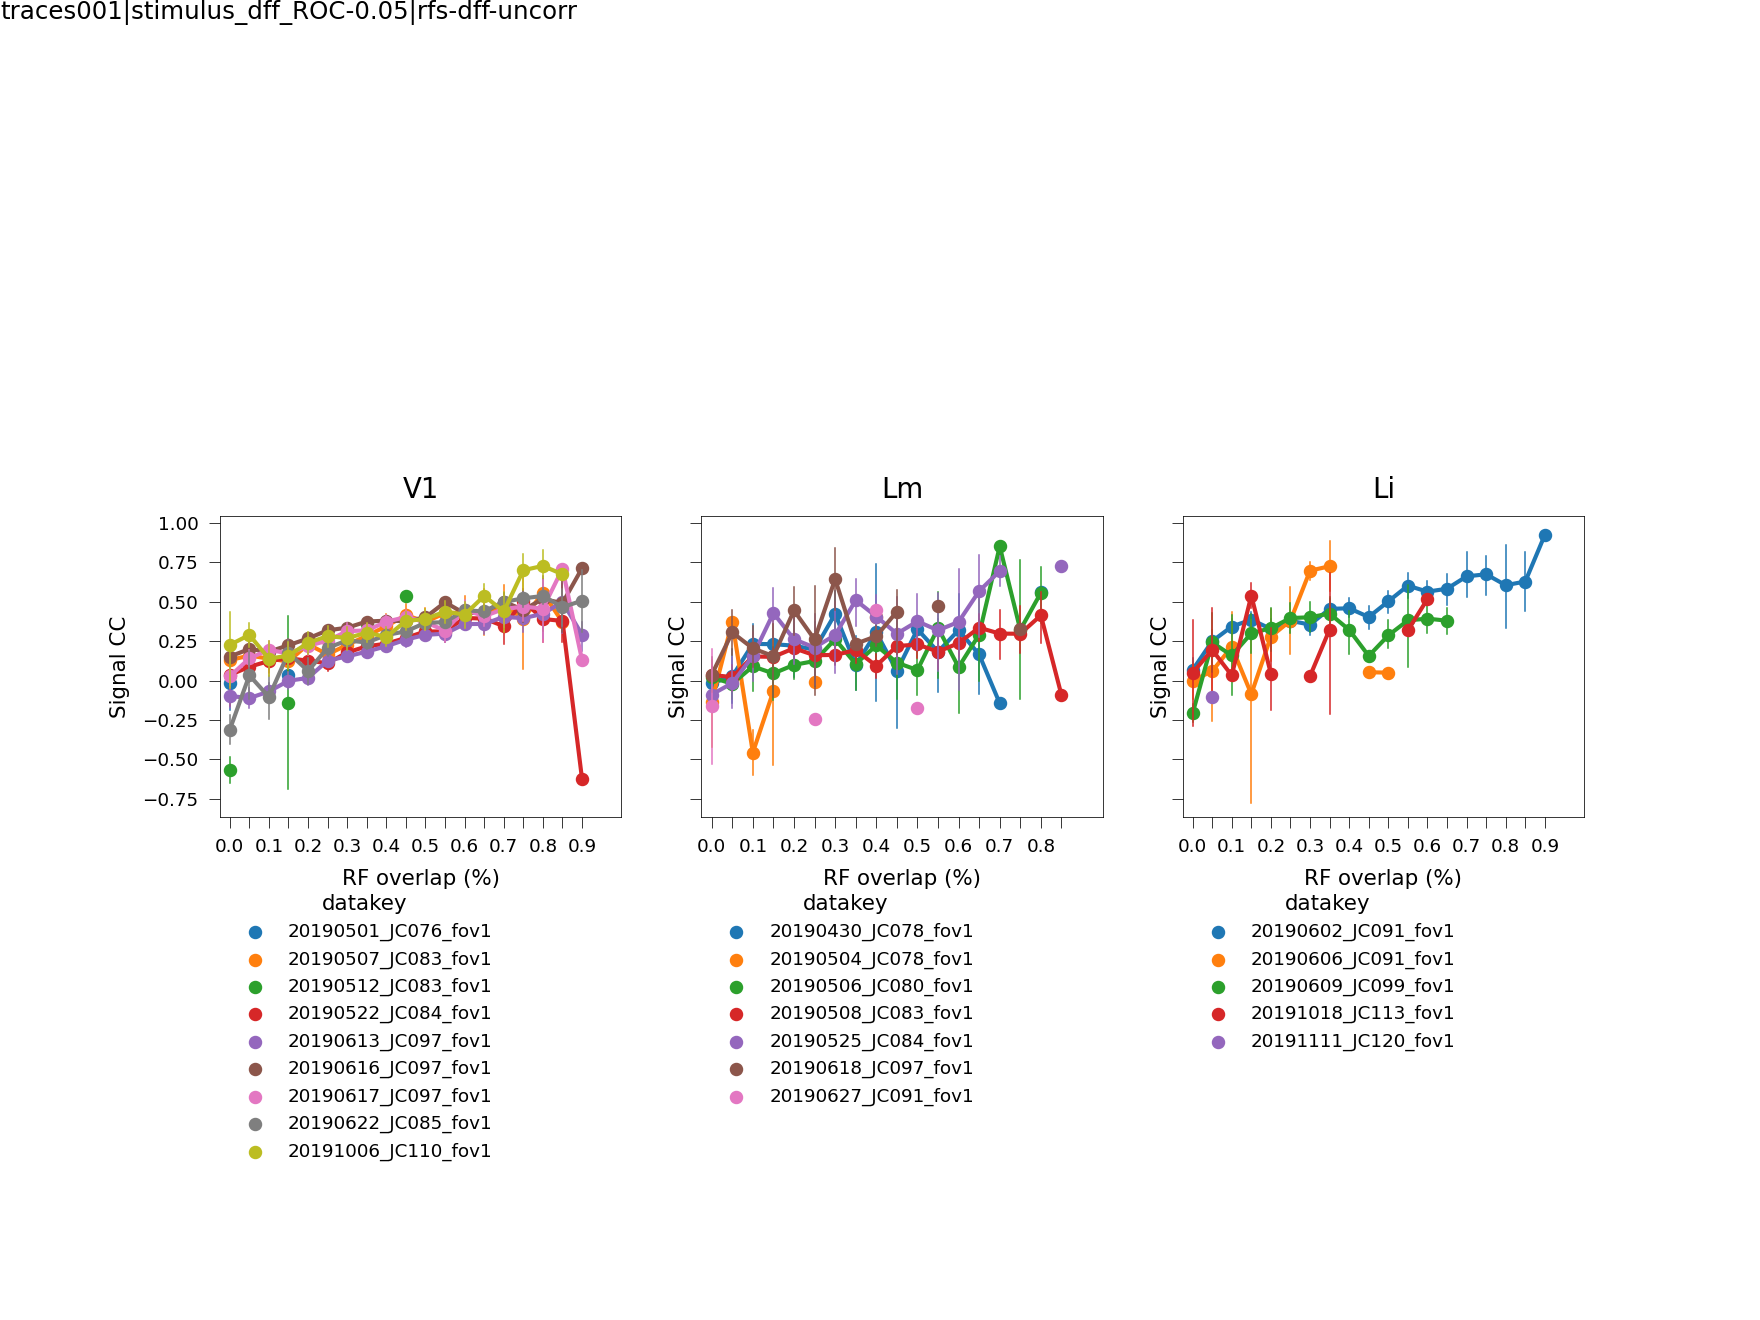

In [356]:
x_var = 'area_overlap'
y_var = 'signal_cc'

if x_var == 'area_overlap':
    xlabel = 'RF overlap (%)'
else:
    xlabel = 'RF distance (deg.)' if x_var == 'rf_distance'\
            else 'Cortical distance (\u00b5m)'

# mean
corr_means = currcorrs.dropna().groupby(['visual_area', 'datakey', \
                                 'binned_{}'.format(x_var)]).mean().reset_index()
n_dks_per_bin = corr_means.groupby(['visual_area', 'binned_{}'.format(x_var)]).count().reset_index()
max_bin_va = n_dks_per_bin[n_dks_per_bin[x_var]>=2]\
                .groupby('visual_area')['binned_{}'.format(x_var)].max()
# max_bin_va

#curr_plotdf = currcorrs[currcorrs['visual_area']=='Li'].copy()
fig, axn =pl.subplots(1,3, sharex=False, sharey=True, figsize=(8, 6))
ax=axn[0]
for va, vg in currcorrs.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    #max_bin = max_populated_bin.loc[va]
    #incl_vg = vg[vg['binned_{}'.format(x_var)]<=max_bin]
    sns.pointplot(x='binned_%s' % x_var, y=y_var, hue='datakey',
                data=vg, ax=ax, errorbar=('ci', 95),
                scale=0.5, errwidth=0.5)
    sns.move_legend(ax, bbox_to_anchor=(0, -0.2), loc='upper left', frameon=False)
    ax.set_box_aspect(0.75)
    ax.set_title(va)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Signal CC')
    
    xlabels = sorted(vg['binned_{}'.format(x_var)].unique())
    ax.set_xticks(range(len(xlabels)))
    ax.set_xlim([-0.5, np.argmax(xlabels) +2])
    xticks = ax.get_xticks()
    xtick_labels = [round(xlabels[i],1) if i%2==0 else "" for i, x in enumerate(xticks)]
    ax.set_xticklabels(xtick_labels)
pplot.label_figure(fig, data_id)

# fig.text(0.1, 0.9, '{} - {}'.format(experiment, select_stimuli))

# pl.subplots_adjust(bottom=0.5)
# figname = '{}_{}_each_FOV_{}_vs_{}_fovs'.format(experiment, select_stimuli, x_var, y_var)
# pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
# pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))
# print(figname)


In [357]:
for (va, dk), d_ in currcorrs.groupby(['visual_area', 'datakey']):
    d_

In [358]:
n_combos

10

In [359]:
cnts_per_bin = d_.groupby('binned_{}'.format(x_var))['neuron_pair'].nunique().reset_index()
# Get max populated bin
max_pop_bin =  cnts_per_bin[cnts_per_bin['neuron_pair']>0]['binned_{}'.format(x_var)].max()
# see if any bins unpopulated
curr_cnts = cnts_per_bin[cnts_per_bin['binned_{}'.format(x_var)]<=max_pop_bin]
curr_cnts[curr_cnts['neuron_pair']>=n_combos]

binned_area_overlap  neuron_pair
2                 0.10           11
3                 0.15           31
4                 0.20           48
5                 0.25           80
6                 0.30           80
7                 0.35           87
8                 0.40          129
9                 0.45          103
10                0.50          113
11                0.55           78
12                0.60           68
13                0.65           46
14                0.70           32
15                0.75           13

##### plot it prettier

In [362]:
mono_cdict = dict((k, [0.8]*3) for k in currcorrs['datakey'].unique())

In [363]:
%matplotlib notebook

<IPython.core.display.Javascript object>


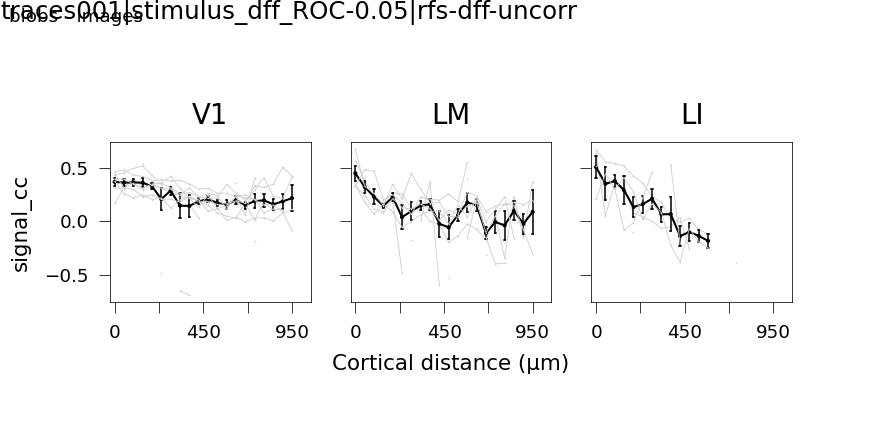

blobs_images_each_FOV_cortical_distance_vs_signal_cc_ctxmaxdist-1000um_mono


In [370]:
x_var = 'cortical_distance' # area_overlap
y_var = 'signal_cc'

if x_var == 'area_overlap':
    xlabel = 'RF overlap'
else:
    xlabel = 'RF distance (deg.)' if x_var == 'rf_distance'\
            else 'Cortical distance (\u00b5m)'
# mean
corr_means = currcorrs.dropna().groupby(['visual_area', 'datakey', \
                                 'binned_{}'.format(x_var)]).mean().reset_index()
n_dks_per_bin = corr_means.groupby(['visual_area', 'binned_{}'.format(x_var)]).count().reset_index()
max_bin_va = n_dks_per_bin[n_dks_per_bin[x_var]>=2]\
                .groupby('visual_area')['binned_{}'.format(x_var)].max()
# max_bin_va

#curr_plotdf = currcorrs[currcorrs['visual_area']=='Li'].copy()
fig, axn =pl.subplots(1,3, sharex=True, sharey=True, figsize=(4, 2))
ax=axn[0]
for va, vg in currcorrs.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    #max_bin = max_populated_bin.loc[va]
    #incl_vg = vg[vg['binned_{}'.format(x_var)]<=max_bin]
    sns.pointplot(x='binned_%s' % x_var, y=y_var, hue='datakey',
                data=vg, ax=ax,  palette=mono_cdict, errorbar=None, #('ci', 95),
                scale=0.1, markers='.', errwidth=0.1)
    ax.legend_.remove() #sns.move_legend(ax, bbox_to_anchor=(0, -0.2), loc='upper left', frameon=False)
#     ax.set_box_aspect(1)
    ax.set_title(va.upper())
    ax.set_xlabel(xlabel)
    ax.set_ylabel('{}'.format(y_var))
    
# Plot MEAN
dk_means = currcorrs.groupby(['visual_area', 'datakey', \
                                 'binned_{}'.format(x_var)]).mean().reset_index()
for va, vg in dk_means.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    #max_bin = max_populated_bin.loc[va]
    incl_vg = vg[vg['binned_{}'.format(x_var)]<=max_bin_va.loc[va]]
    sns.pointplot(x='binned_%s' % x_var, y=y_var, 
            data=incl_vg, ax=ax, errorbar='se',
            color='k', markers='.', scale=0.25, errwidth=0.5, capsize=0.15)

    ax.set_zorder(10000)  # Adjust the value as needed
    ax.set_box_aspect(0.8)
    ax.set_ylabel('{}'.format(y_var)) if va=='V1' else ax.set_ylabel('')
    ax.set_xlabel(xlabel) if va=='Lm' else ax.set_xlabel('')

    xlabels = sorted(incl_vg['binned_{}'.format(x_var)].unique())
    ax.set_xlim([-0.5, len(xlabels)+1 ])
    if x_var == 'area_overlap':
        xticks = np.linspace(0, len(xlabels)-1, 3)
        xtick_labels = [round(xlabels[int(x)], 1) if i==0 or i==len(xticks)-1 
                    else "" for i, x in enumerate(xticks)]
    else:
        xticks = np.linspace(0, len(xlabels)-1, 5)
        xtick_labels = [int(xlabels[int(x)]) if i%2==0 or i==len(xticks)-1 
                    else "" for i, x in enumerate(xticks)]
    ax.set_xticks( xticks )
    ax.set_xticklabels(xtick_labels)

pplot.label_figure(fig, data_id)
fig.text(0.01, 0.95, '{} - {}'.format(experiment, select_stimuli))

figname = '{}_{}_each_FOV_{}_vs_{}_ctxmaxdist-{}um_mono'.format(experiment, \
                                                                select_stimuli, x_var, y_var, ctx_maxdist)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))
print(figname)

In [372]:
from itertools import combinations
import statsmodels.stats.multitest as smm

In [373]:
x_var, y_var

('cortical_distance', 'signal_cc')

In [374]:
# x_var = 'cortical_distance'
# y_var = 'signal_cc'
s_list = []
i=0
for va, vg in currcorrs.groupby('visual_area'):
    for d, d_vg in vg.groupby('datakey'):
        X = d_vg[x_var].values
        y = d_vg[y_var].values
        slope, intercept, r_value, p_value, std_err = spstats.linregress(X, y)
        if np.isnan(p_value):
            continue
        print('{}: r={:.2f}, p={:.2f}'.format(d, r_value, p_value))
        stat = pd.DataFrame({'visual_area': va, 'datakey': d,
                      'slope': slope,
                      'intercept': intercept,
                      'pearson_r': r_value,
                      'p_value': p_value,
                      'std_err': std_err}, index=[i])
        s_list.append(stat)
        i+=1
statdf = pd.concat(s_list)

# ----------
stat_var = 'slope'
#perform Mann-Whitney test
results = {}
groups = ['V1', 'Lm', 'Li']
k_ = []
for group1, group2 in combinations(groups, 2):
    ks_stat, p_value = spstats.mannwhitneyu(
                statdf[statdf['visual_area']==group1][stat_var], 
                statdf[statdf['visual_area']==group2][stat_var],
                alternative='greater')
    results[f"{group1} vs {group2}"] = (ks_stat, p_value)

# Apply multiple comparisons correction
adjusted_p_values = smm.multipletests([r[1] for r in 
                                       results.values()], method='fdr_bh')[1]
# Print results
for (comparison, (ks_stat, p)), adj_p in zip(results.items(), adjusted_p_values):
    print(f"{comparison}: KS-stat = {ks_stat:.2f}, p = {p:.2f}, adjusted p = {adj_p:.2e}")
    ks = pd.DataFrame({'comparison': comparison,
                 'ks_stat': ks_stat, 'p': p, 'adjusted_p': adj_p}, index=[i])
    i+=1
    k_.append(ks)
sigdf = pd.concat(k_).reset_index(drop=True)
sigdf['A'] = [c.split(' ')[0] for c in sigdf['comparison']]
sigdf['B'] = [c.split(' ')[-1] for c in sigdf['comparison']]
sigdf.dropna()

20190602_JC091_fov1: r=-0.51, p=0.00
20190606_JC091_fov1: r=-0.45, p=0.00
20190609_JC099_fov1: r=-0.62, p=0.00
20191018_JC113_fov1: r=-0.03, p=0.89
20190430_JC078_fov1: r=-0.31, p=0.00
20190504_JC078_fov1: r=0.02, p=0.95
20190506_JC080_fov1: r=-0.02, p=0.60
20190508_JC083_fov1: r=-0.01, p=0.61
20190525_JC084_fov1: r=-0.20, p=0.00
20190618_JC097_fov1: r=-0.24, p=0.01
20190627_JC091_fov1: r=-0.25, p=0.64
20190501_JC076_fov1: r=-0.95, p=0.19
20190507_JC083_fov1: r=-0.24, p=0.00
20190512_JC083_fov1: r=0.30, p=0.56
20190522_JC084_fov1: r=-0.05, p=0.02
20190613_JC097_fov1: r=-0.18, p=0.00
20190616_JC097_fov1: r=-0.23, p=0.00
20190617_JC097_fov1: r=-0.15, p=0.00
20190622_JC085_fov1: r=-0.10, p=0.00
20191006_JC110_fov1: r=-0.33, p=0.00
V1 vs Lm: KS-stat = 27.00, p = 0.70, adjusted p = 6.97e-01
V1 vs Li: KS-stat = 28.00, p = 0.07, adjusted p = 1.11e-01
Lm vs Li: KS-stat = 24.00, p = 0.04, adjusted p = 1.09e-01


comparison  ks_stat         p  adjusted_p   A   B
0   V1 vs Lm     27.0  0.696766    0.696766  V1  Lm
1   V1 vs Li     28.0  0.074126    0.111189  V1  Li
2   Lm vs Li     24.0  0.036364    0.109091  Lm  Li

In [375]:
%matplotlib notebook

<IPython.core.display.Javascript object>


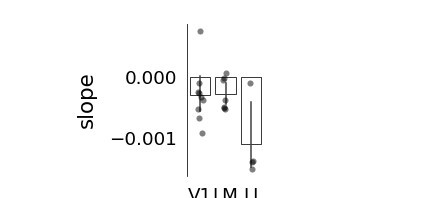

blobs_images_each_FOV_cortical_distance_vs_signal_cc_ctxmaxdist-1000um_stats


In [376]:
fig, ax = pl.subplots( figsize=(2,0.9))
for ai, yv in enumerate(['slope']): #, 'pearson_r']):
    ax=ax #n[ai]
    sns.barplot(statdf, x='visual_area', y=yv,ax=ax,
                  order=visual_areas, edgecolor='k', facecolor='none',
                errwidth=0.5, linewidth=0.25)
    sns.stripplot(statdf, x='visual_area', y=yv,ax=ax,
                  order=visual_areas, color='k', #hue='p_color', palette=p_cdict, size=3,
                  alpha=0.5, size=2)
    ax.set_box_aspect(2)
    pplot.annotate_multicomp_by_area(ax, sigdf,p_var='adjusted_p',
                                     offset=0.0002, y_loc=0.0001)
#     sns.move_legend(ax, loc='upper left', bbox_to_anchor=(1,1), 
#                     frameon=False, title='regr. fit', fontsize=6, markerscale=0.5)
    ax.tick_params(length=0)
#     if x_var=='cortical_distance':
#         ax.set_ylim([ -0.0012, 0.0005])
#     else:
#         ax.set_ylim([0, 1.5])
#         ax.set_yticks(np.linspace(0, 1.5, 4))
    ax.set_xticklabels(['V1', 'LM', 'LI'])
    ax.set_xlabel('')
pl.subplots_adjust(right=0.9, wspace=0.5)
sns.despine(trim=False, bottom=True)


figname = '{}_{}_each_FOV_{}_vs_{}_ctxmaxdist-{}um_stats'\
                        .format(experiment, select_stimuli, x_var, y_var, ctx_maxdist)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))
print(figname)

In [377]:
statdf

visual_area              datakey     slope  intercept  pearson_r  \
0           Li  20190602_JC091_fov1 -0.001498   0.739606  -0.508380   
1           Li  20190606_JC091_fov1 -0.001358   0.482097  -0.452489   
2           Li  20190609_JC099_fov1 -0.001379   0.551431  -0.615872   
3           Li  20191018_JC113_fov1 -0.000096   0.184388  -0.028428   
4           Lm  20190430_JC078_fov1 -0.000517   0.301680  -0.308129   
5           Lm  20190504_JC078_fov1  0.000050  -0.088227   0.021006   
6           Lm  20190506_JC080_fov1 -0.000051   0.097178  -0.024670   
7           Lm  20190508_JC083_fov1 -0.000022   0.154794  -0.014540   
8           Lm  20190525_JC084_fov1 -0.000492   0.398840  -0.195419   
9           Lm  20190618_JC097_fov1 -0.000504   0.380057  -0.237098   
10          Lm  20190627_JC091_fov1 -0.000379   0.083192  -0.245921   
11          V1  20190501_JC076_fov1 -0.000915   0.508781  -0.954743   
12          V1  20190507_JC083_fov1 -0.000516   0.433246  -0.237842   
13          V1  20190512_JC083_fov1  0.000741  -0.422230   0.300645   
14          V1  20190522_JC084_fov1 -0.000104   0.256292  -0.045407   
15          V1  20190613_JC097_fov1 -0.000326   0.297429  -0.182696   
16          V1  20190616_JC097_fov1 -0.000381   0.495087  -0.226629   
17          V1  20190617_JC097_fov1 -0.000263   0.376731  -0.145061   
18          V1  20190622_JC085_fov1 -0.000246   0.387199  -0.101270   
19          V1  20191006_JC110_fov1 -0.000663   0.562644  -0.329693   

         p_value   std_err  
0   1.348119e-79  0.000073  
1   5.919613e-04  0.000371  
2   2.115529e-16  0.000148  
3   8.880623e-01  0.000674  
4   1.999424e-06  0.000106  
5   9.540686e-01  0.000841  
6   5.988808e-01  0.000096  
7   6.092753e-01  0.000043  
8   5.202055e-05  0.000120  
9   1.488040e-02  0.000203  
10  6.385552e-01  0.000747  
11  1.922596e-01  0.000285  
12  7.428962e-16  0.000063  
13  5.626195e-01  0.001176  
14  1.873427e-02  0.000044  
15  9.929616e-26  0.000031  
16  9.234259e-55  0.000024  
17  3.001114e-10  0.000042  
18  1.167391e-09  0.000040  
19  5.408704e-25  0.000062

In [378]:
FIGDIR

'/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/FIGURES/correlate_tuning_curves_MIGR/blobs'

In [379]:
import math
n = 5
r = 2
n_combos = math.comb(n, r)
print(n_combos)

10


In [380]:
currcorrs[(currcorrs['area_overlap']>=0.75)
        & (currcorrs['signal_cc']<=0)
         & (currcorrs['visual_area']=='Li')][['visual_area', 'datakey', 'neuron_pair']]


Empty DataFrame
Columns: [visual_area, datakey, neuron_pair]
Index: []

In [82]:
currcorrs[(currcorrs['area_overlap']>=0.85)
& (currcorrs['signal_cc']<0)]\
    [['visual_area', 'datakey', 'signal_cc', 'area_overlap', 'cortical_distance', 'neuron_pair']] #[['visual_area', 'datakey']]

visual_area              datakey  signal_cc  area_overlap  \
24792           Lm  20190508_JC083_fov1  -0.091909      0.852780   
45198           V1  20190522_JC084_fov1  -0.624686      0.915934   
72230           V1  20190616_JC097_fov1  -0.209649      0.899388   
112470          V1  20190622_JC085_fov1  -0.509246      0.884878   

        cortical_distance neuron_pair  
24792           45.640871     146_148  
45198          143.499160       21_26  
72230          229.801507      94_156  
112470         168.952671       69_87

In [83]:
currcorrs[(currcorrs['visual_area']=='Li')
        & (currcorrs['signal_cc']<=0)]['area_overlap']

149      0.237529
170      0.456045
233      0.095966
254      0.257079
479      0.314506
           ...   
12965    0.398901
13043    0.211119
13190    0.208151
13252    0.237791
13277    0.223900
Name: area_overlap, Length: 388, dtype: float64

In [84]:
import analyze2p.extraction.traces as traceutils

def smooth_timecourse(in_trace, win_size=41):
    #smooth trace
    win_half = int(round(win_size/2))
    trace_pad = np.pad(in_trace, ((win_half, win_half)), 'reflect') # 'symmetric') #'edge')

    smooth_trace = np.convolve(trace_pad, np.ones((win_size,))*(1/float(win_size)),'valid')
    
    return smooth_trace

def smooth_traces_trial(gg, win_size=5, colname='trial'):
    smoothed_ = smooth_timecourse(gg, win_size=win_size)
    return pd.Series(smoothed_)

def get_best_ixs(rdf, normalize_tuning_curves=False):
    '''
    Get size and morph tuning curves, assign "best" morph/size to each cell. 
    
    Arguments:
        rdf (pd.DataFrame) - mean responses to each config, for each cell
    Returns:
        best_ixs (pd.DataFrame) 
    '''
    
    #### Generate tuning curves
    morph_curves, size_curves = sel.get_object_tuning_curves(rdf, sort_best_size=False,
                                    normalize=normalize_tuning_curves, 
                                    return_stacked=True)
    #### Calculate morph selectivity index
    morph_ixs = rdf.groupby(['cell']).apply(sel.assign_morph_ix, 
                                            at_best_other=True, name='morph_sel')
    morph_ixs.index = morph_ixs.index.droplevel(1)
    sorted_morph_ixs = morph_ixs.sort_values(by='morph_sel', ascending=False)

    #### Calculate size tolerance
    size_tols = rdf.groupby(['cell']).apply(sel.assign_size_tolerance, 
                                            at_best_other=True, name='size_tol')
    size_tols.index = size_tols.index.droplevel(1)
    sorted_size_tols = size_tols.sort_values(by='size_tol', ascending=False)

    #### Combine
    best_ixs = pd.concat([size_tols, morph_ixs], axis=1).reset_index()
    best_ixs.index=best_ixs['cell']

    max_morph=max(morphlevels)
    best_ixs['best_morphlevel_normed'] = best_ixs['best_morphlevel']/float(max_morph)
#     best_ixs.head()
    best_ixs.index.name=None
    best_ixs.head()
    best_ixs['visual_area'] = rdf['visual_area'].unique()[0]
    best_ixs['datakey'] = rdf['datakey'].unique()[0]
    best_ixs['experiment'] = 'blobs'
    return best_ixs

In [86]:
# dk = '20190614_JC091_fov1'
# va='Li'
# check_rois = [25, 26]

dk = '20190522_JC084_fov1'
va = 'V1'
check_rois = [21, 26]

In [87]:
data_fpath = traceutils.get_data_fpath(dk, experiment_name='blobs',
                                       rootdir=rootdir)
print(data_fpath)
raw_traces, labels, sdf, run_info = traceutils.load_dataset(data_fpath, 
                                                    trace_type='corrected',
                                                    rootdir=rootdir)
processed, trialmetrics = aggr.process_traces(raw_traces, labels, 
                        trace_type='dff', 
                        response_type='dff', trial_epoch='stimulus')

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_ea0b53_traces001_92d492_traces001_af4cfd_traces001_9188fa_traces001_b44714_traces001_133108/data_arrays/corrected.npz
--- processed traces: dff


In [89]:
rid = check_rois[0]

In [90]:
rtraces = labels.copy()
rtraces['dff'] = processed[rid].copy()
rtraces['tsec'] = rtraces['tsec'].astype(float).round(2)

In [91]:
curr_cfgs = sdf[sdf['morphlevel']!=-1].index.tolist()
morphlevels = sdf[sdf['morphlevel']!=-1]['morphlevel'].unique()
sizes = list(sorted(sdf[sdf['morphlevel']!=-1]['size'].unique()))
M = list(sorted(morphlevels))

<IPython.core.display.Javascript object>


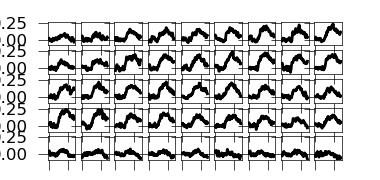

<IPython.core.display.Javascript object>


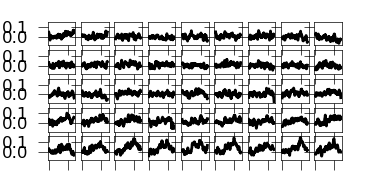

In [92]:
show_stim_name=False
mean_only=True
mean_lw=1
ls='-'
for rid in check_rois:
    #### plot bw
    rtraces['dff'] = processed[rid].copy()
    currt = rtraces[rtraces.config.isin(curr_cfgs)].copy()
    currt['size'] = sdf.loc[currt['config']]['size'].values
    currt['morphlevel'] = sdf.loc[currt['config']]['morphlevel'].values

    fig, axn = pl.subplots(5, len(morphlevels), figsize=(1.9, 0.9), #(4.5, 2.5), 
                           sharex=True, sharey=True)
    for (sz, mp), g in currt.groupby(['size', 'morphlevel']):
        si = sizes[::-1].index(sz) # sizes.index(sz) #
        mi = M.index(mp)
        ax=axn[si, mi]
        ax.patch.set(alpha=0)
        if show_stim_name:
            ax.set_title('{}, {}'.format(mp, sz))
        t_df = g.groupby(['trial'])['dff'].apply(smooth_traces_trial, win_size=5).unstack().T
        mean_t = np.nanmean(t_df, axis=1)
        std_t = np.nanstd(t_df, axis=1)
        sem_t = spstats.sem(t_df, axis=1, nan_policy='omit')

        if not mean_only:
            if fill_sem:
                #ax.fill_between(np.arange(0, len(mean_t)), mean_t-std_t, mean_t+std_t, alpha=0.2, color='k')
                ax.fill_between(np.arange(0, len(mean_t)), mean_t-sem_t, mean_t+sem_t, alpha=0.2, color='k')
            else:
                ax.plot(t_df, lw=lw, color='gray', alpha=1) #'k')
        ax.plot(mean_t, lw=mean_lw, c='k', linestyle=ls) #, label='%s %i' % (hue_, curr_hue))


In [93]:
configs = curr_cfgs

In [94]:
# Select cells for this dataset
x0 = NDATA0[(NDATA0.visual_area==va) & (NDATA0.datakey==dk) 
          & (NDATA0.config.isin(configs))].copy()
# Get mean response to each config
rdf0 = x0.groupby(['cell', 'config', 'datakey', 'visual_area', 'experiment']).mean().reset_index().drop('trial', axis=1)
rdf_offset = sel.correct_offset(rdf0, offset=offset_type)
rdf = sel.correct_luminance(rdf_offset, sdf, lcorrection=lcorrection)
rdf['size'] = sdf.loc[rdf['config']]['size'].values
rdf['morphlevel'] = sdf.loc[rdf['config']]['morphlevel'].values
best_ixs = get_best_ixs(rdf)

In [95]:
normalize_tuning_curves = True
morph_curves, size_curves = sel.get_object_tuning_curves(rdf, sort_best_size=False,
                                normalize=normalize_tuning_curves, return_stacked=True)

In [96]:
### rid = 217
selected_morphlevels = sorted(sdf['morphlevel'].unique())[1:]

t_list=[]
# curr_plot_rois = [76, 234, 40]
for rid in check_rois: #top_rois_with_rfs[0:20]:
    best_sz = int(morph_curves[morph_curves['cell']==rid]['best_size'].unique())
    cfgs_ = sdf[(sdf['size']==best_sz) & sdf['morphlevel'].isin(selected_morphlevels)]\
                .index.tolist()
    tdf = traceutils.get_mean_and_std_traces(rid, processed, labels, 
                    cfgs_, sdf[sdf.morphlevel.isin(selected_morphlevels)], 
                    param='morphlevel', 
                    return_stacked=True, smooth=True, win_size=9)
#     tdf['has_rfs'] = ~np.isnan(fits_rfs.loc[rid]['x0'])
    tdf['cell']=rid
    tdf['best_morphlevel'] = best_ixs.loc[rid]['best_morphlevel']
    tdf['best_size'] = best_ixs.loc[rid]['best_size']
    t_list.append(tdf)
trace_ex = pd.concat(t_list, axis=0)
trace_ex = trace_ex.reset_index(drop=True)
trace_ex['sem_lo'] = trace_ex['mean'].values - trace_ex['sem'].values
trace_ex['sem_hi'] = trace_ex['mean'].values + trace_ex['sem'].values
trace_ex.head()

time morphlevel      mean       sem  cell  best_morphlevel  best_size  \
0 -1.007873          0  0.017316  0.041979    21              0.0       20.0   
1 -0.985476          0  0.019453  0.042684    21              0.0       20.0   
2 -0.963079          0  0.021954  0.041609    21              0.0       20.0   
3 -0.940682          0  0.011764  0.041317    21              0.0       20.0   
4 -0.918285          0  0.015103  0.039567    21              0.0       20.0   

     sem_lo    sem_hi  
0 -0.024663  0.059295  
1 -0.023231  0.062137  
2 -0.019656  0.063563  
3 -0.029553  0.053081  
4 -0.024464  0.054670

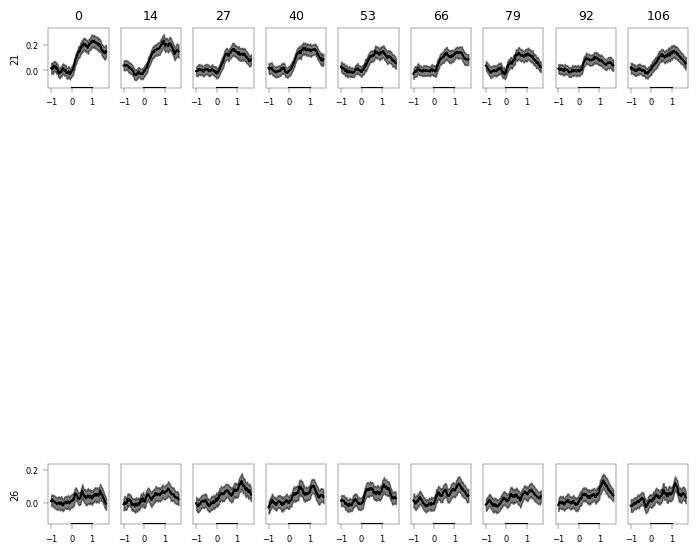

In [97]:
%matplotlib inline
fig, axn = pl.subplots(len(check_rois), len(morphlevels),
                      figsize=(8,10)) #, sharey=True)
for ai, roi in enumerate(check_rois):
    plotd = trace_ex[ (trace_ex['cell']==roi) & (trace_ex['morphlevel']!=-1)].copy()
    minv, maxv = plotd['mean'].min(), plotd['mean'].max()
    for mi, (mlevel, md) in enumerate(plotd.groupby('morphlevel')):
        ax=axn[ai, mi]
        ax.plot(md['time'], md['mean'], color='k') #tuning_cdict[roi])
        ax.fill_between(md['time'], md['sem_lo'], md['sem_hi'], alpha=0.5,
                        color='k') #tuning_cdict[roi])
        if mi==0:
            ax.set_ylabel(roi)
        else:
            ax.set_yticks([])
        if ai==0:
            ax.set_title(mlevel)
        ax.set_ylim([minv-0.1, maxv+0.1])
        ax.set_box_aspect(1)
        ax.plot([0, 1], [ax.get_ylim()[0], ax.get_ylim()[0]], 'k')
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)

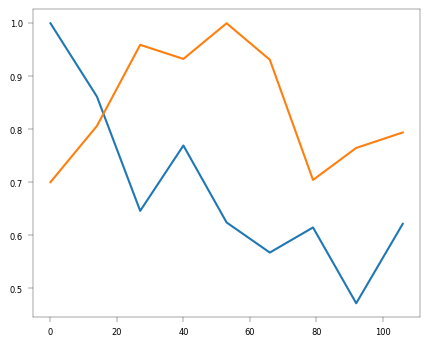

In [98]:
fig, ax =pl.subplots()
for rid in check_rois:
    ax.plot(morph_curves[morph_curves['cell']==rid]['morphlevel'],
        morph_curves[morph_curves['cell']==rid]['response'])


##### incl_vg.columns

# Compare within best_size

In [291]:
NDATA.groupby(['visual_area', 'datakey'])['cell'].nunique()

visual_area  datakey            
Li           20190602_JC091_fov1     87
             20190609_JC099_fov1     60
             20190614_JC091_fov1     78
             20191018_JC113_fov1     47
Lm           20190430_JC078_fov1     98
             20190504_JC078_fov1     59
             20190508_JC083_fov1    100
             20190525_JC084_fov1     91
             20190603_JC080_fov1    120
             20190618_JC097_fov1     41
V1           20190507_JC083_fov1     97
             20190508_JC083_fov1     19
             20190522_JC084_fov1    107
             20190613_JC097_fov1    120
             20190616_JC097_fov1    185
             20190617_JC097_fov1    182
             20190622_JC085_fov1    196
             20191006_JC110_fov1     86
Name: cell, dtype: int64

##### TEST 1 FOV

In [57]:
all_morph_and_pos0[(all_morph_and_pos0['visual_area']=='Li')
                  & (all_morph_and_pos0['datakey']=='20191018_JC113_fov1')]

NameError: name 'all_morph_and_pos0' is not defined

In [106]:
va ='Li'
dk = '20191018_JC113_fov1'
# Select cells for this dataset
x0 = NDATA0[(NDATA0.visual_area==va) & (NDATA0.datakey==dk) 
          & (NDATA0.config.isin(configs))].copy()
sdf = aggr.get_stimuli(dk, experiment, match_names=True)
if with_lum:
    configs = sdf.index.tolist()
else:
    configs = sdf[sdf['morphlevel']!=-1].index.tolist()
sizes = list(sorted(sdf['size'].unique()))
morphlevels = list(sorted(sdf.loc[configs]['morphlevel'].unique()))

# Get mean response to each config
rdf0 = x0.groupby(['cell', 'config', 'datakey', 'visual_area', 'experiment']).mean().reset_index().drop('trial', axis=1)
rdf_offset = sel.correct_offset(rdf0, offset=offset_type)
rdf = sel.correct_luminance(rdf_offset, sdf, lcorrection=lcorrection)
rdf['size'] = sdf.loc[rdf['config']]['size'].values
rdf['morphlevel'] = sdf.loc[rdf['config']]['morphlevel'].values
# Get position of each cell
posdf = rdf[['visual_area', 'datakey', 'experiment', 'cell']].drop_duplicates()
posdf = aggr.add_roi_positions(posdf, rootdir=rootdir)

#### Generate tuning curves
morph_curves, size_curves = sel.get_object_tuning_curves(rdf, sort_best_size=False,
                                                normalize=True, return_stacked=True)

morph_curves

cell     config              datakey visual_area experiment  response  \
0      52  config010  20191018_JC113_fov1          Li      blobs  1.000000   
1      52  config015  20191018_JC113_fov1          Li      blobs  0.683838   
2      52  config020  20191018_JC113_fov1          Li      blobs  0.533008   
3      52  config025  20191018_JC113_fov1          Li      blobs  0.575306   
4      52  config030  20191018_JC113_fov1          Li      blobs  0.578464   
..    ...        ...                  ...         ...        ...       ...   
418   191  config028  20191018_JC113_fov1          Li      blobs  0.888514   
419   191  config033  20191018_JC113_fov1          Li      blobs  1.000000   
420   191  config038  20191018_JC113_fov1          Li      blobs  0.812060   
421   191  config043  20191018_JC113_fov1          Li      blobs  0.627744   
422   191  config048  20191018_JC113_fov1          Li      blobs  0.298664   

     best_size morphlevel  
0         50.0          0  
1         50.0         14  
2         50.0         27  
3         50.0         40  
4         50.0         53  
..         ...        ...  
418       30.0         53  
419       30.0         66  
420       30.0         79  
421       30.0         92  
422       30.0        106  

[423 rows x 8 columns]

In [107]:
df_list = []
for curr_size, curr_morph_curves in morph_curves.groupby('best_size'):
    curr_morph_curves = morph_curves[morph_curves['best_size']==curr_size]
    curr_rois = morph_curves[morph_curves['best_size']==curr_size]['cell'].unique()
    if len(curr_rois) < 3:
        continue
    # Stack current morph curves
    morph_mat = curr_morph_curves[['cell', 'response', 'morphlevel']]\
                        .pivot(columns='cell', index='morphlevel')
    morph_mat.columns = morph_mat.columns.droplevel()
    morph_mat = morph_mat.sort_index(ascending=True)

    # Current cell pairs
    col_pairs = list(itertools.combinations(curr_rois, 2))
    
    # Get pairwise corrs
    m_list = [cr.compare_curves(morph_mat[a].values, morph_mat[b].values, a=a, b=b) \
                                                        for (a, b) in col_pairs]
    curr_corrs = pd.concat(m_list, axis=1).T
    # df_morph
    morph_and_pos = cr.get_pw_distance(curr_corrs, posdf)
    morph_and_pos[['xcorr', 'pearsons', 'cosim']] = morph_and_pos[['xcorr', 'pearsons', 'cosim']].astype(float)
    # morph_and_pos.head()
    morph_and_pos['best_size'] = curr_size
    morph_and_pos['datakey'] = dk
    morph_and_pos['visual_area'] = va
    df_list.append(morph_and_pos)
all_morph_and_pos = pd.concat(df_list)

In [108]:
all_morph_and_pos

xcorr  pearsons     cosim  cell_1  cell_2 neuron_pair  \
0   6.399441  0.519860  0.988761      84     101      84_101   
1   5.270467  0.591931  0.983714      84     106      84_106   
2   4.682284  0.033233  0.961052      84     108      84_108   
3   5.770216  0.205970  0.975995      84     117      84_117   
4   4.481484  0.483940  0.942504      84     120      84_120   
..       ...       ...       ...     ...     ...         ...   
86  2.310743  0.442712  0.893046      96     137      96_137   
87  2.617475  0.809296  0.958847      96     162      96_162   
88  3.917366  0.748538  0.967063     119     137     119_137   
89  3.963070  0.330092  0.927336     119     162     119_162   
90  3.069098  0.465012  0.923007     137     162     137_162   

    cortical_distance  best_size              datakey visual_area  
0           97.221220       10.0  20191018_JC113_fov1          Li  
1          200.118998       10.0  20191018_JC113_fov1          Li  
2          194.848169       10.0  20191018_JC113_fov1          Li  
3          365.440841       10.0  20191018_JC113_fov1          Li  
4          204.300594       10.0  20191018_JC113_fov1          Li  
..                ...        ...                  ...         ...  
86         115.335734       50.0  20191018_JC113_fov1          Li  
87         110.317325       50.0  20191018_JC113_fov1          Li  
88         388.669677       50.0  20191018_JC113_fov1          Li  
89         396.392454       50.0  20191018_JC113_fov1          Li  
90          39.174338       50.0  20191018_JC113_fov1          Li  

[238 rows x 10 columns]

<IPython.core.display.Javascript object>


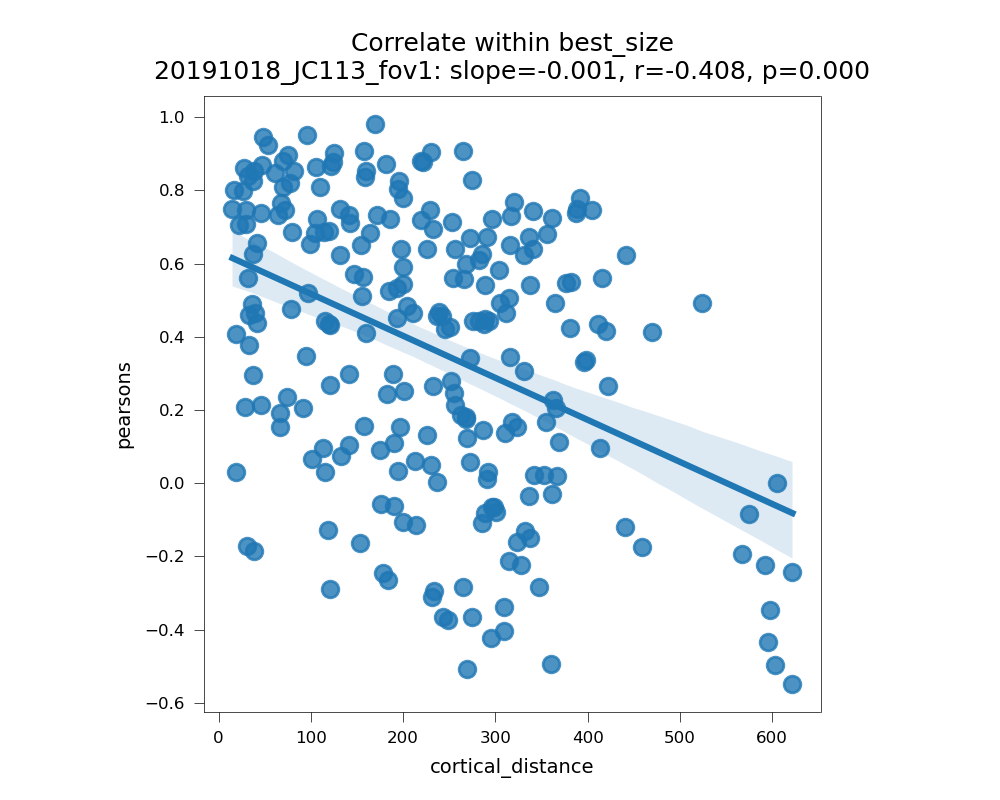

Text(0.5, 1.0, 'Correlate within best_size\n20191018_JC113_fov1: slope=-0.001, r=-0.408, p=0.000')

In [114]:
x_var = 'cortical_distance'
y_var='pearsons'

# stats
X = all_morph_and_pos[x_var].values
y = all_morph_and_pos[y_var].values
slope, intercept, r_value, p_value, std_err = spstats.linregress(X, y)
stat_str = '{}: slope={:.3f}, r={:.3f}, p={:.3f}'.format(dk, slope, r_value, p_value)

# plot
fig, ax =pl.subplots()
sns.regplot(data=all_morph_and_pos, x=x_var, y=y_var, ax=ax)
ax.set_box_aspect(1)
ax.set_title('Correlate within best_size\n{}'.format(stat_str))


## Now, do all FOV

In [51]:
importlib.reload(cr)

<module 'analyze2p.correlations' from '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

In [58]:
# dk = '20190622_JC085_fov1'
offset_type='minsub' 
lcorrection='none'
with_lum = False
normalize_tuning_curve = True

# Select cells for this dataset
# x0 = NDATA0[(NDATA0.visual_area==va) & (NDATA0.datakey==dk) 
#           & (NDATA0.config.isin(configs))].copy()
#df_list = []

df_list = []
for (va, dk), x0 in NDATA.groupby(['visual_area', 'datakey']):
    
    sdf = aggr.get_stimuli(dk, experiment, match_names=False)
    if sdf['ypos'].nunique()>1 or sdf['xpos'].nunique()>1:
        print("Too many pos: {}".format(dk))
        continue
    if with_lum:
        configs = sdf.index.tolist()
    else:
        configs = sdf[sdf['morphlevel']!=-1].index.tolist()
    sizes = list(sorted(sdf['size'].unique()))
    morphlevels = list(sorted(sdf.loc[configs]['morphlevel'].unique()))

    # Get mean response to each config
    x0 = x0[(x0.config.isin(configs))].copy() # only get object stimuli
    rdf0 = x0.groupby(['cell', 'config', 'datakey', 'visual_area', 'experiment']).mean().reset_index().drop('trial', axis=1)
    rdf_offset = sel.correct_offset(rdf0, offset=offset_type)
    rdf = sel.correct_luminance(rdf_offset, sdf, lcorrection=lcorrection)
    rdf['size'] = [sdf.loc[c]['size'] for c in rdf['config'].values]
    rdf['morphlevel'] = [sdf.loc[c]['morphlevel'] for c in rdf['config'].values]

    # Get position of each cell
    posdf = rfdf[(rfdf['visual_area']==va) & (rfdf['datakey']==dk)].drop_duplicates()
    #posdf = aggr.add_roi_positions(posdf, rootdir=rootdir, 
                                   
    #### Generate tuning curves
    morph_curves, size_curves = sel.get_object_tuning_curves(rdf, sort_best_size=False,
                                normalize=normalize_tuning_curve, return_stacked=True)
    
    # For each best_size, do pairwise comparisons of morph tuning:
    #df_list = []
    for curr_size, curr_morph_curves in morph_curves.groupby('best_size'):
        curr_morph_curves = morph_curves[morph_curves['best_size']==curr_size]
        curr_rois = morph_curves[morph_curves['best_size']==curr_size]['cell'].unique()
        if len(curr_rois) < 3:
            continue
        # Stack current morph curves
        morph_mat = curr_morph_curves[['cell', 'response', 'morphlevel']]\
                            .pivot(columns='cell', index='morphlevel')
        morph_mat.columns = morph_mat.columns.droplevel()
        morph_mat = morph_mat.sort_index(ascending=True)

        # Current cell pairs
        col_pairs = list(itertools.combinations(curr_rois, 2))

        # Get pairwise corrs
        m_list = [cr.compare_curves(morph_mat[a].values, morph_mat[b].values, a=a, b=b) \
                                                            for (a, b) in col_pairs]
        curr_corrs = pd.concat(m_list, axis=1).T

        # df_morph
        curr_cells = curr_morph_curves['cell'].unique()
        curr_polys = rfpolys[(rfpolys['datakey']==dk)
                            & (rfpolys['cell'].isin(curr_cells))].drop_duplicates()
        rf_diffs = cr.rf_diffs_and_dists_in_fov(posdf[posdf['cell'].isin(curr_cells)], curr_polys=curr_polys)
        # get morphs
        pw_df = cr.get_pw_distance(curr_corrs, posdf[posdf['cell'].isin(curr_cells)], 
                                xcoord='x0', ycoord='y0', label='rf_distance')
        # add RF overlap info
        morph_and_pos= pd.merge(pw_df, rf_diffs, on=['neuron_pair', 'cell_1', 'cell_2'],
                                    how='outer')
        
        morph_and_pos[['xcorr', 'pearsons', 'cosim']] = morph_and_pos[['xcorr', 'pearsons', 'cosim']].astype(float)
        # morph_and_pos.head()
        morph_and_pos['best_size'] = curr_size
        morph_and_pos['datakey'] = dk
        morph_and_pos['visual_area'] = va
        df_list.append(morph_and_pos)
    #all_morph_and_pos0 = pd.concat(df_list)
    #v_list.append(all_morph_and_pos0)
all_morph_and_pos0 = pd.concat(df_list)

In [61]:
ctx_maxdist = 1000
ctx_mindist= 30
ctx_step = 50

rf_maxdist = 100
rf_mindist = 0
rf_step = 5

area_step=0.05
overlap_step=0.1
# currcorrs = CORRS[(CORRS.cortical_distance<=ctx_maxdist)
#                   & (CORRS.cortical_distance>=ctx_mindist)
#           ].copy().dropna()
morph_pos_df = all_morph_and_pos0[
                    (all_morph_and_pos0['cortical_distance']<=ctx_maxdist)
                  & (all_morph_and_pos0['cortical_distance']>=ctx_mindist)
                  & (all_morph_and_pos0['rf_distance']<=rf_maxdist)
                  & (all_morph_and_pos0['rf_distance']>=rf_mindist) ].copy().dropna()
# Cut bins
morph_pos_df, dist_lut = cr.get_bins_and_cut(morph_pos_df, 
                                ctx_step=ctx_step, rf_step=rf_step, 
                                dir_step=30, ori_step=15, area_step=area_step)

In [62]:
# morph_pos_df = morph_pos_df[morph_pos_df['datakey'].isin(incl_dkeys['datakey'])]

In [63]:
#### plot all

In [64]:
%matplotlib notebook

In [67]:
# mean
corr_means = morph_pos_df.dropna().groupby(['visual_area', 'datakey', \
                                 'binned_{}'.format(x_var)]).mean().reset_index()
n_dks_per_bin = corr_means.groupby(['visual_area', 'binned_{}'.format(x_var)]).count().reset_index()
max_bin_va = n_dks_per_bin[n_dks_per_bin[x_var]>=2]\
                .groupby('visual_area')['binned_{}'.format(x_var)].max()
max_bin_va

visual_area
Li    0.6
Lm    0.8
V1    0.9
Name: binned_area_overlap, dtype: category
Categories (20, float64): [0.00 < 0.05 < 0.10 < 0.15 ... 0.80 < 0.85 < 0.90 < 0.95]

<IPython.core.display.Javascript object>


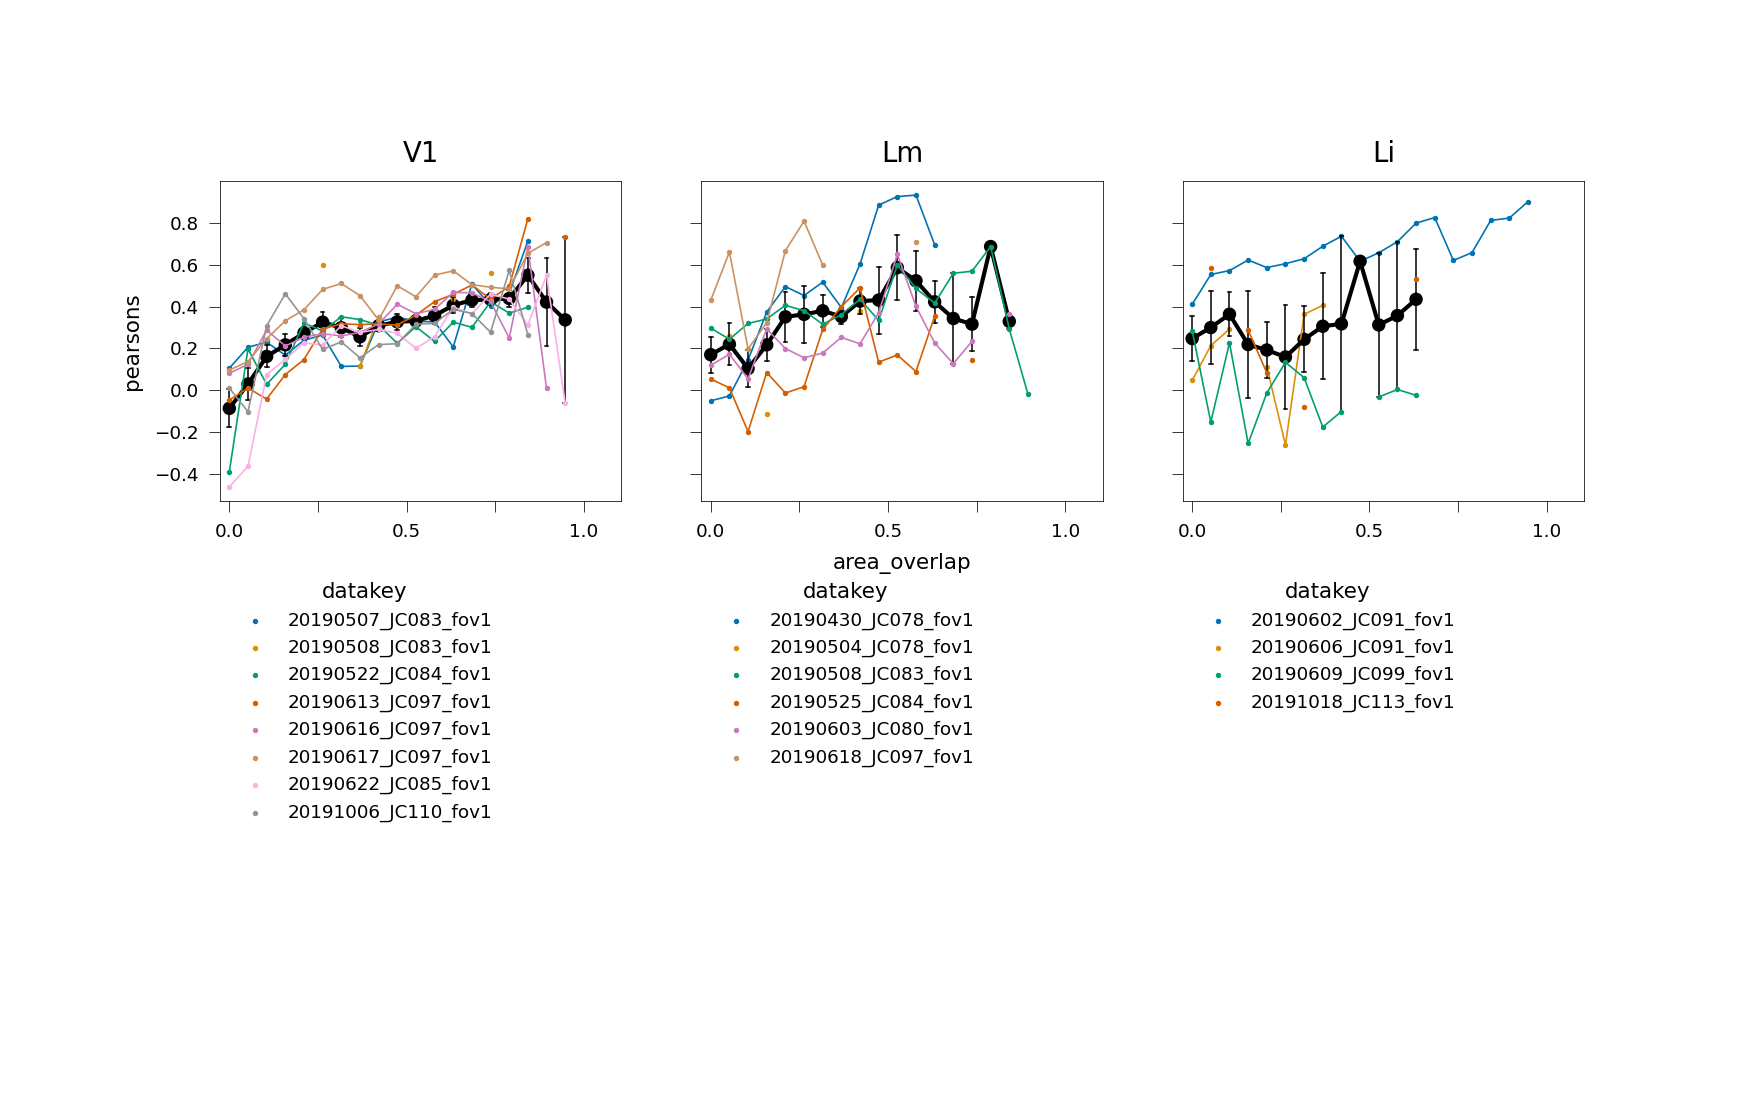

In [69]:
x_var = 'area_overlap'
y_var = 'pearsons'

#curr_plotdf = currcorrs[currcorrs['visual_area']=='Li'].copy()
fig, axn =pl.subplots(1,3, sharex=True, sharey=True, figsize=(8, 5))
ax=axn[0]
for va, vg in morph_pos_df.groupby('visual_area'):

    ax=axn[visual_areas.index(va)]
    sns.pointplot(x='binned_%s' % x_var, y=y_var, hue='datakey',
                data=vg, ax=ax, errorbar=None, #('ci', 95),
                scale=0.2, errwidth=0.5, palette='colorblind')
    sns.move_legend(ax, bbox_to_anchor=(0, -0.2), loc='upper left', frameon=False)
    ax.set_box_aspect(0.75)
    ax.set_title(va)
    ax.set_xlabel('')
    ax.set_ylabel('')
    
# Plot MEAN
for va, vg in corr_means.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    incl_vg = vg[vg['binned_{}'.format(x_var)]<=max_bin_va.loc[va]]
    sns.pointplot(x='binned_%s' % x_var, y=y_var, 
            data=incl_vg, ax=ax, errorbar='se',
            color='k', scale=0.5, errwidth=0.5, capsize=0.2)
    ax.set_zorder(2000)  # Adjust the value as needed
    ax.set_box_aspect(0.8)
    ax.set_ylabel(y_var) if va=='V1' else ax.set_ylabel('')
    ax.set_xlabel(x_var) if va=='Lm' else ax.set_xlabel('')
    
    xlabels = sorted(vg['binned_{}'.format(x_var)].unique())
    xticks = np.linspace(0, len(xlabels)-1, 5)
    xtick_labels = [round(xlabels[int(x)], 1) if i%2==0 or i==len(xticks)-1 
                else "" for i, x in enumerate(xticks)]
    ax.set_xlim([-0.5, np.argmax(xlabels) +2])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels)
# Format
pl.subplots_adjust(bottom=0.5)

figname = 'each_FOV_{}_vs_{}_fovs'.format(x_var, y_var)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))

In [70]:
import analyze2p.utils as hutils

In [404]:
# # dks = ['20190602_JC091_fov1', '20190607_JC091_fov1']
# # dks = ['20190606_JC091_fov1', '20190614_JC091_fov1']
# dks = ['20190609_JC099_fov1', '20190612_JC099_fov1']
# # dks = ['20190322_JC073_fov1']
# fig, axn = pl.subplots(1, 2)
# for ai, dk in enumerate(dks):
#     ax=axn[ai]
#     session, animalid, fov = hutils.split_datakey_str(dk)
#     masks, zimg = roiutils.load_roi_masks(animalid, session, fov, rois='rois001',
#                                           rootdir=rootdir)
#     surface_2p = pplot.adjust_image_contrast(zimg, clip_limit=3.0, tile_size=5)
#     #ax.imshow(surface_2p, cmap='gray')
#     ax.imshow(surface_2p)

In [72]:
mono_cdict = dict((k, [0.5]*3) for k in morph_pos_df['datakey'].unique())

In [83]:
import math
n = 5
r = 2
n_combos = math.comb(n, r)
print(n_combos)

10


In [91]:
counts_per_bin = morph_pos_df.groupby(['visual_area', 'datakey', 'binned_{}'.format(x_var)])\
                        ['neuron_pair'].count().reset_index()
enough_nums = counts_per_bin[counts_per_bin['neuron_pair']>=n_combos]

filtered = pd.concat([morph_pos_df[(morph_pos_df['visual_area']==va)
                & (morph_pos_df['datakey']==dk)
                & (morph_pos_df['binned_{}'.format(x_var)]==bn)] \
            for (va, dk, bn), d_ in enough_nums\
            .groupby(['visual_area', 'datakey', 'binned_{}'.format(x_var)])])
# mean
dk_means = morph_pos_df.groupby(['visual_area', 'datakey', \
                                 'binned_{}'.format(x_var)]).mean().reset_index()
n_dks_per_bin = dk_means.groupby(['visual_area', 'binned_{}'.format(x_var)]).count().reset_index()
max_bin_va = n_dks_per_bin[n_dks_per_bin[x_var]>=2]\
                .groupby('visual_area')['binned_{}'.format(x_var)].max()

<IPython.core.display.Javascript object>


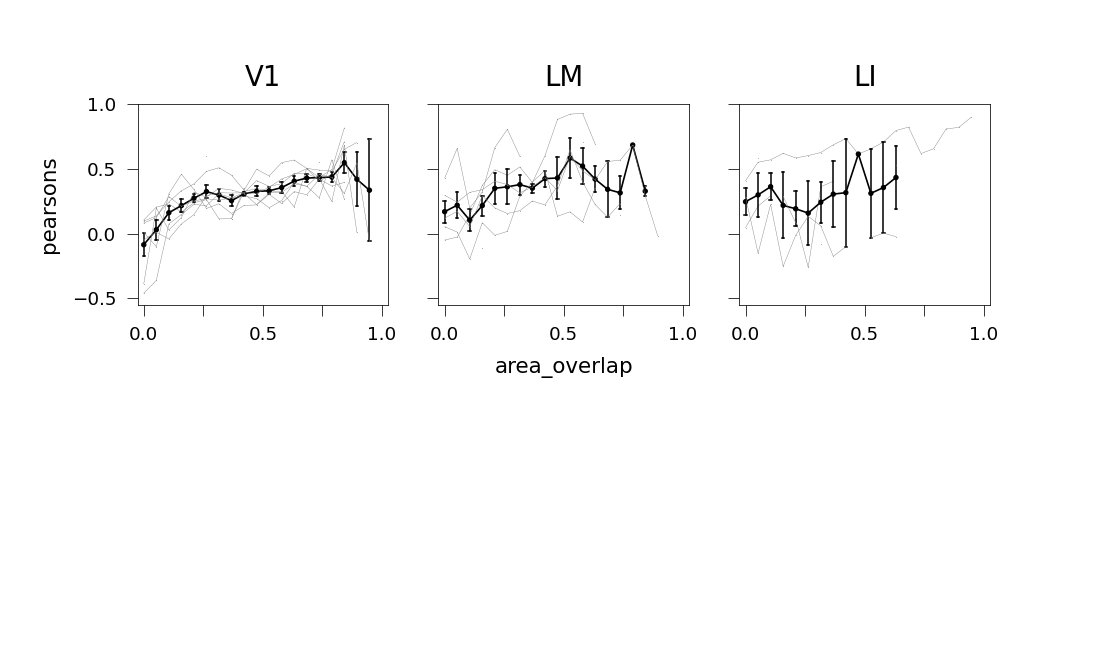

In [105]:
# x_var = 'cortical_distance'
# y_var = 'pearsons'

#curr_plotdf = currcorrs[currcorrs['visual_area']=='Li'].copy()
fig, axn =pl.subplots(1,3, sharex=True, sharey=True, figsize=(5, 3))
ax=axn[0]

for va, vg in morph_pos_df.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    sns.pointplot(x='binned_%s' % x_var, y=y_var, hue='datakey',
                data=vg, ax=ax,  palette=mono_cdict, errorbar=None, #('ci', 95),
                scale=0.05, markers='.', errwidth=0.25)
    ax.legend_.remove() #sns.move_legend(ax, bbox_to_anchor=(0, -0.2), loc='upper left', frameon=False)
    ax.set_box_aspect(0.8)
    ax.set_title(va.upper())
    ax.set_xlabel('')
    ax.set_ylabel('')
    
# Plot MEAN
dk_means = morph_pos_df.groupby(['visual_area', 'datakey', \
                                 'binned_{}'.format(x_var)]).mean().reset_index()
for va, vg in dk_means.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
#     mean = vg.groupby('binned_cortical_distance').mean().reset_index()
#     sem = vg.groupby('binned_cortical_distance').sem().reset_index()
#     ax.plot(mean['binned_%s' % x_var].index.tolist(), mean[y_var], lw=0.5, color=area_colors[va])
#     ax.errorbar(mean['binned_%s' % x_var].index.tolist(), mean[y_var],
#                 yerr=sem[y_var])
    incl_vg = vg[vg['binned_{}'.format(x_var)]<=max_bin_va.loc[va]]
    sns.pointplot(x='binned_%s' % x_var, y=y_var, 
            data=incl_vg, ax=ax, errorbar='se',
            color='k', scale=0.2, errwidth=0.5, capsize=0.2)
    
    ax.set_zorder(2000)  # Adjust the value as needed
    ax.set_box_aspect(0.8)
    ax.set_ylabel(y_var) if va == 'V1' else ax.set_ylabel('')
    ax.set_xlabel(x_var) if va=='Lm' else ax.set_xlabel('')

    xlabels = sorted(vg['binned_{}'.format(x_var)].unique())
    xticks = np.linspace(0, len(xlabels)-1, 5)
    xtick_labels = [round(xlabels[int(x)], 1) if i%2==0 or i==len(xticks)-1 
                else "" for i, x in enumerate(xticks)]
    ax.set_xlim([-0.5, np.argmax(xlabels) +0.5])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels)
    ax.set_ylim([-0.55, 1])

# Format
pl.subplots_adjust(bottom=0.5)

figname = 'each_FOV_{}_vs_{}_mono_no-err'.format(x_var, y_var)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))

In [97]:
FIGDIR

'/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/FIGURES/correlate_tuning_curves_MIGR/blobs'

In [98]:
# x_var = 'cortical_distance'
# y_var = 'pearsons'
s_list = []
i=0
for va, vg in morph_pos_df.groupby('visual_area'):
    for d, d_vg in vg.groupby('datakey'):
        X = d_vg[x_var].values
        y = d_vg[y_var].values
        slope, intercept, r_value, p_value, std_err = spstats.linregress(X, y)
        #print('{}: r={:.2f}, p={:.2f}'.format(d, r_value, p_value))
        stat = pd.DataFrame({'visual_area': va, 'datakey': d,
                      'slope': slope,
                      'intercept': intercept,
                      'pearson_r': r_value,
                      'p_value': p_value,
                      'std_err': std_err}, index=[i])
        s_list.append(stat)
        i+=1
statdf = pd.concat(s_list)

In [99]:
from itertools import combinations
import statsmodels.stats.multitest as smm

In [100]:
stat_var = 'slope'
#perform Kolmogorov-Smirnov test
results = {}
groups = ['V1', 'Lm', 'Li']
k_ = []
for group1, group2 in combinations(groups, 2):
    ks_stat, p_value = spstats.mannwhitneyu(
                statdf[statdf['visual_area']==group1][stat_var], 
                statdf[statdf['visual_area']==group2][stat_var],
                alternative='greater')
    results[f"{group1} vs {group2}"] = (ks_stat, p_value)

# Apply Bonferroni correction
adjusted_p_values = smm.multipletests([r[1] for r in 
                                       results.values()], method='fdr_bh')[1]
# Print results
for (comparison, (ks_stat, p)), adj_p in zip(results.items(), adjusted_p_values):
    print(f"{comparison}: KS-stat = {ks_stat:.2f}, p = {p:.2f}, adjusted p = {adj_p:.2e}")
    ks = pd.DataFrame({'comparison': comparison,
                 'ks_stat': ks_stat,
                 'p': p,
                 'adjusted_p': adj_p}, index=[i])
    i+=1
    k_.append(ks)
sigdf = pd.concat(k_).reset_index(drop=True)
sigdf['A'] = [c.split(' ')[0] for c in sigdf['comparison']]
sigdf['B'] = [c.split(' ')[-1] for c in sigdf['comparison']]
sigdf

V1 vs Lm: KS-stat = 16.00, p = 0.86, adjusted p = 8.59e-01
V1 vs Li: KS-stat = 20.00, p = 0.28, adjusted p = 4.27e-01
Lm vs Li: KS-stat = 17.00, p = 0.18, adjusted p = 4.27e-01


comparison  ks_stat         p  adjusted_p   A   B
0   V1 vs Lm     16.0  0.858808    0.858808  V1  Lm
1   V1 vs Li     20.0  0.284848    0.427273  V1  Li
2   Lm vs Li     17.0  0.176190    0.427273  Lm  Li

<IPython.core.display.Javascript object>


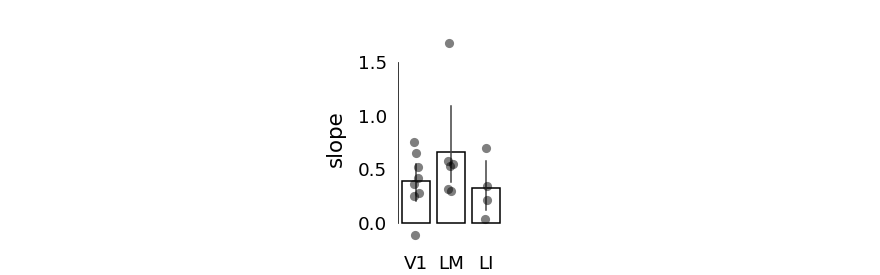

In [107]:
fig, ax = pl.subplots( figsize=(4,1.25))
yv = 'slope'

sns.barplot(statdf, x='visual_area', y=yv,ax=ax,
              order=visual_areas, edgecolor='k', facecolor='none',
            errwidth=0.5, linewidth=0.5)
sns.stripplot(statdf, x='visual_area', y=yv,ax=ax,
              order=visual_areas, color='k', s=3, #hue='p_color', palette=p_cdict, size=3,
              alpha=0.5)
ax.set_box_aspect(2)
pplot.annotate_multicomp_by_area(ax, sigdf,p_var='adjusted_p',
                                 offset=0.0002)
ax.tick_params(length=0)
ax.set_xlabel('')
ax.set_xticklabels(['V1', 'LM', 'LI'])
sns.despine(trim=True, bottom=True)

pl.subplots_adjust(right=0.9, wspace=0.5)


figname = 'each_FOV_{}_vs_{}_stats'.format(x_var, y_var)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))

In [413]:
sigdf

comparison  ks_stat         p  adjusted_p   A   B
0   V1 vs Lm     27.0  0.696766    0.696766  V1  Lm
1   V1 vs Li     28.0  0.074126    0.111189  V1  Li
2   Lm vs Li     24.0  0.036364    0.109091  Lm  Li

In [102]:
FIGDIR

'/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/FIGURES/correlate_tuning_curves_MIGR/blobs'

In [24]:
cc_outfile = os.path.join(dst_dir, 'ccdist.pkl')
with open(cc_outfile, 'wb') as f:
    pkl.dump(f, cc_outfile)
    

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/results_ROC_minsub-none_rfs-dff-uncorr.pkl


In [26]:
importlib.reload(pplot)

<module 'analyze2p.plotting' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/plotting.py'>

#### Average signal/noise ccs. by FOV

<IPython.core.display.Javascript object>


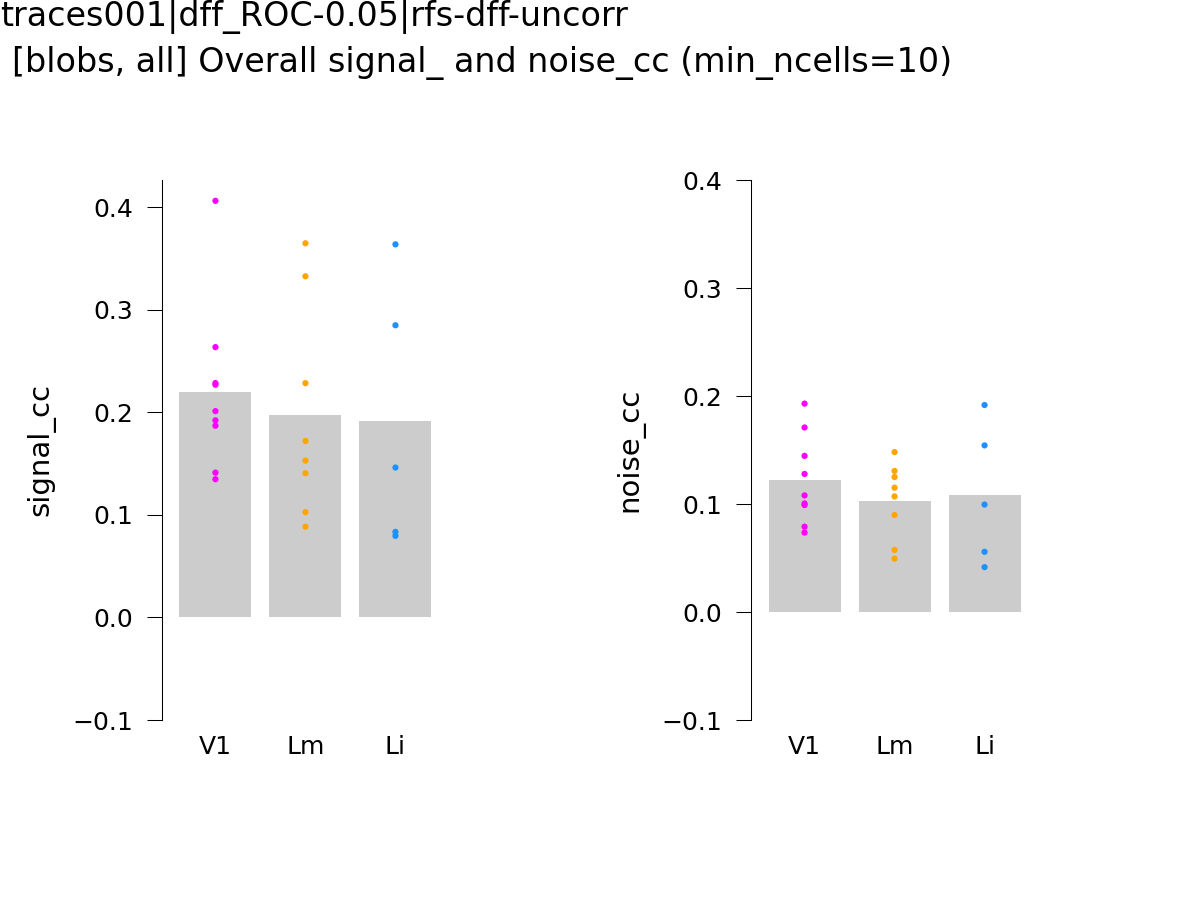

0
1
    A   B  p-unc  p-corr p-adjust     metric
0  V1  Lm   0.42     1.0   fdr_by  signal_cc
1  V1  Li   0.61     1.0   fdr_by  signal_cc
2  Lm  Li   0.62     1.0   fdr_by  signal_cc
0  V1  Lm   0.54     1.0   fdr_by   noise_cc
1  V1  Li   0.61     1.0   fdr_by   noise_cc
2  Lm  Li   1.00     1.0   fdr_by   noise_cc


In [49]:
%matplotlib notebook
ymin, ymax = [-0.1, 0.4]
posthoc='fdr_by'
corrs_fov = CORRS.groupby(['visual_area', 'datakey']).median().reset_index()
fig, axn =pl.subplots(1, 2, figsize=(4,3), dpi=150, sharey=False)
stat_list=[]
for ci, metric in enumerate(['signal_cc', 'noise_cc']):
    ax=axn[ci]
    print(ci)
    ax, stats_ = pplot.stripplot_metric_by_area(corrs_fov, metric=metric, ax=ax,
                markersize=3,area_colors=area_colors,mean_style='bar', 
                posthoc=posthoc, return_stats=True,
                mean_type='mean', y_loc=0.3, jitter=False, aspect=2)

    stats_['metric'] = metric
    stat_list.append(stats_)
    ax.set_yticks(np.linspace(ymin, ymax, 6))
fig.text(0.01, 0.92, '[%s, %s] Overall signal_ and noise_cc (min_ncells=%i)' 
         % (experiment, select_stimuli, min_ncells), fontsize=8)

statsdf_cc = pd.concat(stat_list, axis=0)

pplot.label_figure(fig, data_id)
figname = 'overall_sig_and_noise_cc_byFOV' 
# pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(statsdf_cc.round(2))


In [65]:
7.1/2.5

2.84

In [306]:
import analyze2p.utils as util

In [40]:
curr_lim = 15
very_close = DISTS[DISTS['cortical_distance']<curr_lim].copy()
very_close

xcorr_morph  pearsons_morph  cosim_morph  cell_1  cell_2 neuron_pair  \
252        2.587239        0.612241     0.923448     266     329     266_329   
492        5.690129        0.981396     0.999123      15      16       15_16   
987        4.658047        0.185048     0.961345      27      28       27_28   
1066       5.197616        0.922606     0.995552      28      29       28_29   
1519       3.709380        0.860889     0.980382      38      39       38_39   
...             ...             ...          ...     ...     ...         ...   
133482     5.063604        0.871614     0.993080     103     104     103_104   
134437     3.224277        0.466076     0.921594     170     182     170_182   
135066     5.223506        0.781897     0.990032     240     242     240_242   
135352     3.542522        0.525248     0.955802     285     298     285_298   
135404     4.180847       -0.216185     0.898241     301     364     301_364   

        xcorr_size  pearsons_size  cosim_size  max_response  ...  \
252       1.682026       0.941864    0.974186      0.000990  ...   
492       1.927878       0.979531    0.990862      0.031955  ...   
987       1.490198      -0.206089    0.739619      0.049804  ...   
1066      1.815851       0.984414    0.992678      0.056536  ...   
1519      2.111788       0.803391    0.951836      0.065982  ...   
...            ...            ...         ...           ...  ...   
133482    1.563895       0.894929    0.963833      0.180326  ...   
134437    1.658808      -0.679637    0.797383      0.040804  ...   
135066    1.557803       0.969992    0.987821      0.326497  ...   
135352    2.162529       0.874967    0.983723      0.023925  ...   
135404    2.126892       0.989548    0.956589      0.036029  ...   

        rf_angle_diff_abs     std_x     std_y  aspect_ratio  area_overlap  \
252                   NaN       NaN       NaN           NaN           NaN   
492              4.403186  4.711111  2.646786      0.072537      0.553561   
987                   NaN       NaN       NaN           NaN           NaN   
1066                  NaN       NaN       NaN           NaN           NaN   
1519             6.760472  1.853583  3.759288      0.270798      0.768286   
...                   ...       ...       ...           ...           ...   
133482          13.892440  1.120980  1.181104      0.120081      0.655717   
134437                NaN       NaN       NaN           NaN           NaN   
135066                NaN       NaN       NaN           NaN           NaN   
135352                NaN       NaN       NaN           NaN           NaN   
135404                NaN       NaN       NaN           NaN           NaN   

        perc_overlap  overlap_index  visual_area              datakey  n_cells  
252              NaN            NaN           Li  20190422_JC076_fov1       29  
492         0.999294       0.446439           Li  20190602_JC091_fov1       87  
987              NaN            NaN           Li  20190602_JC091_fov1       87  
1066             NaN            NaN           Li  20190602_JC091_fov1       87  
1519        0.957930       0.231714           Li  20190602_JC091_fov1       87  
...              ...            ...          ...                  ...      ...  
133482      0.905315       0.344283           V1  20191006_JC110_fov1       86  
134437           NaN            NaN           V1  20191006_JC110_fov1       86  
135066           NaN            NaN           V1  20191006_JC110_fov1       86  
135352           NaN            NaN           V1  20191006_JC110_fov1       86  
135404           NaN            NaN           V1  20191006_JC110_fov1       86  

[98 rows x 25 columns]

In [35]:
import analyze2p.utils as util

In [43]:
dk = '20191006_JC110_fov1'
session, animalid, fov = util.split_datakey_str(dk)
masks, zimg = roiutils.load_roi_masks(animalid, session, fov, rois='rois001',
                                      rootdir=rootdir)
if masks.min()==0:
    masks[masks==0] = np.nan
print(masks.shape)

(391, 512, 512)


In [44]:
%matplotlib notebook

<IPython.core.display.Javascript object>


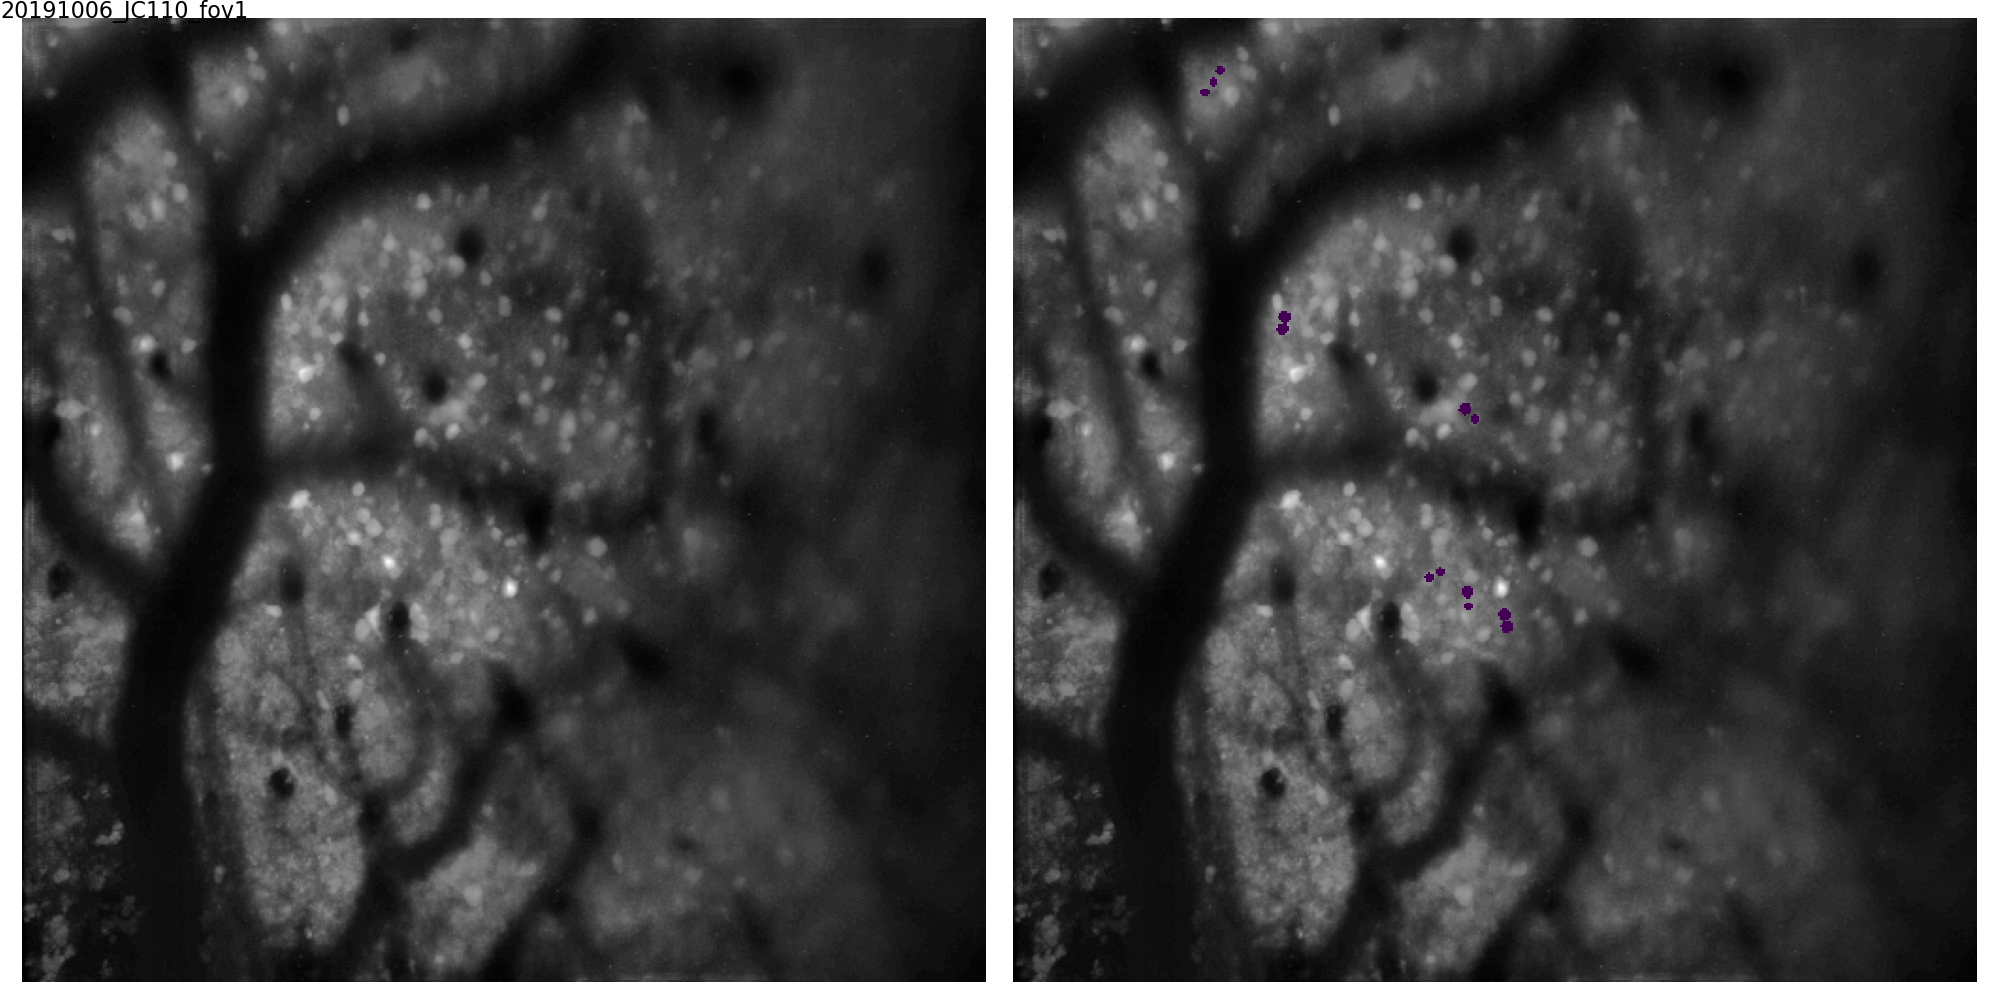

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/FIGURES/correlate_tuning_curves_MIGR example-nearby-cells_less-than-15_20191006_JC110_fov1


In [46]:
fig, axn = pl.subplots(1, 2, figsize=(10,5))
for ax in axn:
    surface_2p = pplot.adjust_image_contrast(zimg, clip_limit=5.0, tile_size=5)
    ax.imshow(surface_2p, cmap='gray')
    ax.axis('off')
# r1 = rois[0] #rois = [57, 67]
for i, v in very_close[very_close['datakey']==dk].iterrows():
    rois = v[['cell_1', 'cell_2']]
    for roi in rois:
        im = masks[roi, :, :].copy()
        msk = np.ma.masked_where( np.isnan(im), im)
        ax.imshow(msk)
pl.tight_layout()

pplot.label_figure(fig, dk)
figname = 'example-nearby-cells_less-than-{}_{}'.format(curr_lim, dk)
pl.savefig(os.path.join(FIGDIR, '{}.png'.format(figname)))
print(FIGDIR, figname)

#### Distance as a function of signal/noise cc

<IPython.core.display.Javascript object>


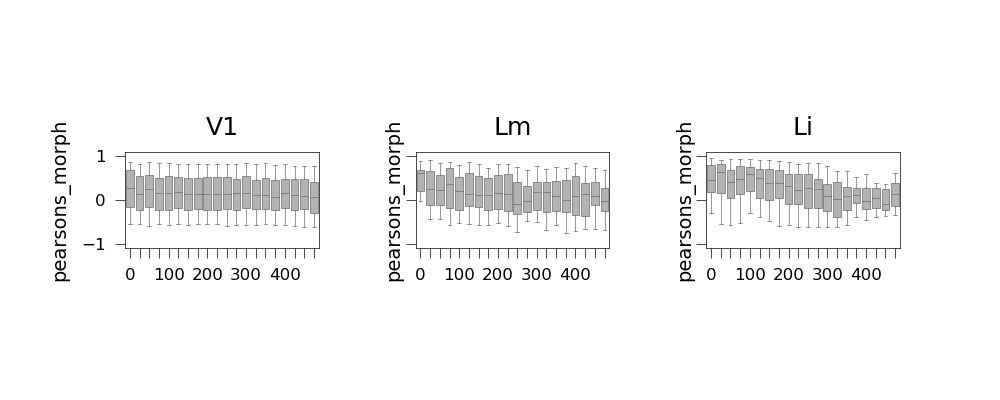

NameError: name 'select_stimuli' is not defined

In [51]:
%matplotlib notebook
ctx_maxdist = 500
df = DISTS[(DISTS.cortical_distance<=ctx_maxdist)
          ].copy().dropna()
# Cut bins
df, dist_lut = cr.get_bins_and_cut(df, ctx_step=25, rf_step=2, 
                                   dir_step=30, ori_step=15)
# ------------------------------------------------------------
# metric_vars = ['signal_cc', 'noise_cc']
metric_vars = ['pearsons_morph']
x_var = 'cortical_distance'
fig, axn =pl.subplots(len(metric_vars), 3,figsize=(5,2), dpi=100, sharex=True, sharey=True)
for vi, (va, v_df) in enumerate(df.groupby('visual_area')):
    ci = visual_areas.index(va)
    for ri, y_var in enumerate(metric_vars):
        #x_bins = dist_lut[dist_var]['bins']
        x_bins = sorted(v_df['binned_%s' % x_var].unique())
        xticks=np.arange(0, len(x_bins))
        ax=axn[ri, ci] if len(metric_vars)>1 else axn[ci]
        if ri==0:
            ax.set_title(va)
        sns.boxplot(y='{}'.format(y_var), x='binned_{}'.format(x_var),
                    data=v_df, ax=ax, color=[0.7]*3, linewidth=0.25,
                    fliersize=0, whis=(5, 95))
#                 errwidth=0.5)
#         sns.stripplot(x='%s_label' % x_var, y=y_var, data=df, ax=ax, 
#                       s=1, alpha=0.5, color='k')
        ax.set_xticks(xticks)
        ax.set_xticklabels([int(round(x_bins[i], 1)) if i in xticks[0::4] else ''
                           for i in xticks])
        ax.set_box_aspect(0.5)
for ax in axn.flat:
    ax.set_xlabel('')
pl.subplots_adjust(bottom=0.2, right=0.9, wspace=0.5, hspace=0.3, top=0.8)
fig.text(0.01, 0.92, '[%s, %s] Avg. distance metrics (max_dist=%i um)' 
         % (experiment, select_stimuli, ctx_maxdist), fontsize=8)
pplot.label_figure(fig, data_id)

#### Binned distance, compare SIGNAL_CC (and shuffle)

In [32]:
ctx_maxdist = 500
y_var='signal_cc'
dist_var='cortical_distance'
cmap='viridis'
tuned_or_resp = 'responsive'
# ----------------------------------
df = CORRS[(CORRS.cortical_distance<=ctx_maxdist)].copy().dropna()
# Cut bins
df, dist_lut = cr.get_bins_and_cut(df, ctx_step=25, rf_step=2, 
                                   dir_step=30, ori_step=15)
# Shuffle
combined_ = cr.shuffle_bins_by_area(df, dist_var=dist_var, n_iterations=100)

# Plot shuffled to check
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, 
                   data=combined_[combined_.condition=='shuffled'])
fg.map(sns.barplot, '%s_label' % dist_var, 'signal_cc' , ci='sd')
pl.subplots_adjust(bottom=0.2, right=0.8)

100.0


<IPython.core.display.Javascript object>


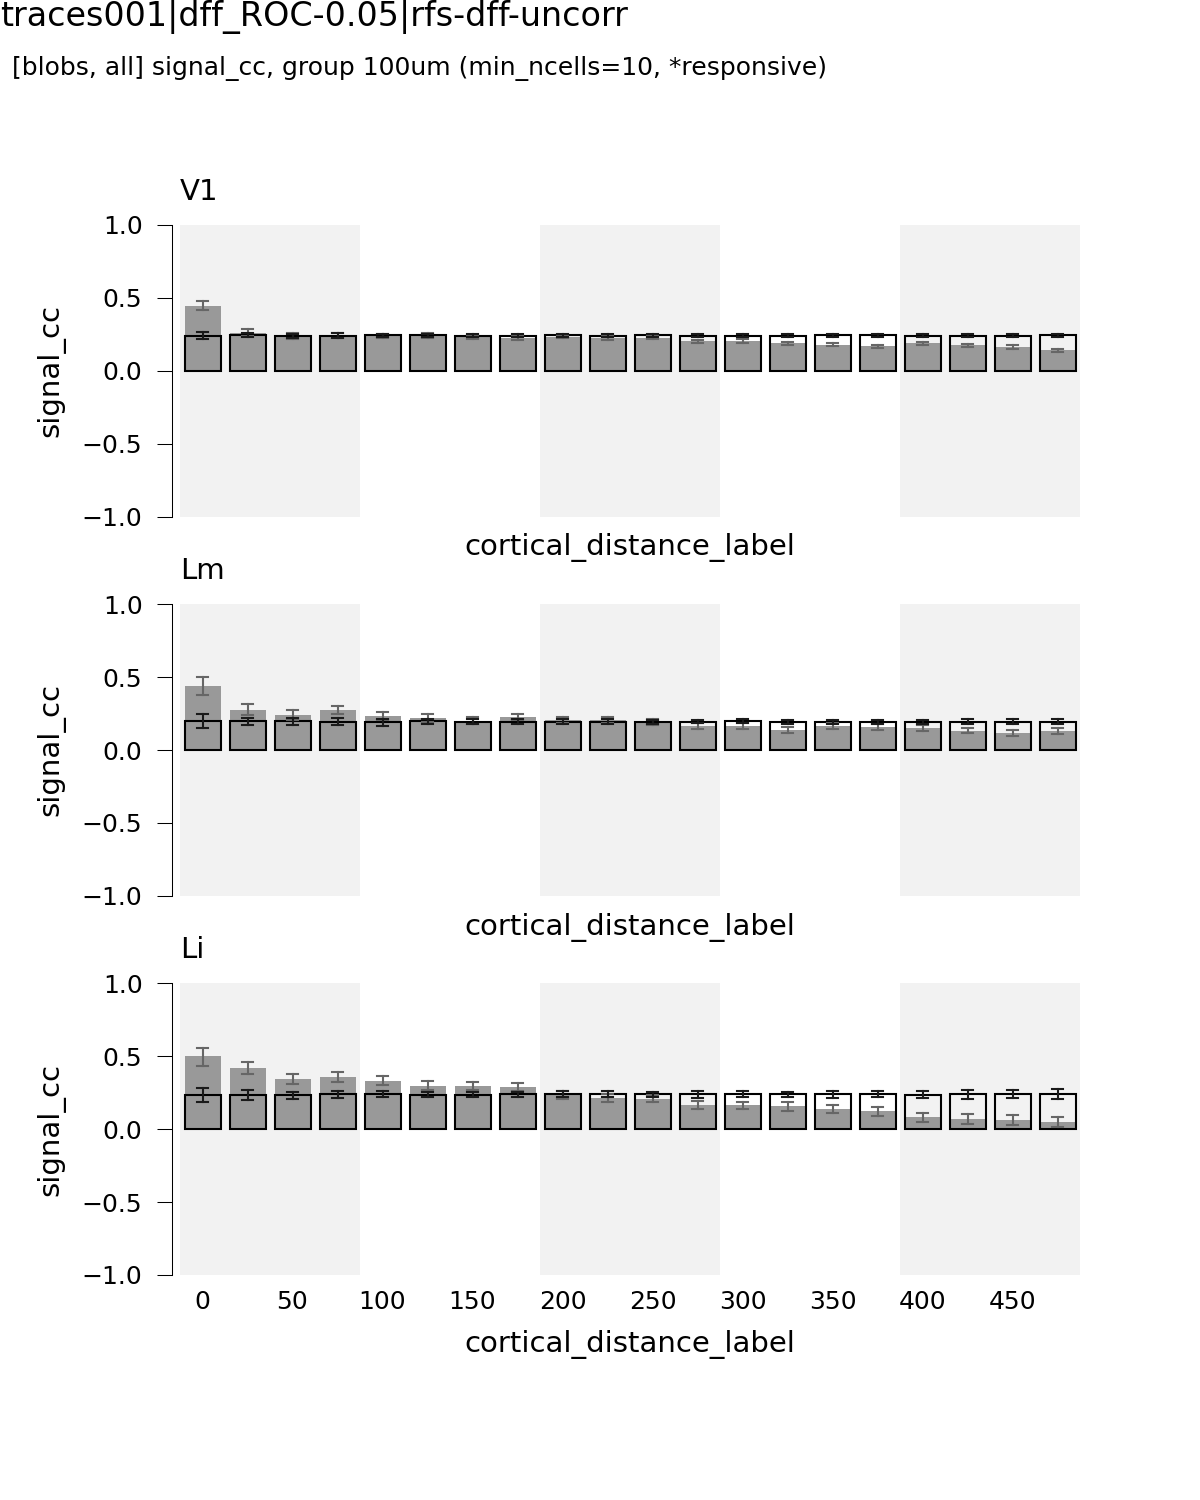

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/ROC_minsub-none_rfs-dff-uncorr binned-dist-bar_signal_cc_v_cortical_distance_responsive_max500


In [215]:
dist_unit='um'
curr_maxdist = dist_lut[dist_var]['max_dist']
plot_pairs=False
# curr_maxdist=60 if dist_var=='rf_distance' else 500
plot_str = '_wpairs' if plot_pairs else ''
sorted_x_vars =  dist_lut[dist_var]['bins']
bin_width = 4 if dist_var=='cortical_distance' else 5
patch_step = sorted_x_vars[bin_width] #+dist_lut[dist_var]['step']
print(patch_step)
%matplotlib notebook
fig = cr.barplot_with_shuffled_distbins(combined_, dist_var, y_var,
                     curr_maxdist=curr_maxdist, round_x=0, dist_unit=dist_unit,
                     barcolor=[0.6]*3, errcolor=[0.4]*3, errcolor_shuffled=[0.1]*3,
                     plot_pairs=plot_pairs,figsize=(4,5),
                     draw_group_patch=True, bin_width=bin_width)
sns.despine(bottom=True, trim=True, offset=2)
pl.subplots_adjust(left=0.15, right=0.9, bottom=0.15, top=0.85, hspace=0.3)
fig.text(0.01, 0.95, "[%s, %s] %s, group %i%s (min_ncells=%i, *%s)" \
         % (experiment, select_stimuli, y_var, \
            patch_step, dist_unit, min_ncells, tuned_or_resp))

pplot.label_figure(fig, data_id)
figname = 'binned-dist-bar_%s_v_%s_%s_max%i%s' \
            % (y_var, dist_var, tuned_or_resp, curr_maxdist, plot_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))

print(dst_dir, figname)

In [216]:
far_bins

[]

In [220]:
plotd = combined_[(combined_.condition=='data') 
                & (combined_.cortical_distance<=curr_maxdist)]
# y_var='signal_cc'
print(y_var, dist_var)
near_lim = (0, 50)
upper_lim = (50, 150)

near_bins = [b for b in dist_lut[dist_var]['bins'] if near_lim[0]<=b<near_lim[1]]
far_bins = [b for b in dist_lut[dist_var]['bins'] \
           if (b>=upper_lim[0]) and (b<upper_lim[1])]
print("NEAR:", near_bins)
print("FAR:", far_bins)

col1='r' #[0.3]*3
col2='b' #[0.8]*3
curr_dist_colors = dict((k, v) for k, v in zip(['near', 'far'], [col1, col2]))

v1df = plotd[plotd['%s_label' % dist_var].isin(near_bins)]\
            [['visual_area', dist_var, '%s_label' % dist_var, y_var, 'neuron_pair']].copy()
v2df = plotd[plotd['%s_label' % dist_var].isin(far_bins)]\
            [['visual_area', dist_var, '%s_label' % dist_var, y_var, 'neuron_pair']].copy()
print(len(v1df), len(v2df))
v1df['distance_cond'] = 'near'
v2df['distance_cond'] = 'far'

dist_df = pd.concat([v1df, v2df], axis=0, ignore_index=True)


signal_cc cortical_distance
NEAR: [0.0, 25.0]
FAR: [50.0, 75.0, 100.0, 125.0]
2247 11129


<IPython.core.display.Javascript object>


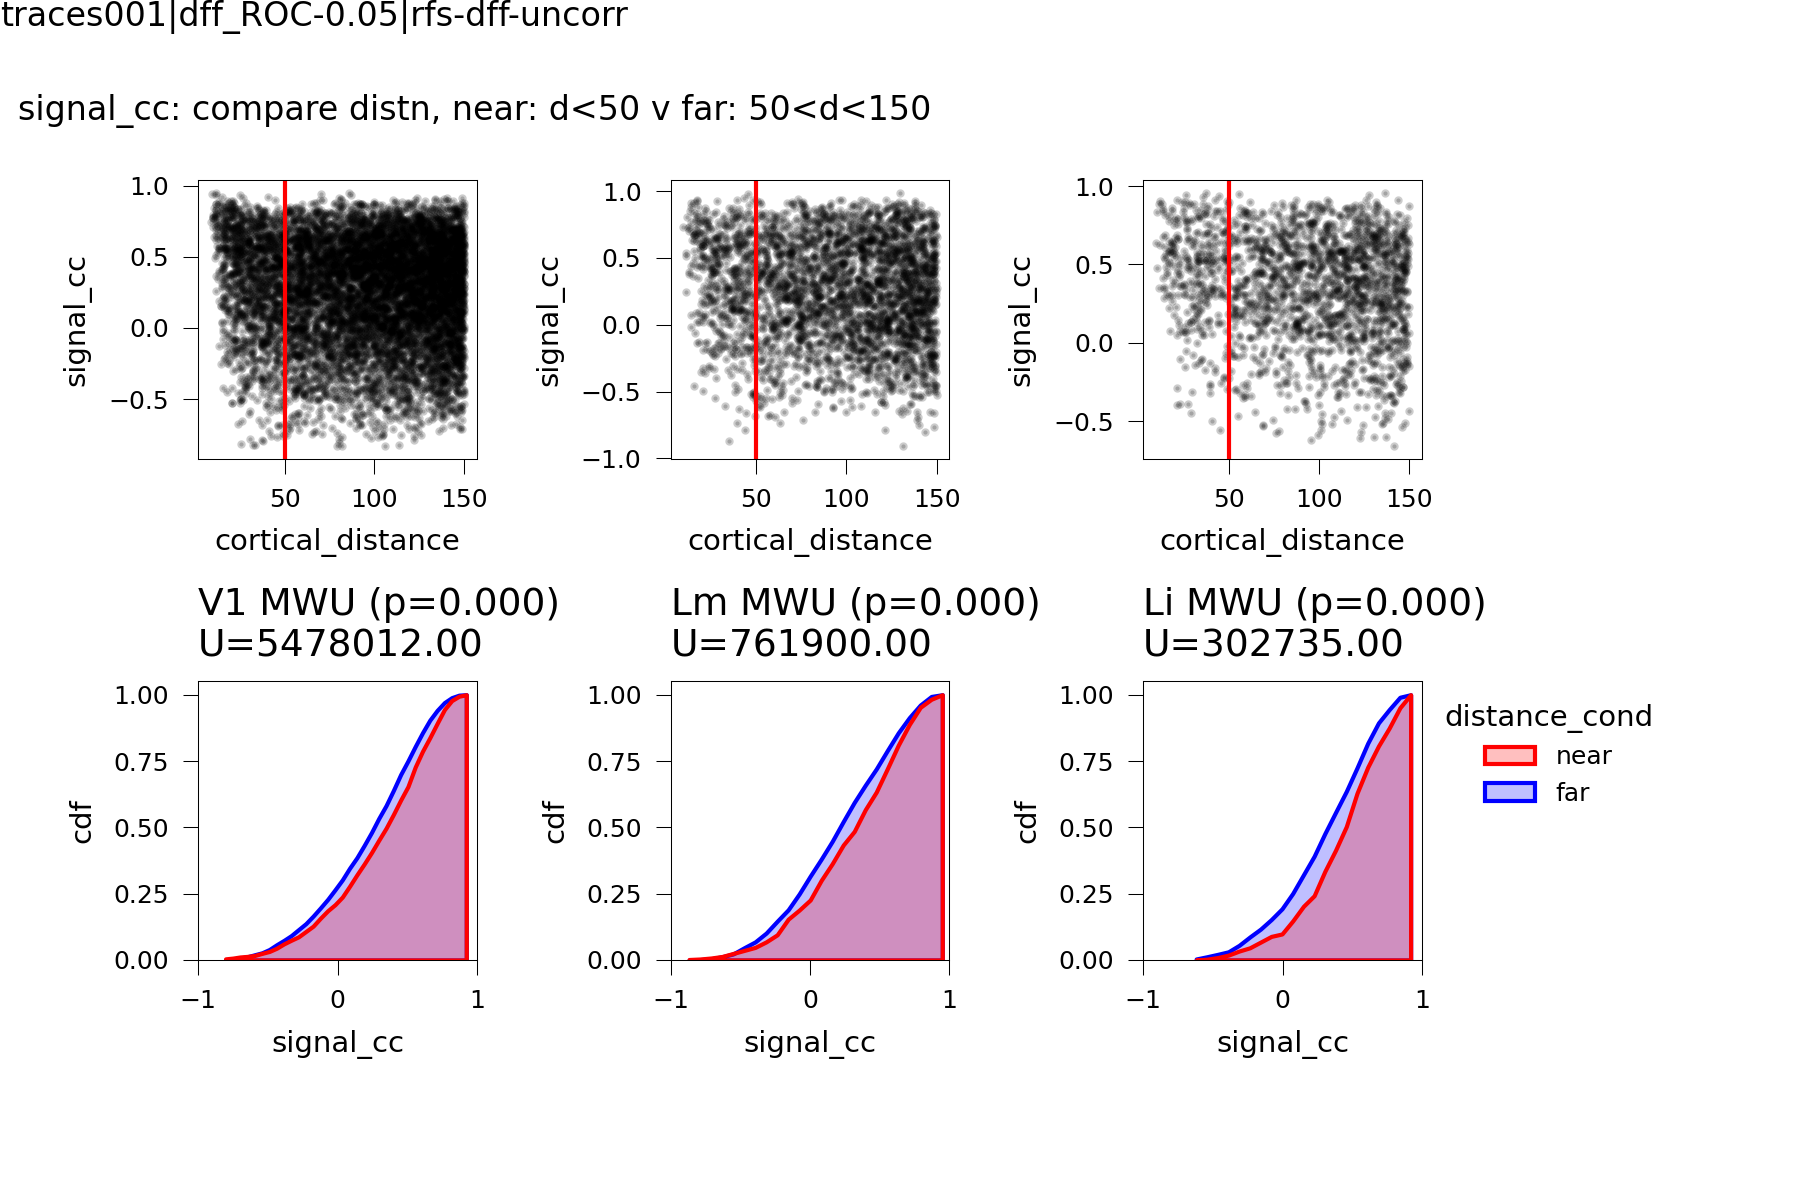

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/ROC_minsub-none_rfs-dff-uncorr compare-bins_near50_far50_signal_cc_v_cortical_distance_responsive_max500


In [223]:
fig, axn = pl.subplots(2, 3, sharex=False, sharey=False, figsize=(6,4), dpi=150)
for va, vg in dist_df.groupby('visual_area'):
    ax=axn[0, visual_areas.index(va)]
    ax.scatter(x=dist_var, y=y_var, data=vg, s=1, color='k', alpha=0.2)
    ax.set_xlabel(dist_var)
    ax.set_ylabel(y_var)
    ax.axvline(x=near_lim[-1], color='r', ls='-', lw=1)
    
    ax=axn[1, visual_areas.index(va)]
    sns.histplot(x=y_var, data=vg, hue='distance_cond', ax=ax,
                 palette=curr_dist_colors, cumulative=True, common_norm=False,
                stat='probability', element='poly', lw=1)
    if va=='Li':
        pplot.sns_histplot_legend(ax, bbox_to_anchor=(1,1), loc='upper left',
                  frameon=False)
    else:
        ax.legend_.remove()
    ax.set_xlim([-1, 1])
    v1 = vg[vg.distance_cond=='near'][y_var].values
    v2 = vg[vg.distance_cond=='far'][y_var].values
    U, p = spstats.mannwhitneyu(x=v1, y=v2, alternative = 'two-sided')
    ax.set_ylabel('cdf')
    ax.set_title('%s MWU (p=%.3f)\nU=%.2f' % (va, p, U), loc='left')
for ax in axn.flat:
    ax.set_box_aspect(1)
pl.subplots_adjust(wspace=0.5, left=0.1, right=0.8, bottom=0.2, top=0.85, 
                   hspace=0.8)
fig.text(0.01, 0.9, '%s: compare distn, near: d<%i v far: %i<d<%i' \
             % (y_var, near_lim[-1], upper_lim[0], upper_lim[-1]), fontsize=8)
pplot.label_figure(fig, data_id)

figname = 'compare-bins_near%i_far%i_%s_v_%s_%s_max%i%s' \
            % (near_lim[-1], upper_lim[0], y_var, dist_var, tuned_or_resp, curr_maxdist, plot_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))
print(dst_dir, figname)

In [180]:
near_bins

[0.0, 25.0]

In [181]:
far_bins

[50.0, 75.0]

In [49]:
curr_maxdist = 250
plotd = combined_[(combined_.condition=='data') 
                & (combined_.cortical_distance<=curr_maxdist)]
# y_var='signal_cc'
print(y_var, dist_var)
near_lim = (10, 50)
mid_lim = (100, 150)
far_lim = (200, 250)
d_list = []
for cond, lims in zip(['near', 'mid', 'far'], [near_lim, mid_lim, far_lim]):
    curr_bins = [b for b in dist_lut[dist_var]['bins'] if lims[0]<=b<lims[1]]
# near_bins = [b for b in dist_lut[dist_var]['bins'] if near_lim[0]<=b<near_lim[1]]
# far_bins = [b for b in dist_lut[dist_var]['bins'] \
#            if (b>=upper_lim[0]) and (b<upper_lim[1])]
    print("bins:", curr_bins)

    currdf = plotd[plotd['%s_label' % dist_var].isin(curr_bins)]\
                [['visual_area', dist_var, '%s_label' % dist_var, y_var, 'neuron_pair']].copy()
    currdf['distance_cond'] = cond
    d_list.append(currdf)
dist_df = pd.concat(d_list, axis=0, ignore_index=True)

signal_cc cortical_distance
bins: [25.0]
bins: [100.0, 125.0]
bins: [200.0, 225.0]


In [50]:
%matplotlib notebook

<IPython.core.display.Javascript object>


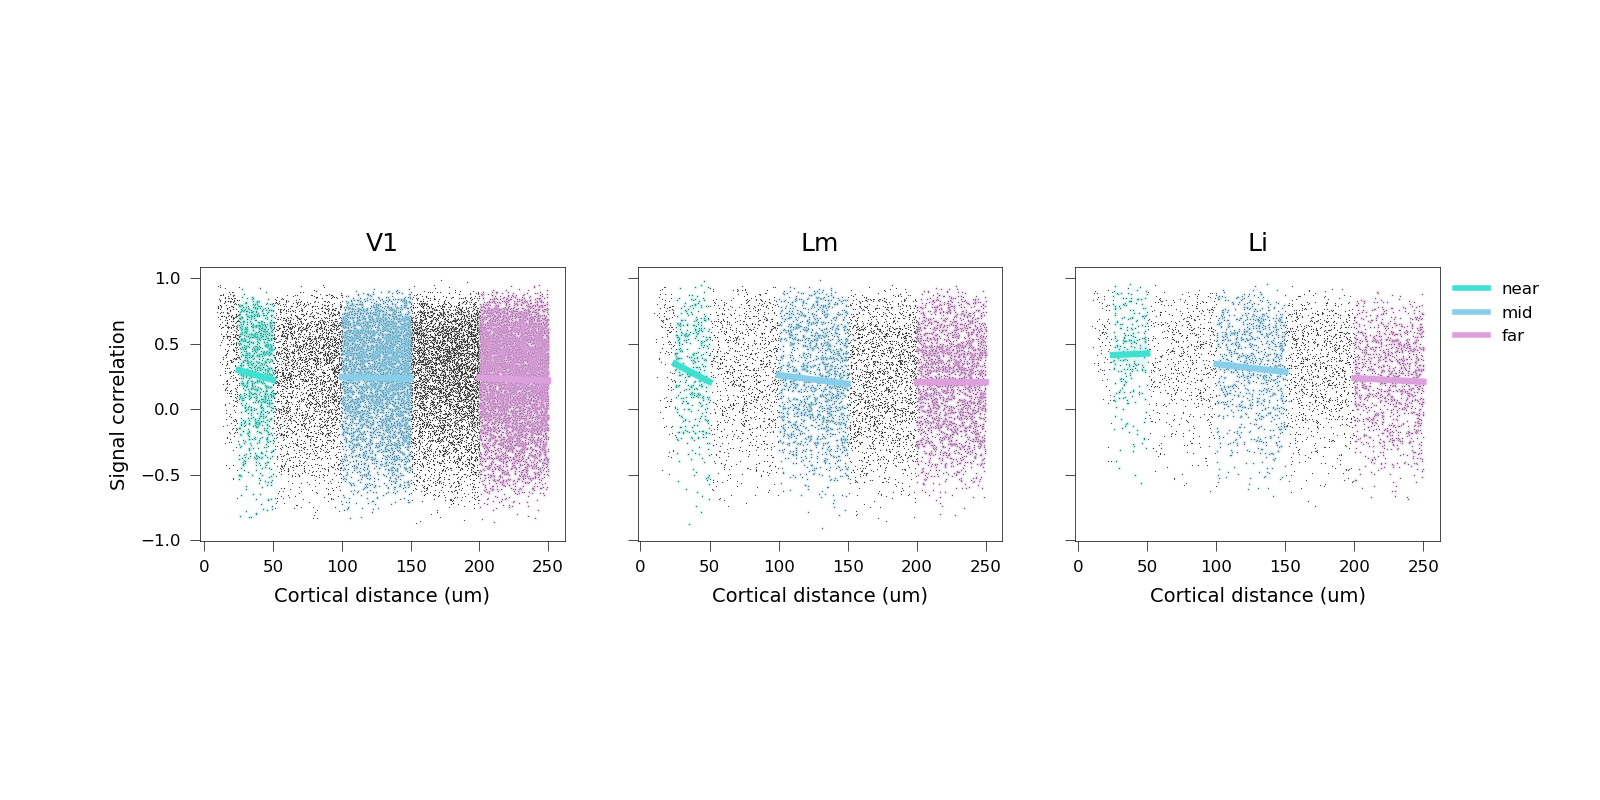

In [51]:
colors = ['turquoise', 'skyblue', 'plum']
distance_conditions = ['near', 'mid', 'far']
curr_dist_colors = dict((k, v) for k, v in zip(distance_conditions, colors))

fig, axn = pl.subplots(1, 3, sharex=False, sharey=True, figsize=(8,4))
i = 0
for vi, (va, vg) in enumerate(dist_df.groupby('visual_area')):
    va_ix = visual_areas.index(va)
    ax_ix = va_ix #*2
    ax=axn[ax_ix]
    #vg = dist_df[dist_df['visual_area']==va].copy()
    sns.scatterplot(x=dist_var, y=y_var, 
                    data=plotd[(plotd['visual_area']==va)
                         & (plotd['%s_label' % dist_var]<far_lim[-1])],
                    color='k', ax=ax, s=0.2, alpha=0.8)
    for cond, cond_df in vg.groupby('distance_cond'):
        sns.regplot(x=dist_var, y=y_var, data=cond_df,
                    color=curr_dist_colors[cond], ax=ax,
                    scatter_kws={'s':0.2, 'alpha': 0.2})
        ax.set_box_aspect(0.75)
        ax.set_title(va)
    ax.set_ylabel('Signal correlation')
    ax.set_xlabel('Cortical distance (um)')
legh = pplot.custom_legend_markers(colors=colors, labels=distance_conditions,
                                   use_patch=False, lws=2, markers='')
axn[-1].legend(handles=legh, bbox_to_anchor=(1, 1), frameon=False)

figname = 'scatter_regr_near_far_cortical_distance'
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))

In [52]:
for cond in distance_conditions:
    for va, vg in dist_df.groupby('visual_area'):
        X = vg[vg['distance_cond']==cond][dist_var].values
        y = vg[vg['distance_cond']==cond][y_var].values
        slope, intercept, r_value, p_value, std_err = spstats.linregress(X, y)
        print('{}. {}: pearson-r={:.3f}, p={:.3f}'.format(cond, va, r_value, p_value)) #, r2))

near. Li: pearson-r=0.010, p=0.874
near. Lm: pearson-r=-0.108, p=0.032
near. V1: pearson-r=-0.057, p=0.070
mid. Li: pearson-r=-0.050, p=0.132
mid. Lm: pearson-r=-0.049, p=0.057
mid. V1: pearson-r=-0.008, p=0.599
far. Li: pearson-r=-0.025, p=0.390
far. Lm: pearson-r=0.001, p=0.970
far. V1: pearson-r=-0.018, p=0.158


In [292]:
xbins = sorted([i for i in dist_lut[dist_var]['bins'] if i<=far_lim[-1]])
xticks = np.arange(0, len(xbins))
xbins

[0.0, 25.0, 50.0, 75.0, 100.0, 125.0, 150.0, 175.0, 200.0, 225.0, 250.0]

<IPython.core.display.Javascript object>


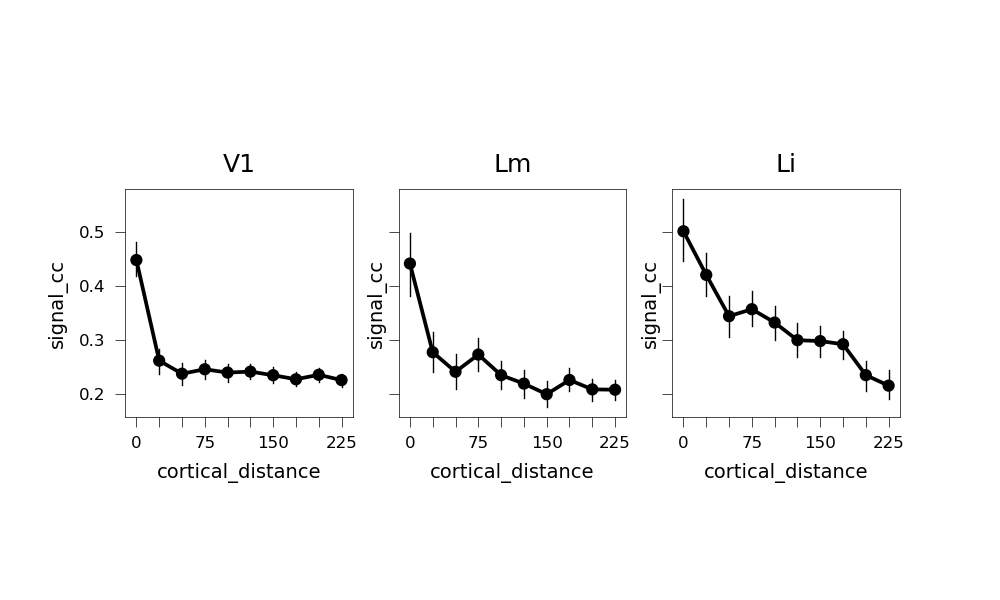

In [296]:
x_var = 'cortical_distance'
y_var = 'signal_cc'
curr_plotdf = plotd[(plotd['%s_label' % dist_var]<far_lim[-1])].copy()
fig, axn =pl.subplots(1,3, sharex=True, sharey=True, figsize=(5,3))
for vi, (va, vg) in enumerate(curr_plotdf.groupby('visual_area')):
    ax=axn[visual_areas.index(va)]
    sns.pointplot(x='%s_label' % x_var, y=y_var, 
                    data=vg, ax=ax, errorbar=('ci', 95),
                    scale=0.5, errwidth=0.5, color='k')
    #x_bins = sorted(curr_plotdf['%s_label' % x_var].unique())
    xticks = ax.get_xticks()
    #ax.set_xticks(xticks-0.5)
    ax.set_xticklabels([int(xbins[i]) if i in xticks[0::3] or i==xticks[-1] \
                        else '' for i in xticks])
    ax.set_box_aspect(1)
    ax.set_xlabel(x_var)
    ax.set_title(va)

In [276]:
ax.get_xticklabels()

[Text(0, 0, '0.0'),
 Text(1, 0, '25.0'),
 Text(2, 0, '50.0'),
 Text(3, 0, '75.0'),
 Text(4, 0, '100.0'),
 Text(5, 0, '125.0'),
 Text(6, 0, '150.0'),
 Text(7, 0, '175.0'),
 Text(8, 0, '200.0'),
 Text(9, 0, '225.0')]

In [124]:
# y_var = 'signal_cc'
df_list = []

for va, vg in dist_df.groupby('visual_area'):
    true_distn=[]
    shuff_distn= []
    for i in np.arange(0, 1000):
        # Boot sample and get TRUE median
        bootd = vg.copy() #sample(frac=1, replace=True)
        med_v = bootd.sample(frac=1, replace=True).groupby(['distance_cond']).median()
        true_val = float(med_v.loc['near'][y_var]) \
                        - float(med_v.loc['far'][y_var])
        true_distn.append(true_val)
        # Shuffle labels
        shuff = vg.copy()
        shuff['distance_cond'] = shuff['distance_cond'].sample(frac=1, replace=False).values
        # Get medians for each group
        med_v_shuff = shuff.groupby(['distance_cond']).median()
        # Calculate diff
        shuff_val = float(med_v_shuff.loc['near'][y_var]) \
                        - float(med_v_shuff.loc['far'][y_var])
        shuff_distn.append(shuff_val)
    
    df_shuff = pd.DataFrame({'near_minus_far': shuff_distn})
    df_shuff['condition'] = 'shuffled'
    df_true = pd.DataFrame({'near_minus_far': true_distn})
    df_true['condition'] = 'true'
    df_ = pd.concat([df_true, df_shuff], axis=0)
    
    df_['visual_area'] = va
    #df_['true_difference'] = true_diff
    df_list.append(df_)

near_v_far = pd.concat(df_list, axis=0, ignore_index=True)

<IPython.core.display.Javascript object>


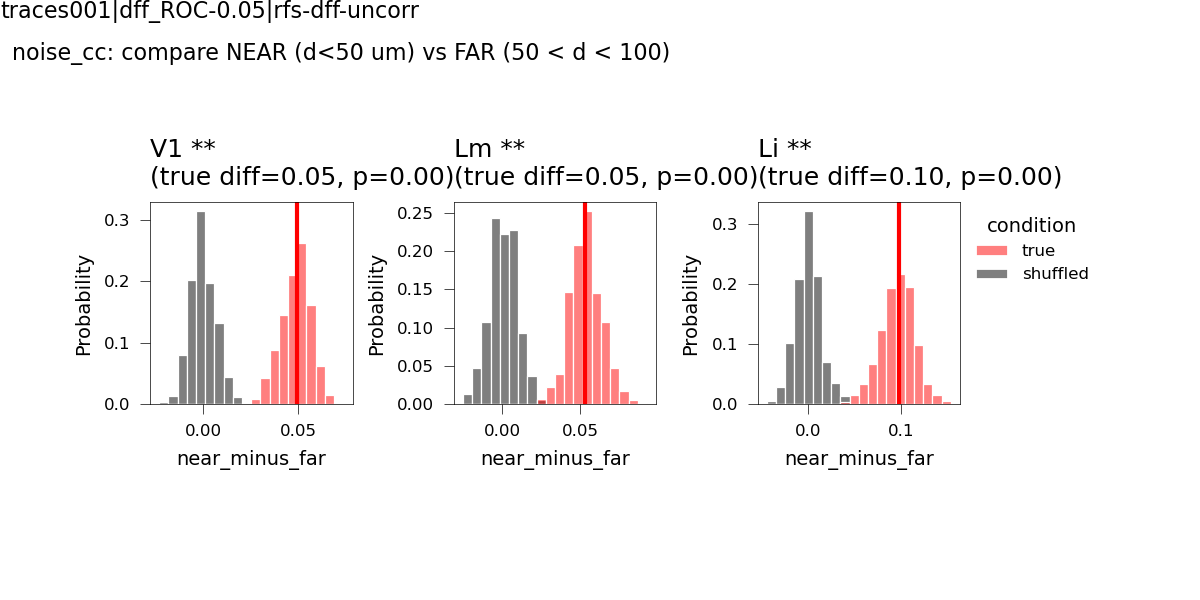

Li 0.0
Lm 0.0
V1 0.0
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/ROC_minsub-none_rfs-dff-uncorr compare-bins_near50_far100_shufftest_noise_cc_v_cortical_distance_responsive_max500


In [125]:

shuff_colors={'true': 'r', 'shuffled': 'k'}
fig, axn = pl.subplots(1, 3, figsize=(6,3))
for va, vg in near_v_far.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    sns.histplot(x='near_minus_far', data=vg,  ax=ax, 
                 bins=20, edgecolor='w', common_bins=True,
                 stat='probability', common_norm=False,
                 hue='condition', palette=shuff_colors)
    # true_ = dist_df[dist_df.visual_area==va].copy()
    #true_diff = float(vg['true_difference'].unique())
    # ax.axvline(x=true_diff, color='r')
    true_diff = float(vg[vg.condition=='true']['near_minus_far'].median())
    shuff_dist = vg[vg.condition=='shuffled']['near_minus_far'].values
    n_extreme = len(np.where(shuff_dist>=true_diff)[0])
    pv = n_extreme/len(shuff_dist)
    sig_str = 'n.s.'
    if pv<0.05:
        sig_str = '**' if p<0.01 else '*'
    print(va, pv)
    ax.axvline(x=true_diff, color='r')
    ax.set_title('%s %s\n(true diff=%.2f, p=%.2f)' % (va, sig_str, true_diff, pv),
                loc='left')
    if va=='Li':
        pplot.sns_histplot_legend(ax, bbox_to_anchor=(1,1), loc='upper left', 
                                  frameon=False)
    else:
        ax.legend_.remove()
    ax.set_box_aspect(1)
    ##ax.set_xlim([-0.2, 0.3])
    
pl.subplots_adjust(wspace=0.5, right=0.8)
fig.text(0.01, 0.9, '%s: compare NEAR (d<%i um) vs FAR (%i < d < %i)' \
         % (y_var, near_lim, near_lim, upper_lim), fontsize=8)

pplot.label_figure(fig, data_id)
figname = 'compare-bins_near%i_far%i_shufftest_%s_v_%s_%s_max%i%s' \
            % (near_lim, upper_lim, y_var, dist_var, tuned_or_resp, curr_maxdist, plot_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

# Box

<IPython.core.display.Javascript object>


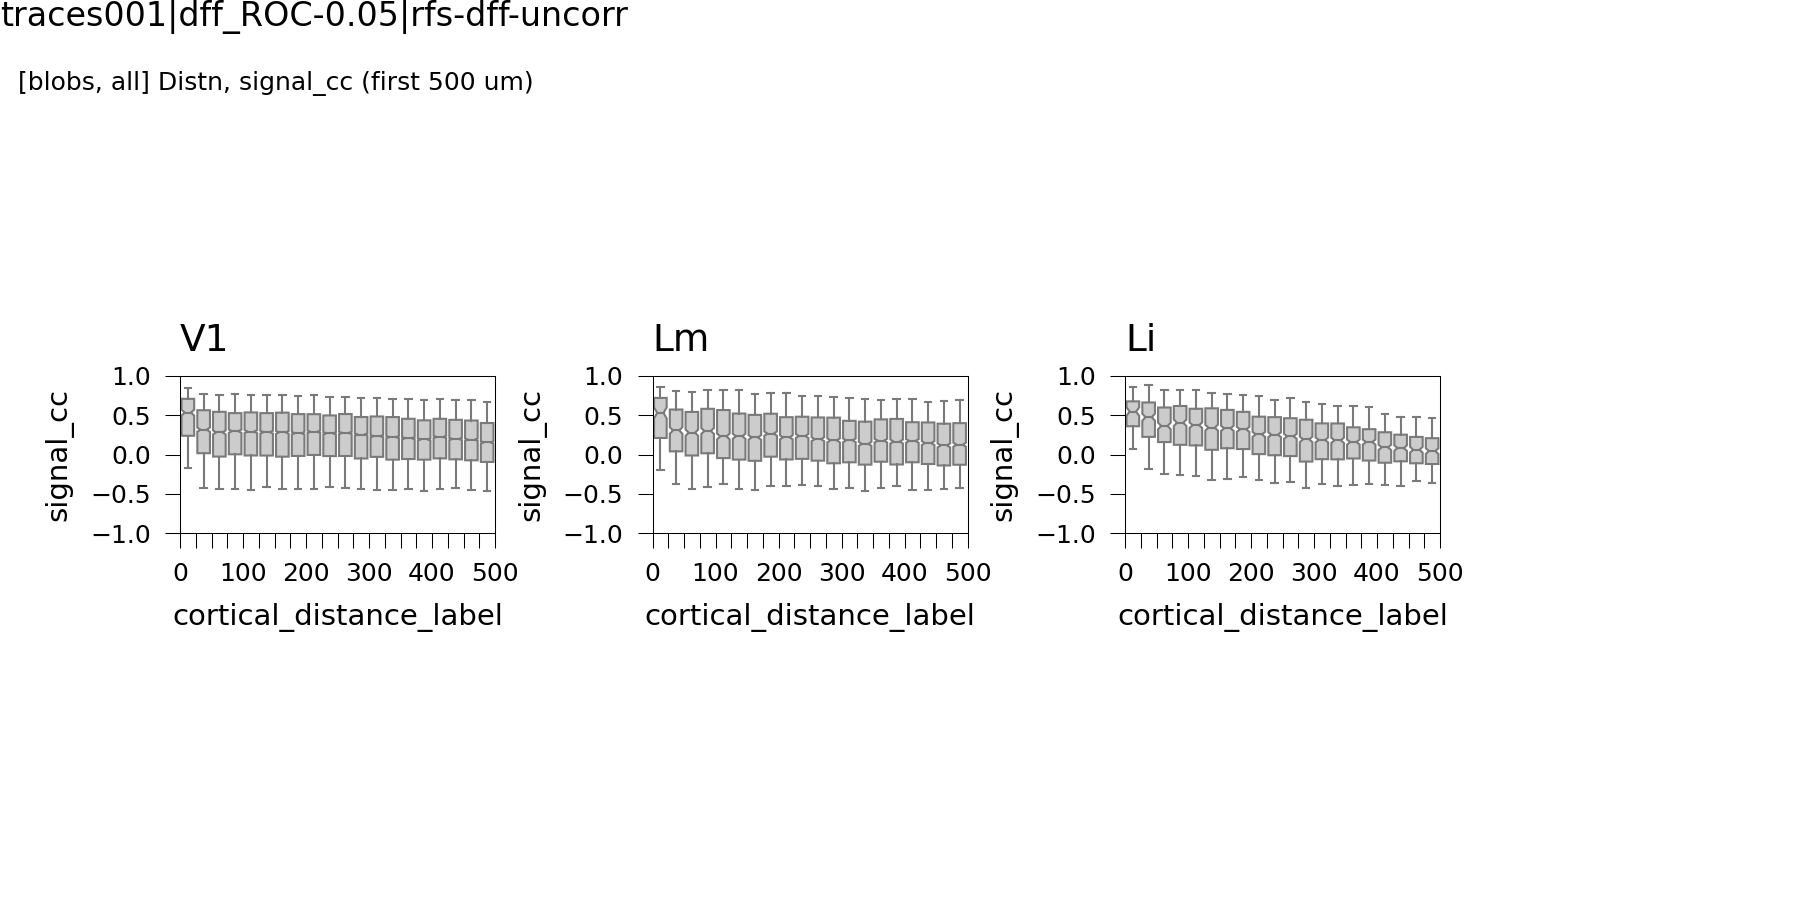

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/ROC_minsub-none_rfs-dff-uncorr boxplot_signal_cc_v_cortical_distance_max500um_bin25


In [189]:
ctx_maxdist = 500
y_var='signal_cc'
dist_var='cortical_distance'
cmap='viridis'
tuned_or_resp = 'responsive'
ctx_step = 25
# ----------------------------------
df = CORRS[(CORRS.cortical_distance<=ctx_maxdist)].copy().dropna()
# Cut bins
df, dist_lut = cr.get_bins_and_cut(df, ctx_step=ctx_step, rf_step=2, 
                                   dir_step=30, ori_step=15)
fig, axn = pl.subplots(1, 3, figsize=(6,3), dpi=150, sharey=False)
for va, vg in df.groupby('visual_area'):
    x_var='%s_label' % dist_var
    ax=axn[visual_areas.index(va)]
    sns.boxplot(x=x_var, y=y_var, data=vg, ax=ax, whis=(5, 95),
               fliersize=0, color=[0.8]*3, linewidth=0.5, notch=True)
    ax.set_box_aspect(0.5)
    ax.set_ylim([-1,1])
    ax.set_yticks(np.linspace(-1, 1, 5)) #([-1,1])
    xbins = sorted([i for i in dist_lut[dist_var]['bins'] if i<=ctx_maxdist])
    xticks = np.arange(0, len(xbins))
    ax.set_xticks(xticks-0.5)
    ax.set_xticklabels([int(xbins[i]) if i in xticks[0::4] or i==xticks[-1] \
                        else '' for i in xticks])
    ax.set_title(va, loc='left')
pl.subplots_adjust(left=0.1, right=0.8, wspace=0.5)

fig.text(0.01, 0.9, '[%s, %s] Distn, %s (first %i um)' \
             % (experiment, select_stimuli, y_var, ctx_maxdist))
pplot.label_figure(fig, data_id)

figname = 'boxplot_%s_v_%s_max%ium_bin%i' \
            % (y_var, dist_var, ctx_maxdist, ctx_step)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

# DISTS:  Correlate tuning curves

In [190]:
create_new=True

In [191]:
avg_responses['morphlevel'].min()

-1

In [205]:
# Calculate distances
tuning_curve_data = avg_responses[avg_responses.morphlevel!=-1].copy()

if create_new:
    print("Creatnig new DISTS. Saving to:\n    %s" % dists_results_file)
    DISTS = cr.aggregate_tuning_curve_ccdist(tuning_curve_data, rfdf=rfdf, 
                                         rfpolys=rfpolys,sort_best_size=False,
                                         normalize=True,
                                         min_ncells=5, stimulus='blobs')
#     res = {'responses': avg_responses,
#            'rfdf': rfdf, 'DISTS': DISTS}
#     with open(dists_results_file, 'wb') as f:
#         pkl.dump(res, f, protocol=2)

Creatnig new DISTS. Saving to:
    /n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/results_ROC_minsub-none_rfs-dff-uncorr.pkl
    (20190422_JC076_fov1 NONE, skipping overlaps)
    (20191111_JC120_fov1 NONE, skipping overlaps)
    (20190422_JC076_fov1 NONE, skipping overlaps)
    (20190430_JC078_fov1 NONE, skipping overlaps)
    (20190504_JC078_fov1 NONE, skipping overlaps)
    (20190506_JC080_fov1 NONE, skipping overlaps)
    (20190508_JC083_fov1 NONE, skipping overlaps)
    (20190501_JC076_fov1 NONE, skipping overlaps)
    (20190507_JC083_fov1 NONE, skipping overlaps)
[]


In [80]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/ROC_minsub-none_rfs-dff-uncorr'

In [ ]:
print(dists_results_file)

# MERGE DISTS and CORRS

In [194]:
CORRS.head()

cell_1  cell_2  signal_cc neuron_pair  noise_cc  cortical_distance  \
0      76      80   0.616004       76_80  0.347473          50.195743   
1      76      81   0.580529       76_81  0.300683          73.768600   
2      76     119   0.603707      76_119  0.352520          82.268232   
3      76     135   0.464694      76_135  0.208156         189.151666   
4      76     136   0.167024      76_136  0.100257         163.134469   

  visual_area              datakey experiment  n_cells  
0          Li  20190422_JC076_fov1      blobs       29  
1          Li  20190422_JC076_fov1      blobs       29  
2          Li  20190422_JC076_fov1      blobs       29  
3          Li  20190422_JC076_fov1      blobs       29  
4          Li  20190422_JC076_fov1      blobs       29

In [206]:
DISTS.head()

xcorr_morph  pearsons_morph  cosim_morph  cell_1  cell_2 neuron_pair  \
0     4.063408        0.698949     0.959023    76.0    80.0       76_80   
1     3.200770       -0.122446     0.890764    76.0    81.0       76_81   
2     3.685720        0.437926     0.942992    76.0   119.0      76_119   
3     2.807402       -0.013169     0.832709    76.0   135.0      76_135   
4     2.914360       -0.263580     0.870905    76.0   136.0      76_136   

   xcorr_size  pearsons_size  cosim_size  max_response  ...  \
0    1.513496       0.777778    0.863933      0.600692  ...   
1    0.893625      -0.449815    0.579897      0.630790  ...   
2    1.411922       0.674091    0.870050      0.313761  ...   
3    1.451351       0.347309    0.788222      0.668692  ...   
4    0.858750      -0.331636    0.537378      0.674573  ...   

   rf_angle_diff_abs  std_x  std_y  aspect_ratio  area_overlap  perc_overlap  \
0                NaN    NaN    NaN           NaN           NaN           NaN   
1                NaN    NaN    NaN           NaN           NaN           NaN   
2                NaN    NaN    NaN           NaN           NaN           NaN   
3                NaN    NaN    NaN           NaN           NaN           NaN   
4                NaN    NaN    NaN           NaN           NaN           NaN   

   overlap_index  visual_area              datakey  n_cells  
0            NaN           Li  20190422_JC076_fov1       29  
1            NaN           Li  20190422_JC076_fov1       29  
2            NaN           Li  20190422_JC076_fov1       29  
3            NaN           Li  20190422_JC076_fov1       29  
4            NaN           Li  20190422_JC076_fov1       29  

[5 rows x 25 columns]

In [207]:
DISTS = DISTS.rename(columns={'n_cells':'n_cells_fit'}).reset_index(drop=True)
CORRS = CORRS.rename(columns={'n_cells':'n_cells_responsive'}).reset_index(drop=True)
incl_cc_cols = ['cell_1', 'cell_2', 'signal_cc', 'neuron_pair', 'noise_cc',
               'visual_area', 'datakey', 'n_cells_responsive']

In [208]:
ccdist = pd.merge(CORRS[incl_cc_cols], DISTS,
            on=['visual_area', 'datakey', 'neuron_pair', 'cell_1', 'cell_2'], 
            how='outer', suffixes=('_fit', '_responsive'))
ccdist.shape, DISTS.shape, CORRS.shape

((138186, 28), (138186, 25), (111327, 10))

#### Check merge

In [209]:
check_pairs=[]
for (va, dk), g in DISTS.groupby(['visual_area', 'datakey']):
    curr_pairs = g['neuron_pair'].values
    cc = CORRS[(CORRS.visual_area==va) & (CORRS.datakey==dk)]
    not_in_cc = [k for k in curr_pairs if (k not in cc['neuron_pair'].values)
                and (k[::-1] not in cc['neuron_pair'].values)]
    if len(not_in_cc)>0:
        check_pairs.append(g[g['neuron_pair'].isin(not_in_cc)])
if len(check_pairs)>0:
    checkdf = pd.concat(check_pairs, axis=0, ignore_index=True)
else:
    print("Correct matches")

In [210]:
checkdf

xcorr_morph  pearsons_morph  cosim_morph  cell_1  cell_2 neuron_pair  \
0              NaN             NaN          NaN    14.0    15.0       14_15   
1              NaN             NaN          NaN    14.0    16.0       14_16   
2              NaN             NaN          NaN    14.0    22.0       14_22   
3              NaN             NaN          NaN    14.0    24.0       14_24   
4              NaN             NaN          NaN    14.0    25.0       14_25   
...            ...             ...          ...     ...     ...         ...   
26539          NaN             NaN          NaN   347.0   381.0     347_381   
26540          NaN             NaN          NaN   347.0   384.0     347_384   
26541          NaN             NaN          NaN   356.0   381.0     356_381   
26542          NaN             NaN          NaN   356.0   384.0     356_384   
26543          NaN             NaN          NaN   381.0   384.0     381_384   

       xcorr_size  pearsons_size  cosim_size  max_response  ...  \
0             NaN            NaN         NaN           NaN  ...   
1             NaN            NaN         NaN           NaN  ...   
2             NaN            NaN         NaN           NaN  ...   
3             NaN            NaN         NaN           NaN  ...   
4             NaN            NaN         NaN           NaN  ...   
...           ...            ...         ...           ...  ...   
26539         NaN            NaN         NaN           NaN  ...   
26540         NaN            NaN         NaN           NaN  ...   
26541         NaN            NaN         NaN           NaN  ...   
26542         NaN            NaN         NaN           NaN  ...   
26543         NaN            NaN         NaN           NaN  ...   

       rf_angle_diff_abs      std_x     std_y  aspect_ratio  area_overlap  \
0               6.819677   7.709079  0.307285      0.622164           NaN   
1               2.416491  12.420190  2.954071      0.694701           NaN   
2               7.387360   4.554638  2.261077      0.702008           NaN   
3              19.330062  12.012340  2.205692      0.777606           NaN   
4              26.597918  12.298201  7.984499      0.716019           NaN   
...                  ...        ...       ...           ...           ...   
26539          72.807281   4.729972  3.273197      0.062016           NaN   
26540          23.583483   1.010575  5.032864      0.849051           NaN   
26541          84.296201   3.071727  2.131770      0.935720           NaN   
26542          12.094563   0.647670  0.372103      0.024654           NaN   
26543          83.609236   3.719397  1.759667      0.911066           NaN   

       perc_overlap  overlap_index  visual_area              datakey  \
0               NaN            NaN           Li  20190602_JC091_fov1   
1               NaN            NaN           Li  20190602_JC091_fov1   
2               NaN            NaN           Li  20190602_JC091_fov1   
3               NaN            NaN           Li  20190602_JC091_fov1   
4               NaN            NaN           Li  20190602_JC091_fov1   
...             ...            ...          ...                  ...   
26539           NaN            NaN           V1  20191006_JC110_fov1   
26540           NaN            NaN           V1  20191006_JC110_fov1   
26541           NaN            NaN           V1  20191006_JC110_fov1   
26542           NaN            NaN           V1  20191006_JC110_fov1   
26543           NaN            NaN           V1  20191006_JC110_fov1   

       n_cells_fit  
0               87  
1               87  
2               87  
3               87  
4               87  
...            ...  
26539           86  
26540           86  
26541           86  
26542           86  
26543           86  

[26544 rows x 25 columns]

# Boxplot distributions by distance

<IPython.core.display.Javascript object>


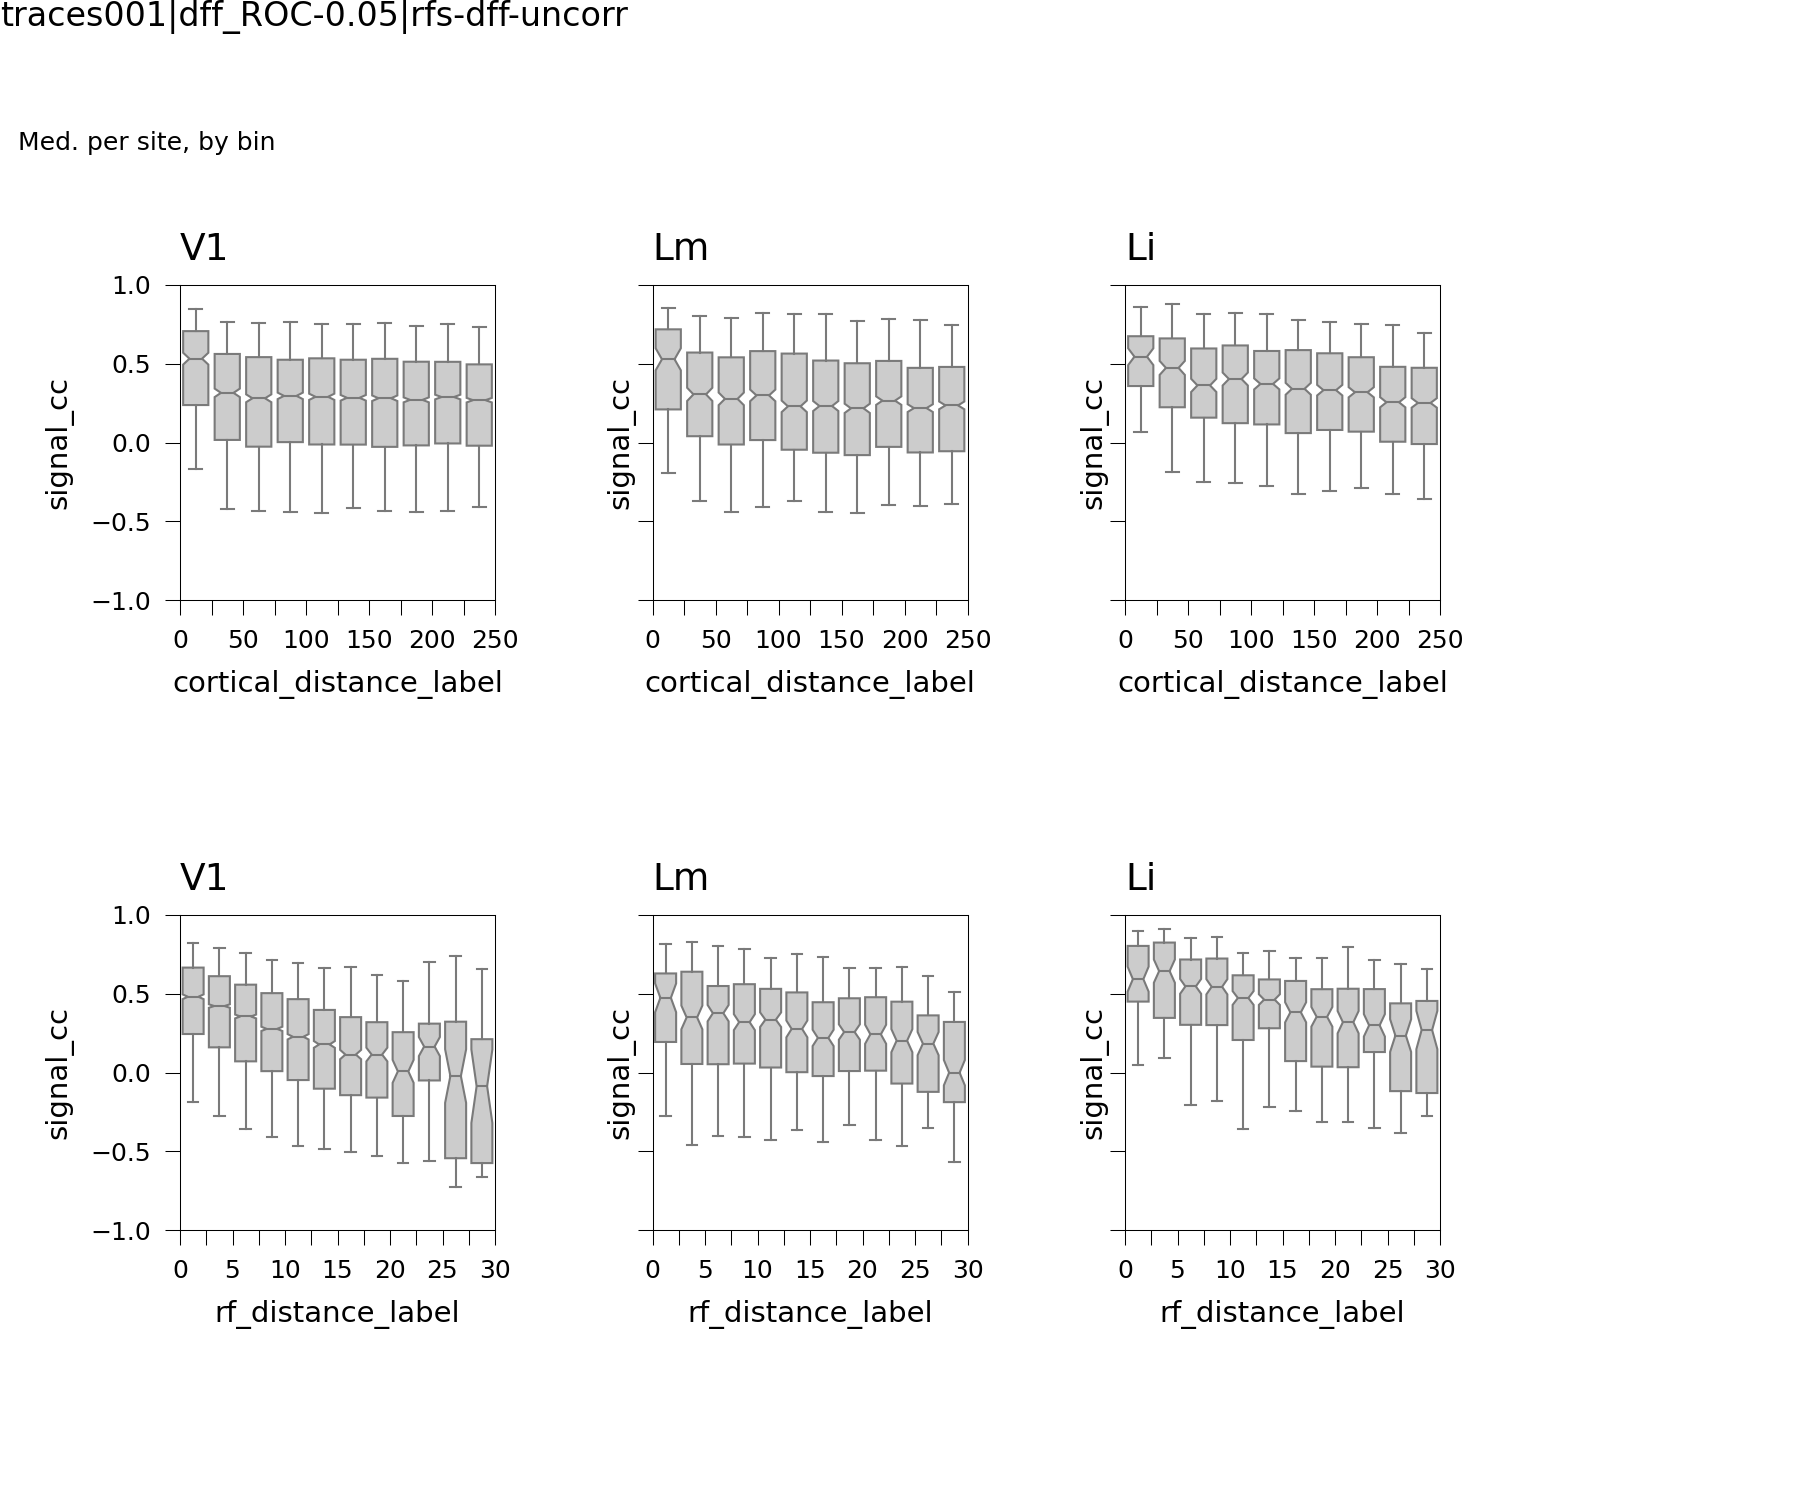

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/ROC_minsub-none_rfs-dff-uncorr boxplot_binned-dist_signal_cc


In [211]:
%matplotlib notebook
y_var = 'signal_cc'
dist_vars=['cortical_distance', 'rf_distance']
fit_sites=True
ctx_maxdist=250
rf_maxdist = 30
min_npairs=10
min_npoints=5

fig, axn = pl.subplots(2,3, figsize=(6,5), dpi=150, sharex=False, sharey=True)
for ri, dist_var in enumerate(dist_vars):
    curr_maxdist = ctx_maxdist if dist_var=='cortical_distance' else rf_maxdist
    df, dist_lut = cr.get_bins_and_cut(ccdist[ccdist[dist_var]<=curr_maxdist], 
                                   ctx_step=25, overlap_step=0.2, rf_step=2.5, 
                                   equal_bins=False)
    for va, vg in df.groupby('visual_area'):
        x_var='%s_label' % dist_var
        ax=axn[ri, visual_areas.index(va)]
        sns.boxplot(x=x_var, y=y_var, data=vg, ax=ax, whis=(5, 95),
                   fliersize=0, color=[0.8]*3, linewidth=0.5, notch=True)
        ax.set_box_aspect(1)
        ax.set_ylim([-1,1])
        ax.set_yticks(np.linspace(-1, 1, 5)) #([-1,1])
        xbins = sorted([i for i in dist_lut[dist_var]['bins'] if i<=curr_maxdist])
        xticks = np.arange(0, len(xbins))
        ax.set_xticks(xticks-0.5)
        ax.set_xticklabels([int(xbins[i]) if i in xticks[0::2] or i==xticks[-1] \
                            else '' for i in xticks])
        ax.set_title(va, loc='left')
pl.subplots_adjust(left=0.1, right=0.8, wspace=0.5)

fig.text(0.01, 0.9, 'Med. per site, by bin')

pplot.label_figure(fig, data_id)
figname = 'boxplot_binned-dist_%s' % (y_var)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

<IPython.core.display.Javascript object>


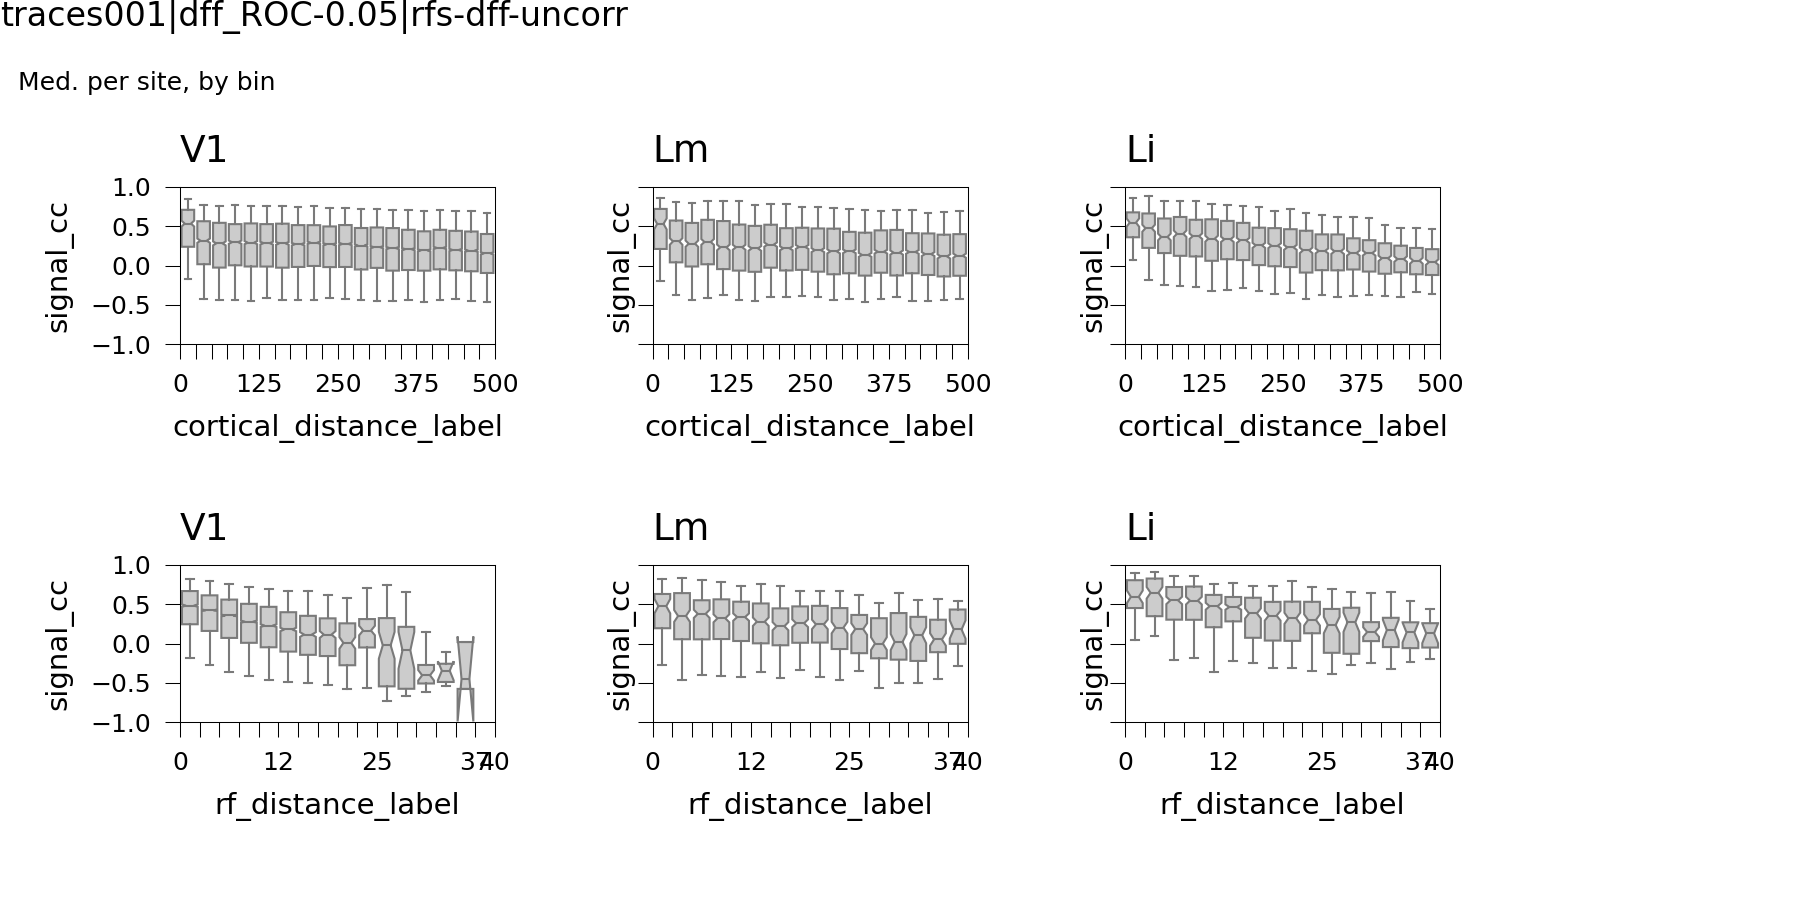

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/ROC_minsub-none_rfs-dff-uncorr boxplot_binned-dist_signal_cc


In [204]:
%matplotlib notebook
y_var = 'signal_cc'
dist_vars=['cortical_distance', 'rf_distance']
fit_sites=True
ctx_maxdist=500
rf_maxdist = 40
min_npairs=10
min_npoints=5

fig, axn = pl.subplots(2,3, figsize=(6,3), dpi=150, sharex=False, sharey=True)
for ri, dist_var in enumerate(dist_vars):
    curr_maxdist = ctx_maxdist if dist_var=='cortical_distance' else rf_maxdist
    df, dist_lut = cr.get_bins_and_cut(ccdist[ccdist[dist_var]<=curr_maxdist], 
                                   ctx_step=25, overlap_step=0.2, rf_step=2.5, 
                                   equal_bins=False)

    for va, vg in df.groupby('visual_area'):
        x_var='%s_label' % dist_var
        ax=axn[ri, visual_areas.index(va)]
        sns.boxplot(x=x_var, y=y_var, data=vg, ax=ax, whis=(5, 95),
                   fliersize=0, color=[0.8]*3, linewidth=0.5, notch=True)
        ax.set_box_aspect(0.5)
        ax.set_ylim([-1,1])
        ax.set_yticks(np.linspace(-1, 1, 5)) #([-1,1])
        xbins = sorted([i for i in dist_lut[dist_var]['bins'] if i<=curr_maxdist])
        xticks = np.arange(0, len(xbins))
        ax.set_xticks(xticks-0.5)
        ax.set_xticklabels([int(xbins[i]) if i in xticks[0::5] or i==xticks[-1] \
                            else '' for i in xticks])
        ax.set_title(va, loc='left')
pl.subplots_adjust(left=0.1, right=0.8, wspace=0.5)

fig.text(0.01, 0.9, 'Med. per site, by bin')

pplot.label_figure(fig, data_id)
figname = 'boxplot_binned-dist_%s' % (y_var)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

# RF distance metrics, per CTX bin

In [47]:
ctx_maxdist=800
df, dist_lut = cr.get_bins_and_cut(DISTS[DISTS.cortical_distance<=ctx_maxdist], 
                                   ctx_step=25, overlap_step=0.2, rf_step=2.0, 
                                   equal_bins=False)

cortical_distance 25


<IPython.core.display.Javascript object>


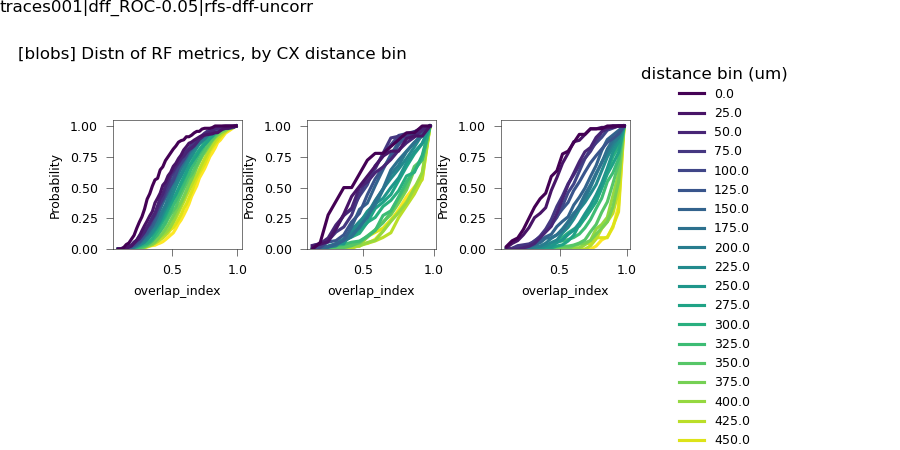

Li
/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/ROC_minsub-exclude_rfs-dff-uncorr cdf_RFdist_per_CXbin_25um-step_overlap_index


In [48]:
dist_var = 'cortical_distance'
count_var = 'overlap_index'
dist_bins = list(dist_lut[dist_var]['bins'])
hue_step = dist_lut[dist_var]['step']
print(dist_var, hue_step)

n_bins = 20
curr_bins = dist_bins[0:n_bins]
plotd = df[df['%s_label' % dist_var].isin(curr_bins)].copy()

fig, axn = pl.subplots(1, 3, figsize=(6,3), dpi=150)
for va, vg in plotd.groupby(['visual_area']):
    ax=axn[visual_areas.index(va)]
    sns.histplot(x=count_var, data=vg, ax=ax,
                hue='%s_label' % dist_var, cumulative=True, common_norm=False,
                element='poly', fill=False, stat='probability', palette='viridis')
    ax.set_box_aspect(1)
    if va=='Li':
        print(va)
        pplot.sns_histplot_legend(ax, bbox_to_anchor=(1, 1.5), loc='upper left', 
                                  frameon=False, title='distance bin (um)')
    else:
        ax.legend_.remove()
pl.subplots_adjust(bottom=0.3, right=0.7, wspace=0.5)

pplot.label_figure(fig, data_id)
fig.text(0.02, 0.87, '[%s] Distn of RF metrics, by CX distance bin' \
         % (experiment), fontsize=8)

figname = 'cdf_RFdist_per_CXbin_%sum-step_%s' % (hue_step, count_var)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


# Medians by FOV (bar)

In [797]:
importlib.reload(cr)

<module 'analyze2p.correlations' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

<IPython.core.display.Javascript object>


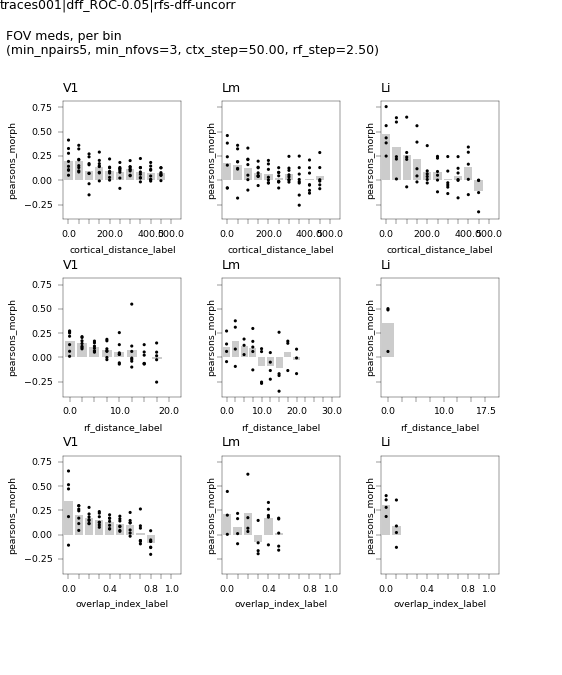

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/ROC_minsub-exclude_rfs-dff-uncorr barplot_pearsons_morph_v_dist-metrics


In [801]:
%matplotlib notebook
metric = 'pearsons_morph'

ctx_maxdist=500
min_nfovs=3
min_npairs=5

ctx_step = 50
rf_step=2.5
df, dist_lut = cr.get_bins_and_cut(DISTS[DISTS.cortical_distance<=ctx_maxdist], 
                                   ctx_step=ctx_step, rf_step=rf_step, 
                                   overlap_step=0.1, equal_bins=False)
dist_vars=['cortical_distance', 'rf_distance', 'overlap_index']

%matplotlib notebook
fig = cr.barplot_fov_medians_per_bin(metric, dist_vars, df, dist_lut, 
                min_npairs=min_npairs, min_nfovs=min_nfovs, round_x=1,
                xtick_step=4, sharex_dist=False, barcolor=[0.8]*3, strip_size=2,
                figsize=(5,6))
                             
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.15, hspace=0.5, top=0.85)
fig.text(0.01, 0.92, \
        'FOV meds, per bin\n(min_npairs%i, min_nfovs=%i, ctx_step=%.2f, rf_step=%.2f)'\
         % (min_npairs, min_nfovs, ctx_step, rf_step), fontsize=8)

pplot.label_figure(fig, data_id)
figname = 'barplot_%s_v_dist-metrics' % (metric)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

# Heatmaps: cortical vs. RF distance

In [793]:
# Split distances into X um bins
x_var = 'cortical_distance'
y_var = 'overlap_index'
hue_var = 'pearsons_size'
# -----------------------------
ctx_maxdist = 500 #500
rf_maxdist=50
if hue_var == 'signal_cc':
    df, dist_lut = cr.get_bins_and_cut(ccdist[(ccdist.cortical_distance<=ctx_maxdist)
                                        & (ccdist.rf_distance<=rf_maxdist)], 
                                   ctx_step=25, rf_step=2, overlap_step=0.1)
else:
    df, dist_lut = cr.get_bins_and_cut(DISTS[(DISTS.cortical_distance<=ctx_maxdist)
                                        & (DISTS.rf_distance<=rf_maxdist)], 
                                   ctx_step=25, rf_step=2, overlap_step=0.1)
    
print(df.groupby([x_var, y_var])[hue_var].mean().min())
print(df.groupby([x_var, y_var])[hue_var].mean().max())

-0.9965961555009633
0.999857949592178


<IPython.core.display.Javascript object>


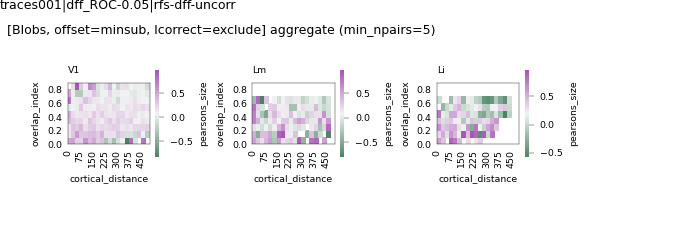

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/ROC_minsub-exclude_rfs-dff-uncorr heatmaps_aggrFOV_overlap_index_v_cortical_distance_hue-pearsons_size


In [794]:
# x_var = 'cortical_distance'
# y_var = 'overlap_index'
# hue_var = 'pearsons_morph'
# -----------------------------
min_npairs=5
x_bins = dist_lut[x_var]['bins']
y_bins = dist_lut[y_var]['bins']
hue_min, hue_max = None, None #@(-1, 1)
#hue_min, hue_max =  (-0.2, 0.5) #if hue_var=='pearsons_morph' else (-0.6, 0.6)
#hue_min, hue_max =  (-0.3, 0.8)

cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True)
x_var_name = '%s_label' % x_var
y_var_name = '%s_label' % y_var

fig, axn = pl.subplots(1, 3, figsize=(6, 2), dpi=150, sharex=True, sharey=False)
# cbar_ax = fig.add_axes([0.8, 0.3, 0.01, 0.3])
for ai, (va, vg) in enumerate(df.groupby('visual_area')):
    ax=axn[visual_areas.index(va)]
    cnts = vg.groupby([x_var_name, y_var_name])['neuron_pair'].count().reset_index()
    valid_x = cnts[cnts['neuron_pair']>=min_npairs][x_var_name].unique()
    valid_y = cnts[cnts['neuron_pair']>=min_npairs][y_var_name].unique()
    df0 = vg[(vg[x_var_name].isin(valid_x)) & (vg[y_var_name].isin(valid_y))]

    ax=cr.heatmap_tuning_v_distance(df0, x_bins, y_bins, ax=ax,
                                      x_var=x_var, y_var=y_var, 
                                      hue_var=hue_var, hue_norm=(hue_min, hue_max),
                                      cmap=cmap, cbar=True, cbar_kws={'shrink':0.5})
#                                       cbar_ax=cbar_ax if ai==0 else None)
    ax.set_title(va, loc='left', fontsize=6)
    yticks = np.arange(0, len(y_bins))
    curr_ylim = df0.dropna()[y_var_name].max()
    ax.set_ylim([0, list(y_bins).index(curr_ylim)])
    ax.set_ylabel(y_var)
    ax.set_xlabel(x_var)
    # ax.invert_yaxis()
fig.text(0.01, 0.85, '[Blobs, offset=%s, lcorrect=%s] aggregate (min_npairs=%i)' 
         % (offset_type, lcorrection, min_npairs), fontsize=8)
pl.subplots_adjust(wspace=0.8, right=0.8, left=0.1)

pplot.label_figure(fig, data_id)
figname = 'heatmaps_aggrFOV_%s_v_%s_hue-%s' % (y_var, x_var, hue_var)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

<IPython.core.display.Javascript object>


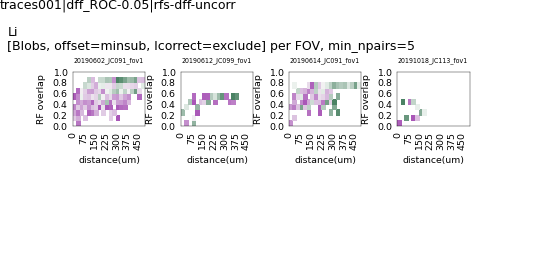

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/ROC_minsub-exclude_rfs-dff-uncorr heatmaps_byFOV_Li_overlap_index_v_cortical_distance_hue-pearsons_size


<IPython.core.display.Javascript object>


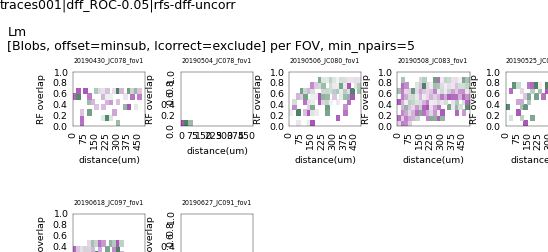

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/ROC_minsub-exclude_rfs-dff-uncorr heatmaps_byFOV_Lm_overlap_index_v_cortical_distance_hue-pearsons_size


<IPython.core.display.Javascript object>


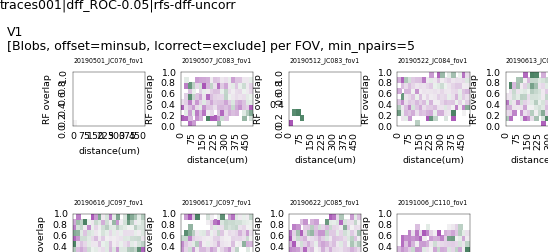

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/ROC_minsub-exclude_rfs-dff-uncorr heatmaps_byFOV_V1_overlap_index_v_cortical_distance_hue-pearsons_size


In [795]:
nr=2
nc=5

#hue_min, hue_max = (-.6, 0.6) #if hue_var=='pearsons_morph' else (-0.6, 0.6)
cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True)

for va, vg in df.groupby('visual_area'):
    fig, axn = pl.subplots(nr, nc, figsize=(6.5,3), dpi=150, 
                           sharex=False, sharey=False)
    cbar_ax = fig.add_axes([0.81, 0.3, 0.01, 0.3])
    grped_means = vg.groupby(['%s_label' % x_var, '%s_label' % y_var]).mean()
    i=0
    for ai, (ax, (dk, df_)) in enumerate(zip(axn.flat, vg.groupby('datakey'))):
        ax=cr.heatmap_tuning_v_distance(df_, x_bins, y_bins, ax=ax,
                                      x_var=x_var, y_var=y_var, 
                                      hue_var=hue_var, hue_norm=(hue_min, hue_max),
                                      cmap=cmap, cbar=ai==0, #lw=0.5,
                                      cbar_ax=cbar_ax if ai==0 else None)
        ax.set_title(dk, loc='left', fontsize=4)
        ax.set_xlabel('distance(um)')
        ax.set_ylabel('RF overlap')
        i+=1
    for ai in np.arange(i, nr*nc):
        axn.flat[ai].axis('off')
    pl.subplots_adjust(wspace=0.5, right=0.79, left=0.1)
    fig.text(0.01, 0.85, '%s\n[Blobs, offset=%s, lcorrect=%s] per FOV, min_npairs=%i' 
         % (va, offset_type, lcorrection, min_npairs), fontsize=8)

    pplot.label_figure(fig, data_id)
    figname = 'heatmaps_byFOV_%s_%s_v_%s_hue-%s' % (va, y_var, x_var, hue_var)
    pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
    print(dst_dir, figname)

In [69]:
df0.groupby([x_var, y_var])['neuron_pair'].count()

cortical_distance  overlap_index
8.901078           0.452692         1
9.793585           0.389434         1
9.973373           0.119427         1
                   0.245038         1
10.285077          0.409872         1
                                   ..
499.843022         0.713651         1
499.894386         0.433298         1
                   0.764703         1
499.896163         0.700457         1
499.985442         0.901521         1
Name: neuron_pair, Length: 13879, dtype: int64

In [80]:
cnts.fillna(value=0)

cortical_distance_label  overlap_index_label  neuron_pair
0                        0.0                 0.10            5
1                        0.0                 0.15           10
2                        0.0                 0.20           18
3                        0.0                 0.25           20
4                        0.0                 0.30           22
..                       ...                  ...          ...
353                    475.0                 0.75           84
354                    475.0                 0.80           59
355                    475.0                 0.85           41
356                    475.0                 0.90           35
357                    475.0                 0.95           26

[358 rows x 3 columns]

<IPython.core.display.Javascript object>


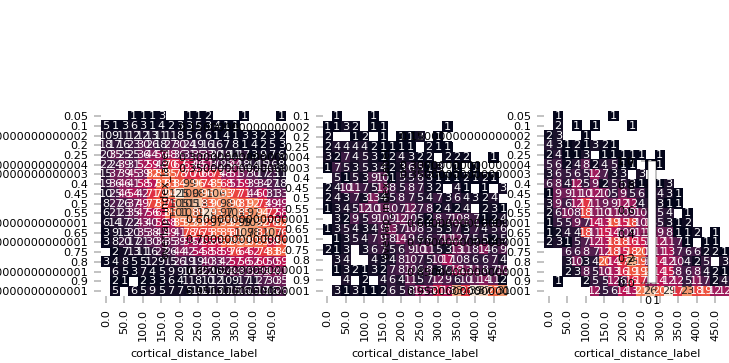

In [86]:
fig, axn = pl.subplots(1, 3, figsize=(6, 3), dpi=150, sharex=True, sharey=False)
cbar_ax = fig.add_axes([0.8, 0.3, 0.01, 0.3])
for ai, (va, vg) in enumerate(df.groupby('visual_area')):
    ax=axn[visual_areas.index(va)]
    cnts = vg.groupby([x_var_name, y_var_name])['neuron_pair'].count().reset_index()
    cnt_table = cnts.fillna(value=0).pivot(y_var_name, x_var_name, 'neuron_pair')
    sns.heatmap(cnt_table, annot=True, fmt=".0f", ax=ax,
               annot_kws={'fontsize': 6}, cbar=False)
    ax.set_box_aspect(1)
    

In [56]:
curr_ylim

44.0

In [167]:
'20190315_JC070_fov1' in rfdf['datakey'].unique()

False

In [ ]:
cnts = plotd.groupby([x_var_name, y_var_name])['neuron_pair'].count()


<IPython.core.display.Javascript object>


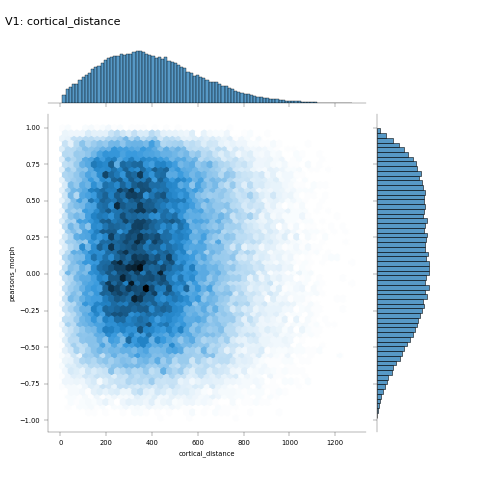

<IPython.core.display.Javascript object>


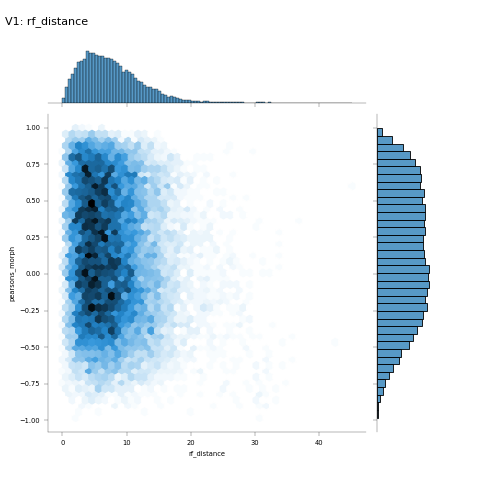

<IPython.core.display.Javascript object>


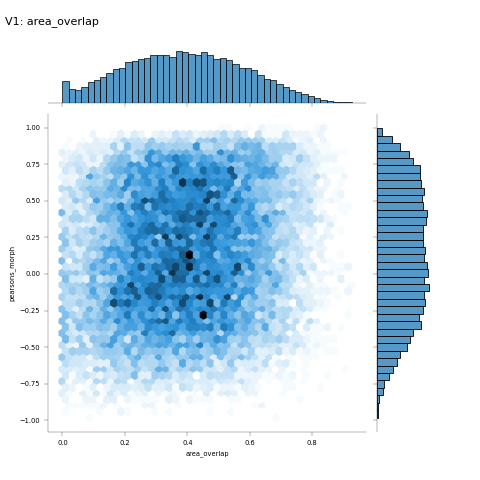

In [34]:
%matplotlib notebook
y_var='pearsons_morph'
for dist_var in ['cortical_distance', 'rf_distance', 'area_overlap']:
    fg = sns.jointplot(x=dist_var, y=y_var, data=plotd, 
                    kind='hex', height=6, )
    pl.subplots_adjust(left=0.1, bottom=0.1, top=0.9, right=0.9)
    fg.fig.text(0.01, 0.95, '%s: %s' % (va, dist_var),
               fontsize=10)
    
    figname = 'joint_%s_and_%s_V1' % (y_var, dist_var)
    pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

In [53]:
min_ncells=50
plotd = df[df['n_cells']>=min_ncells]

In [54]:
df['visual_area'].unique()

array(['Li', 'Lm', 'V1'], dtype=object)

<IPython.core.display.Javascript object>


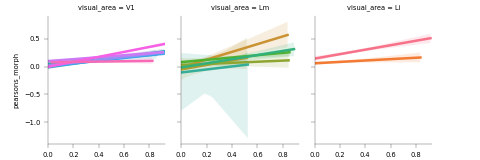

In [55]:
scatter_kws={'s':1}

fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, 
                   hue='datakey', height=2, data=plotd)
fg.map(sns.regplot, dist_var, y_var,
            scatter_kws=scatter_kws, scatter=False)
# ax.legend_.remove()
pl.subplots_adjust(left=0.1, bottom=0.1, top=0.9, right=0.9)
fig.text(0.01, 0.95, '%s: %s' % (va, dist_var),
           fontsize=10)
figname = 'joint_%s_and_%s_V1' % (y_var, dist_var)

In [189]:
import analyze2p.scatter as sct

In [342]:
dk='20190616_JC097_fov1'
va='V1'

ctx_maxdist=1000
equal_bins=False
n_bins=10

df = DISTS.copy()
# Split distances into X um bins
ctx_step=25
if equal_bins:
    ctx_bins = np.linspace(0, ctx_maxdist, n_bins)
else:
    ctx_bins = np.arange(0, 1200+ctx_step, ctx_step)
df = cr.cut_bins(df, ctx_bins, 'cortical_distance')

rf_step=2.5
curr_maxdist = DISTS[(DISTS.visual_area==va) 
                    & (DISTS.datakey==dk)]['rf_distance'].max()
if equal_bins:
    rf_bins = np.linspace(0, curr_maxdist, n_bins)
else:
    rf_bins = np.arange(0, 40+rf_step, rf_step)
df = cr.cut_bins(df, rf_bins, 'rf_distance')
df.head()

perc_step = 0.05
if equal_bins:
    perc_bins = np.linspace(0, 1, n_bins)
else:
    perc_bins = np.arange(0, 1+perc_step, perc_step)
df = cr.cut_bins(df, perc_bins, 'area_overlap')
# Split
dist_lut = {'cortical_distance': {'bins': ctx_bins, 'step': ctx_step},
            'rf_distance': {'bins': rf_bins, 'step': rf_step},
            'area_overlap': {'bins': perc_bins, 'step': perc_step}           }

plotd = df[(df.cortical_distance<=ctx_maxdist)].copy().dropna()
vg = plotd[(plotd.datakey==dk) & (plotd.visual_area==va)].dropna()

<IPython.core.display.Javascript object>


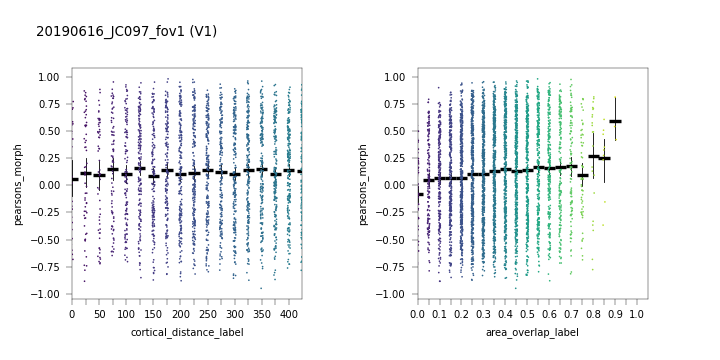

Text(0.05, 0.9, '20190616_JC097_fov1 (V1)')

In [354]:
%matplotlib notebook
scatter_kws={'s':0.5}
dist_vars = ['cortical_distance', 'area_overlap']
curr_ctx_maxdist = 400

r_list=[]

fig, axn = pl.subplots(1, 2, figsize=(6,3), dpi=150)

for ax, dist_var in zip(axn.flat, dist_vars):
    x_bins = [k for k in dist_lut[dist_var]['bins'] if k<=curr_ctx_maxdist]
    curr_maxdist = max(x_bins)
    if x_var=='cortical_distance':
        df_ = vg[vg.cortical_distance<=curr_ctx_maxdist].copy()
    else:
        df_ = vg.copy()
        
    x_var = '%s_label' % dist_var
#     sns.boxplot( x=x_var, y='pearsons_morph', ax=ax,
#                 data=df_, fliersize=0, linewidth=0.5, width=0.8,
#                color=[0.8]*3)
    sns.stripplot( x=x_var, y='pearsons_morph', ax=ax,
                data=df_, s=1, palette='viridis')
    sns.pointplot( x=x_var, y='pearsons_morph', ax=ax,
                data=df_, scale=1, markers='_', join=False, color='k',
                 errwidth=0.5)

    ax.set_xticks(np.arange(0, len(x_bins)))
    if dist_var=='area_overlap':
        ax.set_xticklabels([round(i, 1) if i in x_bins[0::2] else '' for i in x_bins])
    else:
        ax.set_xticklabels([int(i) if i in x_bins[0::2] else '' for i in x_bins])        
    ax.set_xlim([0, len(x_bins)])
for ax in axn.flat:
    ax.set_box_aspect(1)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.1, wspace=0.5)

fig.text(0.05, 0.9, '%s (%s)' % (dk, va), fontsize=8)

<IPython.core.display.Javascript object>


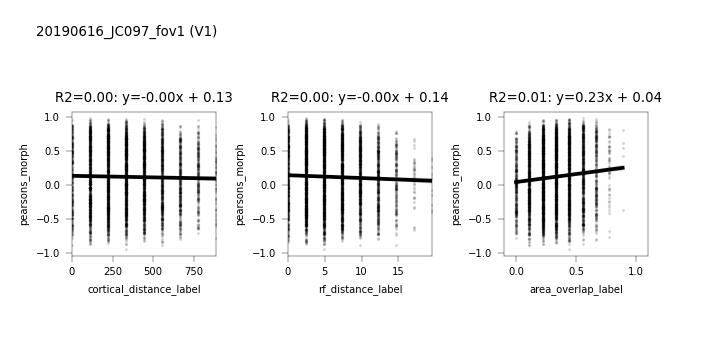

Text(0.05, 0.9, '20190616_JC097_fov1 (V1)')

In [336]:
%matplotlib notebook
scatter_kws={'s':0.5}
dist_vars = ['cortical_distance', 'rf_distance', 'area_overlap']
curr_ctx_maxdist = 800

r_list=[]

fig, axn = pl.subplots(1, 3, figsize=(6,3), dpi=150)

for ax, dist_var in zip(axn.flat, dist_vars):
    x_bins = dist_lut[dist_var]['bins']
    curr_maxdist = max(x_bins)
    if x_var=='cortical_distance':
        df_ = vg[vg.cortical_distance<=curr_ctx_maxdist].copy()
    else:
        df_ = vg.copy()
        
    x_var = '%s_label' % dist_var

    sns.regplot( x=x_var, y='pearsons_morph', ax=ax,
                data=df_, scatter_kws={'alpha':0.1, 's': 1}, color='k')
    # fit linear
    xvs = df_[x_var].values
    yvs = df_[y_var].values
    regr_, linmodel = sct.do_linear_fit(xvs, yvs, model='ridge')    
    regr_['dist_var'] = x_var 
    r_list.append(regr_)
    (r2, coef, intercept) = regr_[['R2', 'coefficient', 'intercept']].values[0]
    ax.set_title('R2=%.2f: y=%.2fx + %.2f' % (r2, coef, intercept))
    if 'area_overlap' in x_var:
        ax.set_xlim([-0.1, 1.1])

for ax in axn.flat:
    ax.set_box_aspect(1)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.1, wspace=0.5)

fig.text(0.05, 0.9, '%s (%s)' % (dk, va), fontsize=8)

In [279]:
np.linspace(0, 1, 11)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

<IPython.core.display.Javascript object>


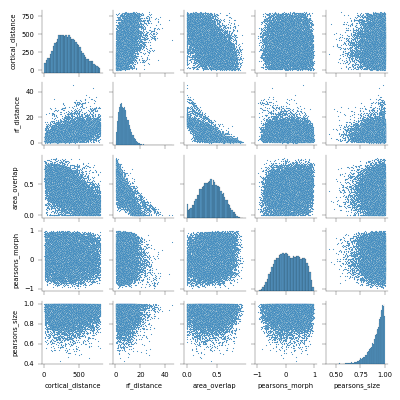

In [235]:
plotd = DISTS[(DISTS.cortical_distance<=ctx_maxdist)].copy().dropna()

vg = plotd[plotd.visual_area==va]

sns.pairplot(data=vg, vars=['cortical_distance', 'rf_distance', 
                               'area_overlap','pearsons_morph', 'pearsons_size'],
            size=1, plot_kws={'s':1})


fg.fig.text(0.01, 0.95, '%s: %s' % (va, dist_var),
           fontsize=10)

figname = 'pairplots_V1'
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

<IPython.core.display.Javascript object>


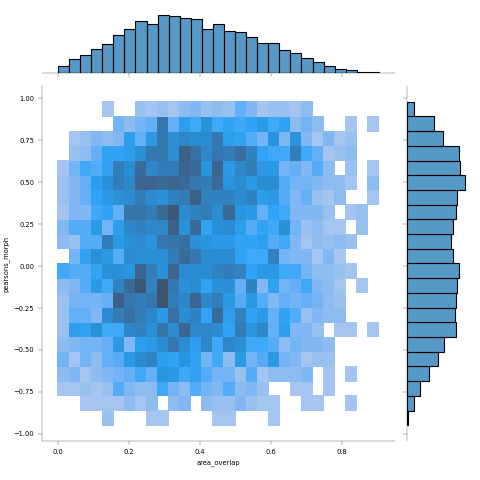

In [222]:
ctx_maxdist=1200
plotd = DISTS[(DISTS.cortical_distance<=ctx_maxdist)].copy().dropna()

dk='20190616_JC097_fov1'
va='V1'
df_ = plotd[(plotd.datakey==dk) & (plotd.visual_area==va)].dropna()

sns.jointplot(x=x_var, y=y_var, data=df_, ax=ax, kind='hist')

In [129]:
x_var

'cortical_distance'

In [77]:
df_.groupby(['datakey'])['neuron_pair'].count()  

datakey
20191006_JC110_fov1    3655
Name: neuron_pair, dtype: int64

RF distance (deg)


<IPython.core.display.Javascript object>


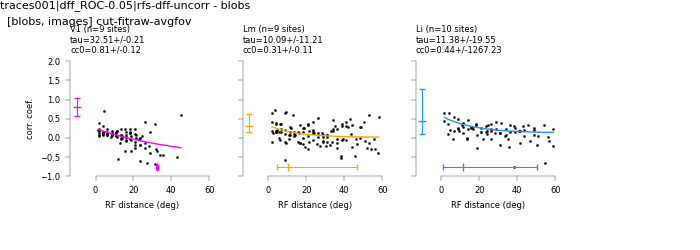

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning rf_distance_curves_cut-fitraw-avgfov


In [72]:
x_pos = -100 if to_quartile=='cortical_distance' else -10
xlabel='cortical distance (um)' if to_quartile=='cortical_distance' \
            else 'RF distance (deg)'
print(xlabel)
use_best_r2=False
fig = cr.plot_fit_distance_curves(df, resdf.dropna(),  metric=metric, 
                            to_quartile=to_quartile, 
                            use_best_r2=use_best_r2, fit_sites=fit_sites,
                            area_colors=area_colors, xlabel=xlabel,
                            x_pos=x_pos, y_pos=-0.75,elinewidth=0.75,
                            ylim=(-1, 2), )
fig.text(0.01, 0.9, '[%s, %s] %s' \
             % (experiment, select_stimuli, bin_type), fontsize=8)

pplot.label_figure(fig, '%s - %s' % (data_id, experiment))
figname = '%s_curves_%s%s' % (to_quartile, bin_type, stim_str)
#pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [559]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning'

In [516]:
va='V1'
dk='20190616_JC097_fov1'
df_ = avg_responses[(avg_responses.visual_area==va) & (avg_responses.datakey==dk)]

In [519]:

posdf_ = aggr.add_roi_positions(df_)
if rfdf is not None:
    posdf0 = posdf_.copy()
    curr_rfs = rfdf[(rfdf.visual_area==va) & (rfdf.datakey==dk)].copy()
    posdf_ = cr.get_roi_pos_and_rfs(posdf0, curr_rfs, rfs_only=False, 
                                merge_cols=['visual_area', 'datakey', 'cell'])
    if posdf_.shape[0]==0:
        print(va, dk)

In [520]:
posdf_

visual_area              datakey  cell      ml_pos       ap_pos  \
0            V1  20190616_JC097_fov1     0  909.977299  1078.506458   
1            V1  20190616_JC097_fov1     1  864.288063  1099.246967   
2            V1  20190616_JC097_fov1     2  852.865753  1073.897456   
3            V1  20190616_JC097_fov1     9  873.806654  1023.198434   
4            V1  20190616_JC097_fov1    11  883.325245   993.239922   
..          ...                  ...   ...         ...          ...   
180          V1  20190616_JC097_fov1   424  207.505284  1048.547945   
181          V1  20190616_JC097_fov1   425   32.363209   772.007828   
182          V1  20190616_JC097_fov1   426   45.689237   811.184344   
183          V1  20190616_JC097_fov1   429  138.971429   520.817221   
184          V1  20190616_JC097_fov1   431  685.338552   919.495890   

            x0         y0  
0    34.263130 -10.628686  
1          NaN        NaN  
2    30.848143  -6.732552  
3    39.429009  -3.330024  
4    35.470047 -12.506376  
..         ...        ...  
180  29.780096  -2.802732  
181  20.431419  -7.071060  
182        NaN        NaN  
183  20.485330 -13.131780  
184        NaN        NaN  

[185 rows x 7 columns]

In [524]:

cc = cr.get_pw_curve_correlations(df_, stimulus='blobs')
diffs_ = cc.copy()

if 'x0' in posdf_.columns:
    adist = cr.get_pw_distance(diffs_, posdf_, xcoord='x0', ycoord='y0', 
                             label='rf_distance', add_eccentricity=True)
else:
    adist = cr.get_pw_distance(diffs_, posdf_, xcoord='ml_pos', ycoord='ap_pos', 
                             label='cortical_distance', add_eccentricity=False)


In [526]:
adist.head()

xcorr_morph  pearsons_morph  cosim_morph  cell_1  cell_2 neuron_pair  \
0     3.502203       -0.030559     0.876929       0       1         0_1   
1     2.839756        0.780673     0.942752       0       2         0_2   
2     3.129756        0.676105     0.936768       0       9         0_9   
3     2.824641       -0.381755     0.813232       0      11        0_11   
4     2.598988        0.200115     0.860275       0      12        0_12   

   xcorr_size  pearsons_size  cosim_size  rf_distance    max_ecc    min_ecc  \
0    1.900788       0.848862    0.958029          NaN        NaN        NaN   
1    1.832618       0.920442    0.977413     5.180927  35.873821  31.574280   
2    1.694492       0.994842    0.991813     8.941855  39.569379  35.873821   
3    1.768774       0.915901    0.965303     2.232122  37.610287  35.873821   
4    2.073319       0.958303    0.991609     9.247455  40.524749  35.873821   

   cortical_distance  
0          50.176439  
1          57.297221  
2          66.085498  
3          89.334843  
4         129.947597

In [486]:
no_rfs=[]

curr_rfs=None
if rfdf is not None:
    curr_rfs = rfdf[(rfdf.visual_area==va) & (rfdf.datakey==dk)].copy()
    posdf = cr.get_roi_pos_and_rfs(df_, curr_rfs, rfs_only=False, 
                                merge_cols=['visual_area', 'datakey', 'cell'])
    if curr_rfs.shape[0]==0:
        no_rfs.append((va, dk, exp))
else:
    posdf = aggr.add_roi_positions(df_)
no_rfs

[]

In [490]:
posdf_ = aggr.add_roi_positions(df_)
posdf_

visual_area              datakey  cell     config  response  size  \
0             V1  20190616_JC097_fov1     0  config006  0.073549  10.0   
1             V1  20190616_JC097_fov1     0  config007  0.062874  20.0   
2             V1  20190616_JC097_fov1     0  config008  0.089596  30.0   
3             V1  20190616_JC097_fov1     0  config009  0.102889  40.0   
4             V1  20190616_JC097_fov1     0  config010  0.181599  50.0   
...          ...                  ...   ...        ...       ...   ...   
8320          V1  20190616_JC097_fov1   431  config046  0.047672  10.0   
8321          V1  20190616_JC097_fov1   431  config047  0.014780  20.0   
8322          V1  20190616_JC097_fov1   431  config048  0.016424  30.0   
8323          V1  20190616_JC097_fov1   431  config049  0.016479  40.0   
8324          V1  20190616_JC097_fov1   431  config050  0.030694  50.0   

     morphlevel experiment animalid            fov   session    fov_xpos  \
0             0      blobs    JC097  FOV1_zoom2p0x  20190616   99.093542   
1             0      blobs    JC097  FOV1_zoom2p0x  20190616   99.093542   
2             0      blobs    JC097  FOV1_zoom2p0x  20190616   99.093542   
3             0      blobs    JC097  FOV1_zoom2p0x  20190616   99.093542   
4             0      blobs    JC097  FOV1_zoom2p0x  20190616   99.093542   
...         ...        ...      ...            ...       ...         ...   
8320        106      blobs    JC097  FOV1_zoom2p0x  20190616  258.104110   
8321        106      blobs    JC097  FOV1_zoom2p0x  20190616  258.104110   
8322        106      blobs    JC097  FOV1_zoom2p0x  20190616  258.104110   
8323        106      blobs    JC097  FOV1_zoom2p0x  20190616  258.104110   
8324        106      blobs    JC097  FOV1_zoom2p0x  20190616  258.104110   

      fov_xpos_pix    fov_ypos  fov_ypos_pix      ml_pos       ap_pos  
0             43.0   62.822701          33.0  909.977299  1078.506458  
1             43.0   62.822701          33.0  909.977299  1078.506458  
2             43.0   62.822701          33.0  909.977299  1078.506458  
3             43.0   62.822701          33.0  909.977299  1078.506458  
4             43.0   62.822701          33.0  909.977299  1078.506458  
...            ...         ...           ...         ...          ...  
8320         112.0  287.461448         151.0  685.338552   919.495890  
8321         112.0  287.461448         151.0  685.338552   919.495890  
8322         112.0  287.461448         151.0  685.338552   919.495890  
8323         112.0  287.461448         151.0  685.338552   919.495890  
8324         112.0  287.461448         151.0  685.338552   919.495890  

[8325 rows x 17 columns]

In [ ]:

cc = get_pw_curve_correlations(df_, n_intervals=n_intervals, stimulus=stimulus)
diffs_ = cc.copy()

# # Cortical and RF difff
# if 'ml_pos' not in df_.columns:
#     if stimulus=='blobs':
#         posdf0 = df_[['visual_area', 'datakey', 'experiment', 'cell']].drop_duplicates()
#     else:
#         posdf0 = df_.copy()
#     posdf_ = aggr.add_roi_positionsS(posdf0)
# else:
#     posdf_ = df_.copy()        

if 'x0' in posdf_.columns:
    adist = get_pw_distance(diffs_, posdf_, xcoord='x0', ycoord='y0', 
                             label='rf_distance', add_eccentricity=True)
else:
    adist = get_pw_distance(diffs_, posdf_, xcoord='ml_pos', ycoord='ap_pos', 
                             label='cortical_distance', add_eccentricity=False)

assert adist.shape[0]==cc.shape[0], 'Bad merging: %s, %s' (va, dk)